<a href="https://colab.research.google.com/github/marcelobenedito/quarantine_covid19_behavior_analysis/blob/master/quarantine_covid19_behavior_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mineração de dados via Twitter com aprendizado de máquina: análise de comportamentos da população brasileira em relação ao isolamento social, causado pelo COVID-19**

> O isolamento social, adotado como uma das soluções para o combate à pandemia, causada pelo novo Coronavírus, divide inúmeras opiniões. Parte da população brasileira desconsidera a recomendação, realizada pelo ministério da saúde. Diante disso, modelos de aprendizado de máquina serão propostos para classificar dados extraídos do Twitter, realizando a mineração de textos em busca de opiniões. Um algoritmo de aprendizado de máquina é capaz de receber um conjunto de dados de entrada e fornecer a classificação deste conjunto, utilizando o conhecimento obtido através de seu treinamento. Este artigo, busca classificar o perfil dos indivíduos que desconsideram o isolamento social, extraindo características, a fim de encontrar as possíveis motivações para o feito.



## **1. Initial settings**

> Inicialmente, houve a necessidade de definir alguns parâmetros para estabelecer a quantidade de tweets coletados, filtros de busca, número máximo iterações para cada de treinamento dos modelos de ML e entre outros. Sendo assim, foram realizas as configurações iniciais do projeto, que incluem a importação das bibliotecas utilizadas (como o Tweepy e sklearn), ajuste de fuso-horário e importação das credenciais do Twitter. As definições iniciais, são muito importantes para que os passos seguintes possam ser executados corretamente. Portanto, previamente é necessário realizar a importação das bibliotecas, das quais são utilizadas no projeto. A realização deste procedimento possibilita o uso das funcionalidades fornecidas pela biblioteca em particular. Já o ajuste de fuso-horário, permite manter a integridade das datas e seus respectivos horários, baseado no fuso-horário local. O principal motivo para a realização deste tipo de definição, está relacionado à extração dos tweets que, possuem data e horário de sua postagem.
Outro passo indispensável é a obtenção das credenciais da API do Twitter, que fornecem o acesso aos tweets. Para gerar as credenciais, foi necessário realizar o preenchimento de algumas informações obrigatórias como, o motivo para utilizar, como os dados seriam manuseados, onde os dados seriam divulgados e seus fins (lucrativo, acadêmico, hobby e entre outros). Para manter estas informações seguras, as credenciais obtidas foram armazenas em um arquivo Python, externo ao projeto, possibilitando que as informações sensíveis não fossem demonstradas explicitamente no código fonte do projeto.



**Install libraries**

In [ ]:
%matplotlib inline
!pip3 install unidecode
!pip3 install emoji
!pip3 install joblib

     |████████████████████████████████| 245kB 2.7MB/s 
     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=4ce7e71024e54c67d9041d1acb007e9df7d54d6aa8cd975131b8768f0162e89b
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


**Required imports**

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import string
import time
import json
import nltk
import re
from datetime import timedelta
from google.colab import drive
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from emoji import demojize
from pytz import timezone

**Mounting drive and downloading stop words**

In [ ]:
drive.mount('/content/drive')
nltk.download('stopwords')

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Add America/São Paulo timezone for this notebook**

In [ ]:
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/America/Sao_Paulo /etc/localtime
!date

tz = timezone('America/Sao_Paulo')

Thu Nov  5 19:11:30 -03 2020


In [ ]:
#plt.style.use('bmh')
plt.style.use('ggplot')

## **2. Extract tweets**

> Após implementar todas as configurações iniciais, foi dado início às implementações, relacionadas à coleta de dados. Para isso, a busca pelos tweets foi realizada utilizando parâmetros específicos para filtrar o conjunto de dados. Neste trabalho, foram consultadas às postagens que remetem ao deslocamento para possíveis locais com  aglomerações, frequentar eventos, festas, viagens e entre outros. Inicialmente, foi determinado a coleta de 30 mil tweets para cada execução da função. Sendo assim, a coleta dos dados foi realizada através do método de busca por palavras-chave. Este método permite solicitar buscas por tweets de acordo com os termos desejados. Portanto, para filtrar os tweets, as palavras relacionadas ao assunto foram informadas antes de solicitar os dados à API do Twitter, demonstrado em Tabela 1.
> A categoria gratuita da API disponibilizada pelo Twitter, estabelece regras para limitar a quantidade de requisições para cada aplicação, impossibilitando que novas solicitações sejam realizadas quando o número máximo for excedido (Twitter Developers, 2020). Com base nos limites estabelecidos, foi possível extrair cerca de 2700 tweets a cada 15 minutos, tendo início em 18 de agosto de 2020 e seu término em 13 de outubro de 2020. Deste modo, foi possível obter cerca de 2 milhões de registros durante o período. 
Após realizar a extração dos tweets, apenas as informações relevantes foram armazenadas como o nome do perfil, data e hora da postagem feita pelos usuários, conteúdo textual e geolocalização (quando a informação estava disponível). 

Parâmetros 1 | Parâmetros 2 | Parâmetros 3 | Parâmetros 4
--- | --- | --- | ---
quarentena |	coronavírus | isolar | vou
covid | isolamento | sair | indo
covid-19 | isolado | saindo | vamos



---




  
 

	





**Import Tweepy lib**

In [ ]:
import tweepy
import glob

**Get Twitter credentials**

In [ ]:
cd 'drive/My Drive/TCC/Credentials'

/content/drive/My Drive/TCC/Credentials


In [ ]:
from credentials import *

In [ ]:
cd '../Tweets'

/content/drive/My Drive/TCC/Tweets


**Handling the rate limit using cursors**

In [ ]:
def limit_handled(cursor, finishes):
    while True:
        try:
            if finishes == True:
              return
            yield cursor.next()
        except (tweepy.RateLimitError, StopIteration):
            if finishes == True:
              return
            else:
              print('\r{} [tweepy.RateLimitError] Rate limit exception...'.format(dt.datetime.now().astimezone(tz)), end='')
              time.sleep(15*60)

**Create a funcion to search tweets**

In [ ]:
def search_tweets(search_filter, since, until, limit, language):
  finishes = False
  for tweet in tweepy.Cursor(api.search, q=search_filter, until=until, lang=language, tweet_mode="extended").items(limit):
    tweets.append(tweet)
    print('\r{} [INFO] {} collected tweets!'.format(dt.datetime.now().astimezone(tz), len(tweets)), end='');
    if limit != None and len(tweets) == limit:
      return tweets

**API authentication**

In [ ]:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

**Defining filters used in search**

In [ ]:
contains_both_words = ''
exact_phrase = ''
contains_any_words = ('(quarentena OR covid OR covid-19 OR coronavirus '
                      ' OR coronavírus OR isolamento OR isolado OR isolar'
                      ' OR sair OR saindo OR indo OR vamos OR vou)')
contains_any_hashtags = ''
no_retweet = ''
language = 'pt'
until = dt.date.today() - dt.timedelta(days=7)
since = 'since:2020-01-01'
limit = 30000

search_filter = contains_both_words + ' ' + exact_phrase + ' ' + contains_any_words + ' ' + contains_any_hashtags + ' ' + since + no_retweet

**Extracting tweets based on search filter**

In [ ]:
tweets = []
started_at = dt.datetime.now()
print('{} [INFO] starting search...'.format(dt.datetime.now().astimezone(tz)))
tweets = search_tweets(search_filter, since, until, limit, language)
finished_at = dt.datetime.now()

2020-10-13 18:30:27.180591-03:00 [INFO] starting search...
2020-10-13 21:16:34.145767-03:00 [INFO] 30000 collected tweets!

**Transform Json to DataFrame and export to CSV file**

In [ ]:
df = pd.DataFrame({
      'created_at': tweet.created_at,
      'user_id': tweet.user.id, 
      'screen_name': tweet.user.screen_name,
      'geo': tweet.geo,
      'coordinates': tweet.coordinates,
      'place': tweet.place,
      'tweet_id': tweet.id, 
      'text': unidecode(tweet.full_text),
      'class': ''
  } for tweet in tweets)

df.to_csv('tweets_{}.csv'.format(dt.datetime.now().astimezone(tz)), encoding = 'utf-8', index = False)

**Printing found tweets**

In [ ]:
df.head()

created_at  ...  class
0 2020-10-05 23:59:59  ...       
1 2020-10-05 23:59:59  ...       
2 2020-10-05 23:59:59  ...       
3 2020-10-05 23:59:59  ...       
4 2020-10-05 23:59:59  ...       

[5 rows x 9 columns]

**Write to json file**

In [ ]:
df = pd.DataFrame(tweets)
df.to_json('tweets_{}.json'.format(dt.datetime.now().astimezone(tz)))
df.head()

0
0  Status(_api=<tweepy.api.API object at 0x7fcdbe...
1  Status(_api=<tweepy.api.API object at 0x7fcdbe...
2  Status(_api=<tweepy.api.API object at 0x7fcdbe...
3  Status(_api=<tweepy.api.API object at 0x7fcdbe...
4  Status(_api=<tweepy.api.API object at 0x7fcdbe...

**Merge csv files**

In [ ]:
files = glob.glob('*.csv')
print(files)
print('{} [INFO] starting merge...'.format(dt.datetime.now().astimezone(tz)))
merged_files = pd.concat([pd.read_csv(file_name) for file_name in files])
merged_files.to_csv('merged_tweets.csv'.format(dt.datetime.now().astimezone(tz)), encoding = 'utf-8', index = False)
print('{} [INFO] merge successful...'.format(dt.datetime.now().astimezone(tz)))

## **3. Preprocessing**

> Posteriormente, houve uma redução na quantidade de registros do conjunto de treino, aplicando o procedimento para remover conteúdos textuais duplicados. Este procedimento foi realizado através da função implementada para realizar o pré-processamento do conteúdo textual de cada um dos tweets. Sendo assim, todos os tweets já armazenados passaram pelo procedimento para filtrar o conteúdo, transformando-os em caixa baixa — pois, as letras maiúsculas e minúsculas são diferenciadas pela máquina, baseando-se na tabela ASCII —, adicionando apenas os elementos desejados, de forma que todo o conteúdo irrelevante pudesse ser removido, excluindo links, pontuações e sequência de letras repetidas (e.g. muuuuito). O procedimento também realiza a remoção de stop words que, segundo Attux (2017), são palavras que estão contidas em frases com enorme frequência, porém, não possuem valor significativo para análise. Como a palavra “não” possui enorme peso em uma frase, pois, altera o contexto (ou sentido) de uma frase, houve a adição de uma etapa durante o pré-processamento que, realiza a modificação de abreviações da palavra (e.g. n, ñ, nao). Este processo permite unificar a palavra, possibilitando que seu nível de relevância em uma frase seja compreendido.

This process is used to preprocess the tweet text:

 - Tokenize words;
 - Remove all stop words; 
 - Punctuaction rules; 
 - Unused characters;
 - Links from tweets.

In [ ]:
cd 'drive/My Drive/TCC/Tweets'

/content/drive/My Drive/TCC/Tweets


In [ ]:
def preprocessing(pd_serie, new_stopwords=[]):

  # Converting to lowercase
  pd_serie = pd_serie.str.lower()

  # Removing unused links
  pd_serie = pd_serie.str.replace(r"(http|@)\S+", "")

  # Transform short negation form
  pd_serie = pd_serie.str.split(' ', expand=True).replace('n','não').fillna('').apply(' '.join, 1)
  pd_serie = pd_serie.str.split(' ', expand=True).replace('ñ','não').fillna('').apply(' '.join, 1)
  pd_serie = pd_serie.str.split(' ', expand=True).replace('naum','não').fillna('').apply(' '.join, 1)

  # Remove repetitions
  pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
  pd_serie = pd_serie.str.replace(pattern, r"\1")

  # Removing stop words
  sw = stopwords.words('portuguese')
  sw.remove('não')
  sw.remove('sem')
  sw.remove('estou')
  sw.extend(new_stopwords)

  pd_serie = pd_serie.apply(
      lambda pd_serie: ' '.join([unidecode(word) for word in pd_serie.split() if word not in sw])
  )

  # Removing punctuation rules
  pd_serie = pd_serie.str.translate(str.maketrans('', '', string.punctuation))

  # Remove special chars
  pd_serie = pd_serie.apply(demojize)
  pd_serie = pd_serie.str.replace(r"::", ": :")
  pd_serie = pd_serie.str.replace(r"’", "'")
  pd_serie = pd_serie.str.replace(r"[^a-z\':_]", " ")

  return pd_serie

**Add negation tag to make emphasis in a negative phrase**

In [ ]:
def negative_phrase(phrase, words_context=[]):
  negative_word = 'nao'
  new_phrase = []
  has_negative_word = negative_word in phrase  
  contains_word_context = False

  if any(word_context in phrase for word_context in words_context):
    contains_word_context = True

  for word in phrase.split():
    if has_negative_word == True:
      word = word + ' nao'
    if word == negative_word:
      has_negative_word = True
    new_phrase.append(word)
  return (' '.join(new_phrase))

**Get tweets from CSV file**

In [ ]:
df = pd.read_csv('train.csv')
df[['created_at', 'geo', 'coordinates', 'place', 'text', 'class']].head()

created_at  ... class
0  8/12/2020 23:59  ...     0
1  8/12/2020 23:59  ...     0
2  8/12/2020 23:59  ...     0
3  8/12/2020 23:59  ...     0
4  8/12/2020 23:59  ...     0

[5 rows x 6 columns]

**Count amount of tweets in dataset**

In [ ]:
df.text.count()

33726

**Removing duplicate lines**

In [ ]:
df.drop_duplicates(['text'], inplace=True)

**Count lines**

In [ ]:
df.text.count()

24948

**Preproccessing data**

In [ ]:
classes = df['class']
tweets = preprocessing(df['text'])
tweets

0                       ia dar chutao nela p sair frente k
1        sempre achei famosinha ai medo interagir vamos...
2        rt banheiro balada falando pra menina q acabei...
4                                 mano pq sair falando pqp
5        entao vamos ficar separadas pq nao vou mandar ...
                               ...                        
33721    rt favor doria fiel protocolo nao tome ivermec...
33722    mlkd ta td aq base vou clc beat p noix resenha...
33723              real to entendendo so to indo ta ligado
33724    vou voltar malhar segunda aff vou ficar chata ...
33725    queria ta churrasco familia cantando molejo ma...
Length: 24948, dtype: object

**Classification of train**

In [ ]:
df['class'].unique()

array([0, 1])

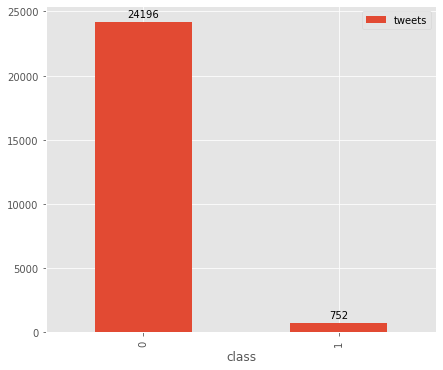

In [ ]:
class_dist = df.groupby('class').size().reset_index()
class_dist = class_dist.rename(columns={0: 'tweets'})
class_dist = class_dist.plot(kind='bar', x='class', y='tweets', figsize=(7, 6))
for p in class_dist.patches:
  class_dist.annotate(
      np.round(p.get_height(),decimals=2), 
      (p.get_x()+p.get_width()/2., p.get_height()), 
      ha='center', 
      va='center', 
      xytext=(0, 8), 
      textcoords='offset points'
  )
plt.show()

## **4. Training and predict process**

> Os treinamentos dos modelos foram realizados com todos os parâmetros padrões de cada um deles. Posteriormente, os números estipulados para dar início ao projeto adaptaram-se ao decorrer dos experimentos. 

In [ ]:
cd './../Models'

/content/drive/My Drive/TCC/Models


**Required libraries**

In [ ]:
import sklearn
import joblib
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report

**Define function to create a simple pipeline model**

In [ ]:
def new_pipeline(model, negative_form = False, n_gram = (1,1)):
  if negative_form:
    return Pipeline([
      ('vectorizer', CountVectorizer(tokenizer=lambda phrase: negative_phrase(phrase), ngram_range=n_gram)), 
      ('model', model)
    ])    
  else:
    return Pipeline([('model', model)])

**Define individual score function**

In [ ]:
def score(model_name, pipeline):
  score = pipeline.score(X_test, y_test)
  print('\r{} [INFO] Score of {} model with testing data is {:.1%}\n'
    .format(dt.datetime.now().astimezone(tz), model_name, score))
  return score

**Define cross validation function**

In [ ]:
def cross_validation(model_name, pipeline, X_train, y_train, k_fold):
  scores = cross_val_score(pipeline, X_train, y_train, cv=k_fold, n_jobs=-1)
  score = np.mean(scores)
  print("\r{0} [INFO] Score for {1} model: {2}".format(dt.datetime.now().astimezone(tz), model_name, score))
  return score


**Define plot confusion matrix function**

In [ ]:
def confusion_matrix(y_test, y_pred):
  confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Expected'], colnames=['Predicted'])
  sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.Blues)
  plt.show()

**Store MPL model in disk**

In [ ]:
def save_model(file_name, pipeline):
  joblib.dump(pipeline, file_name, compress=9)
  print('{} model was saved sucessfully!'.format(file_name))

**Split train/test first time**

In [ ]:
train_size=0.9
X_train, X_test, y_train, y_test = train_test_split(tweets,
                                                    classes,
                                                    train_size=train_size)

In [ ]:
X_train.count()

22453

In [ ]:
X_test.count()

2495

In [ ]:
df_train = pd.DataFrame(data={'X_train': X_train, 'y_train': y_train})
df_train.to_csv('train_splitted.csv', encoding = 'utf-8', index = False)

df_test = pd.DataFrame(data={'X_test': X_test, 'y_test': y_test})
df_test.to_csv('test_splitted.csv', encoding = 'utf-8', index = False)

**Read splitted data**

In [ ]:
df_train = pd.read_csv('train_splitted.csv')
df_test = pd.read_csv('test_splitted.csv')

In [ ]:
X_train = df_train['X_train']
y_train = df_train['y_train']
X_test = df_test['X_test']
y_test = df_test['y_test']

In [ ]:
# Vectorize all tweets using unigrams
vectorizer = CountVectorizer()
vectorized_tweets = vectorizer.fit_transform(tweets)
X_train_vectorized_unigram = vectorizer.transform(X_train)
X_test_vectorized_unigram = vectorizer.transform(X_test)

# Vectorize using bigrams
vectorizer_bigram = CountVectorizer(ngram_range=(2,2))
vectorizer_bigram.fit(tweets)
X_train_vectorized_bigram = vectorizer_bigram.transform(X_train)
X_test_vectorized_bigram = vectorizer_bigram.transform(X_test)

# Vectorize using unigrams and bigrams
vectorizer_unigram_bigram = CountVectorizer(ngram_range=(1,2))
vectorizer_unigram_bigram.fit(tweets)
X_train_vectorized_unigram_bigram = vectorizer_unigram_bigram.transform(X_train)
X_test_vectorized_unigram_bigram = vectorizer_unigram_bigram.transform(X_test)

# Vectorize using term frequency with unigrams
tf = TfidfTransformer(norm='l1')
tf.fit(vectorized_tweets)
X_train_tf = tf.transform(X_train_vectorized_unigram)
X_test_tf = tf.transform(X_test_vectorized_unigram)

# Vectorize using term frequency-inverse document frequency with unigrams
tfidf = TfidfTransformer(use_idf=True, norm='l1')
tfidf.fit(vectorized_tweets)
X_train_tfidf = tfidf.transform(X_train_vectorized_unigram)
X_test_tfidf = tfidf.transform(X_test_vectorized_unigram)

# Vectorize using unigrams and negative tokenizer
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text))
vectorized_tweets_neg = negative_vectorizer.fit_transform(tweets)

### **4.1 - MLPClassifier**

> Inicialmente, o modelo MLP foi treinado com 1 camada intermediária, contendo 100 neurônios e o máximo de 200 iterações. A quantidade de camadas passou para 3, mantendo o número de neurônios para cada camada e máximo de 500 iterações. Em seguida, os dois exemplos foram treinados com diferentes funções de ativação e parâmetros para otimização do peso. Os parâmetros definidos foram alternados no treinamento. Desta forma, 60 modelos de MLP foram treinados, onde cada um deles consumiu cerca de 1 hora, totalizando aproximadamente 60 horas.

####**4.1.1 - Multilayer Perceptron - Model 1**

- Hidden layers = 1
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 200
- Solver = ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
- Activation = ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(verbose=10, random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(verbose=10, random_state=42))
mlp_tf = new_pipeline(MLPClassifier(verbose=10, random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-16 15:14:14.735156-03:00 [INFO] starting training...
Iteration 1, loss = 0.22347659
Iteration 2, loss = 0.10203503
Iteration 3, loss = 0.07174282
Iteration 4, loss = 0.05549978
Iteration 5, loss = 0.04293697
Iteration 6, loss = 0.03224314
Iteration 7, loss = 0.02481147
Iteration 8, loss = 0.01989459
Iteration 9, loss = 0.01610146
Iteration 10, loss = 0.01319459
Iteration 11, loss = 0.01120616
Iteration 12, loss = 0.00950715
Iteration 13, loss = 0.00830130
Iteration 14, loss = 0.00734086
Iteration 15, loss = 0.00651450
Iteration 16, loss = 0.00597054
Iteration 17, loss = 0.00536051
Iteration 18, loss = 0.00493091
Iteration 19, loss = 0.00452831
Iteration 20, loss = 0.00416886
Iteration 21, loss = 0.00395902
Iteration 22, loss = 0.00367674
Iteration 23, loss = 0.00350631
Iteration 24, loss = 0.00330486
Iteration 25, loss = 0.00311059
Iteration 26, loss = 0.00302009
Iteration 27, loss = 0.00311138
Iteration 28, loss = 0.00269566
Iteration 29, loss = 0.00250996
Iteration 30, loss =

In [ ]:
save_model("mlp_unigram_1", mlp_unigram)
save_model("mlp_bigram_1", mlp_bigram)
save_model("mlp_unigram_bigram_1", mlp_unigram_bigram)
save_model("mlp_tf_1", mlp_tf)
save_model("mlp_tfidf_1", mlp_tfidf)

mlp_unigram_1 model was saved sucessfully!
mlp_bigram_1 model was saved sucessfully!
mlp_unigram_bigram_1 model was saved sucessfully!
mlp_tf_1 model was saved sucessfully!
mlp_tfidf_1 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_1')
mlp_bigram = joblib.load('mlp_bigram_1')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_1')
mlp_tf = joblib.load('mlp_tf_1')
mlp_tfidf = joblib.load('mlp_tfidf_1')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_1 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_1 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_1 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_1 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 16:17:48.747288-03:00 [INFO] starting predict...
2020-10-17 16:17:48.811019-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.DataFrame({'tweet' : X_test})
df_predict_results['class_mlp_unigram_1'] = y_pred_mlp_unigram_1
df_predict_results['class_mlp_bigram_1'] = y_pred_mlp_bigram_1
df_predict_results['class_mlp_unigram_bigram_1'] = y_pred_mlp_unigram_bigram_1
df_predict_results['class_mlp_tf_1'] = y_pred_mlp_tf_1
df_predict_results['class_mlp_tfidf_1'] = y_pred_mlp_tfidf_1
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.2 - Multilayer Perceptron - Model 2**

- Hidden layers = 3
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 500
- Solver = ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
- Activation = ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)


In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, verbose=10, random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, verbose=10, random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, verbose=10, random_state=42))
mlp_tf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, verbose=10, random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-16 16:34:05.339156-03:00 [INFO] starting training...
Iteration 1, loss = 0.21692690
Iteration 2, loss = 0.08070586
Iteration 3, loss = 0.04643393
Iteration 4, loss = 0.02435175
Iteration 5, loss = 0.01197845
Iteration 6, loss = 0.00664954
Iteration 7, loss = 0.00449155
Iteration 8, loss = 0.00307803
Iteration 9, loss = 0.00251165
Iteration 10, loss = 0.00180714
Iteration 11, loss = 0.00169881
Iteration 12, loss = 0.00154362
Iteration 13, loss = 0.00133425
Iteration 14, loss = 0.00141402
Iteration 15, loss = 0.00104157
Iteration 16, loss = 0.00081993
Iteration 17, loss = 0.00092807
Iteration 18, loss = 0.00071797
Iteration 19, loss = 0.00106761
Iteration 20, loss = 0.00076373
Iteration 21, loss = 0.00064248
Iteration 22, loss = 0.00076205
Iteration 23, loss = 0.00062560
Iteration 24, loss = 0.00056996
Iteration 25, loss = 0.00055730
Iteration 26, loss = 0.00060662
Iteration 27, loss = 0.00059257
Iteration 28, loss = 0.00052396
Iteration 29, loss = 0.00057550
Training loss did no

In [ ]:
save_model("mlp_unigram_2", mlp_unigram)
save_model("mlp_bigram_2", mlp_bigram)
save_model("mlp_unigram_bigram_2", mlp_unigram_bigram)
save_model("mlp_tf_2", mlp_tf)
save_model("mlp_tfidf_2", mlp_tfidf)

mlp_unigram_2 model was saved sucessfully!
mlp_bigram_2 model was saved sucessfully!
mlp_unigram_bigram_2 model was saved sucessfully!
mlp_tf_2 model was saved sucessfully!
mlp_tfidf_2 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_2')
mlp_bigram = joblib.load('mlp_bigram_2')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_2')
mlp_tf = joblib.load('mlp_tf_2')
mlp_tfidf = joblib.load('mlp_tfidf_2')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_2 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_2 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_2 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_2 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_2 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 16:21:34.843733-03:00 [INFO] starting predict...
2020-10-17 16:21:34.941092-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_2'] = y_pred_mlp_unigram_2
df_predict_results['class_mlp_bigram_2'] = y_pred_mlp_bigram_2
df_predict_results['class_mlp_unigram_bigram_2'] = y_pred_mlp_unigram_bigram_2
df_predict_results['class_mlp_tf_2'] = y_pred_mlp_tf_2
df_predict_results['class_mlp_tfidf_2'] = y_pred_mlp_tfidf_2
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.3 - Multilayer Perceptron - Model 3**

- Hidden layers = 1
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 200
- Solver = ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
- Activation = ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x))(0, x)

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, activation='logistic', random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(verbose=10, activation='logistic', random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(verbose=10, activation='logistic', random_state=42))
mlp_tf = new_pipeline(MLPClassifier(verbose=10, activation='logistic', random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(verbose=10, activation='logistic', random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-16 17:30:07.216063-03:00 [INFO] starting training...
Iteration 1, loss = 0.15063608
Iteration 2, loss = 0.12042719
Iteration 3, loss = 0.10888165
Iteration 4, loss = 0.09655026
Iteration 5, loss = 0.08438163
Iteration 6, loss = 0.07362904
Iteration 7, loss = 0.06466312
Iteration 8, loss = 0.05749809
Iteration 9, loss = 0.05148117
Iteration 10, loss = 0.04654994
Iteration 11, loss = 0.04240695
Iteration 12, loss = 0.03895724
Iteration 13, loss = 0.03605280
Iteration 14, loss = 0.03346746
Iteration 15, loss = 0.03123579
Iteration 16, loss = 0.02931367
Iteration 17, loss = 0.02757618
Iteration 18, loss = 0.02583418
Iteration 19, loss = 0.02448456
Iteration 20, loss = 0.02320860
Iteration 21, loss = 0.02199923
Iteration 22, loss = 0.02091237
Iteration 23, loss = 0.01990516
Iteration 24, loss = 0.01900323
Iteration 25, loss = 0.01819775
Iteration 26, loss = 0.01736681
Iteration 27, loss = 0.01665538
Iteration 28, loss = 0.01591166
Iteration 29, loss = 0.01530523
Iteration 30, loss =

In [ ]:
save_model("mlp_unigram_3", mlp_unigram)
save_model("mlp_bigram_3", mlp_bigram)
save_model("mlp_unigram_bigram_3", mlp_unigram_bigram)
save_model("mlp_tf_3", mlp_tf)
save_model("mlp_tfidf_3", mlp_tfidf)

mlp_unigram_3 model was saved sucessfully!
mlp_bigram_3 model was saved sucessfully!
mlp_unigram_bigram_3 model was saved sucessfully!
mlp_tf_3 model was saved sucessfully!
mlp_tfidf_3 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_3')
mlp_bigram = joblib.load('mlp_bigram_3')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_3')
mlp_tf = joblib.load('mlp_tf_3')
mlp_tfidf = joblib.load('mlp_tfidf_3')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_3 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_3 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_3 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_3 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_3 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 16:25:16.337778-03:00 [INFO] starting predict...
2020-10-17 16:25:16.457516-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_3'] = y_pred_mlp_unigram_3
df_predict_results['class_mlp_bigram_3'] = y_pred_mlp_bigram_3
df_predict_results['class_mlp_unigram_bigram_3'] = y_pred_mlp_unigram_bigram_3
df_predict_results['class_mlp_tf_3'] = y_pred_mlp_tf_3
df_predict_results['class_mlp_tfidf_3'] = y_pred_mlp_tfidf_3
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.4 - Multilayer Perceptron - Model 4**

- Hidden layers = 3
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 500
- Solver = ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
- Activation = ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x))(0, x)


In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='logistic',max_iter=500, verbose=10, random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='logistic',max_iter=500, verbose=10, random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='logistic',max_iter=500, verbose=10, random_state=42))
mlp_tf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='logistic',max_iter=500, verbose=10, random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='logistic',max_iter=500, verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-16 21:36:30.593192-03:00 [INFO] starting training...
Iteration 1, loss = 0.17113317
Iteration 2, loss = 0.13300737
Iteration 3, loss = 0.13190289
Iteration 4, loss = 0.13021951
Iteration 5, loss = 0.12706142
Iteration 6, loss = 0.11901613
Iteration 7, loss = 0.09457464
Iteration 8, loss = 0.06574984
Iteration 9, loss = 0.04865460
Iteration 10, loss = 0.03829476
Iteration 11, loss = 0.03060805
Iteration 12, loss = 0.02539440
Iteration 13, loss = 0.02101809
Iteration 14, loss = 0.01824782
Iteration 15, loss = 0.01587086
Iteration 16, loss = 0.01368320
Iteration 17, loss = 0.01149916
Iteration 18, loss = 0.00998337
Iteration 19, loss = 0.00886308
Iteration 20, loss = 0.00801733
Iteration 21, loss = 0.00786696
Iteration 22, loss = 0.00689800
Iteration 23, loss = 0.00668600
Iteration 24, loss = 0.00607026
Iteration 25, loss = 0.00595021
Iteration 26, loss = 0.00601309
Iteration 27, loss = 0.00546419
Iteration 28, loss = 0.00503946
Iteration 29, loss = 0.00488122
Iteration 30, loss =

In [ ]:
save_model("mlp_unigram_4", mlp_unigram)
save_model("mlp_bigram_4", mlp_bigram)
save_model("mlp_unigram_bigram_4", mlp_unigram_bigram)
save_model("mlp_tf_4", mlp_tf)
save_model("mlp_tfidf_4", mlp_tfidf)

mlp_unigram_4 model was saved sucessfully!
mlp_bigram_4 model was saved sucessfully!
mlp_unigram_bigram_4 model was saved sucessfully!
mlp_tf_4 model was saved sucessfully!
mlp_tfidf_4 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_4')
mlp_bigram = joblib.load('mlp_bigram_4')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_4')
mlp_tf = joblib.load('mlp_tf_4')
mlp_tfidf = joblib.load('mlp_tfidf_4')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_4 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_4 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_4 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_4 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_4 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 16:27:07.203260-03:00 [INFO] starting predict...
2020-10-17 16:27:07.483653-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_4'] = y_pred_mlp_unigram_4
df_predict_results['class_mlp_bigram_4'] = y_pred_mlp_bigram_4
df_predict_results['class_mlp_unigram_bigram_4'] = y_pred_mlp_unigram_bigram_4
df_predict_results['class_mlp_tf_4'] = y_pred_mlp_tf_4
df_predict_results['class_mlp_tfidf_4'] = y_pred_mlp_tfidf_4
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.5 - Multilayer Perceptron - Model 5**

- Hidden layers = 1
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 200
- Solver = ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
- Activation = ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x)

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, activation='tanh', random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(verbose=10, activation='tanh', random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(verbose=10, activation='tanh', random_state=42))
mlp_tf = new_pipeline(MLPClassifier(verbose=10, activation='tanh', random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(verbose=10, activation='tanh', random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 14:09:06.410655-03:00 [INFO] starting training...
Iteration 1, loss = 0.19908123
Iteration 2, loss = 0.08978564
Iteration 3, loss = 0.05847744
Iteration 4, loss = 0.04151959
Iteration 5, loss = 0.03131323
Iteration 6, loss = 0.02501532
Iteration 7, loss = 0.02045592
Iteration 8, loss = 0.01730714
Iteration 9, loss = 0.01460848
Iteration 10, loss = 0.01258178
Iteration 11, loss = 0.01118414
Iteration 12, loss = 0.00976402
Iteration 13, loss = 0.00886609
Iteration 14, loss = 0.00841593
Iteration 15, loss = 0.00743389
Iteration 16, loss = 0.00733392
Iteration 17, loss = 0.00687643
Iteration 18, loss = 0.00619381
Iteration 19, loss = 0.00581721
Iteration 20, loss = 0.00561647
Iteration 21, loss = 0.00574466
Iteration 22, loss = 0.00529952
Iteration 23, loss = 0.00513228
Iteration 24, loss = 0.00510724
Iteration 25, loss = 0.00489097
Iteration 26, loss = 0.00504823
Iteration 27, loss = 0.00519482
Iteration 28, loss = 0.00472577
Iteration 29, loss = 0.00452599
Iteration 30, loss =

In [ ]:
save_model("mlp_unigram_5", mlp_unigram)
save_model("mlp_bigram_5", mlp_bigram)
save_model("mlp_unigram_bigram_5", mlp_unigram_bigram)
save_model("mlp_tf_5", mlp_tf)
save_model("mlp_tfidf_5", mlp_tfidf)

mlp_unigram_5 model was saved sucessfully!
mlp_bigram_5 model was saved sucessfully!
mlp_unigram_bigram_5 model was saved sucessfully!
mlp_tf_5 model was saved sucessfully!
mlp_tfidf_5 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_5')
mlp_bigram = joblib.load('mlp_bigram_5')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_5')
mlp_tf = joblib.load('mlp_tf_5')
mlp_tfidf = joblib.load('mlp_tfidf_5')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_5 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_5 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_5 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_5 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_5 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 16:28:48.897788-03:00 [INFO] starting predict...
2020-10-17 16:28:48.991847-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_5'] = y_pred_mlp_unigram_5
df_predict_results['class_mlp_bigram_5'] = y_pred_mlp_bigram_5
df_predict_results['class_mlp_unigram_bigram_5'] = y_pred_mlp_unigram_bigram_5
df_predict_results['class_mlp_tf_5'] = y_pred_mlp_tf_5
df_predict_results['class_mlp_tfidf_5'] = y_pred_mlp_tfidf_5
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.6 - Multilayer Perceptron - Model 6**

- Hidden layers = 3
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 500
- Solver = ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
- Activation = ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x)


In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_tf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), activation='tanh', max_iter=500, verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 16:32:25.725986-03:00 [INFO] starting training...
Iteration 1, loss = 0.15804350
Iteration 2, loss = 0.06308340
Iteration 3, loss = 0.03245850
Iteration 4, loss = 0.02091930
Iteration 5, loss = 0.01531031
Iteration 6, loss = 0.01208603
Iteration 7, loss = 0.01051151
Iteration 8, loss = 0.00825539
Iteration 9, loss = 0.00743988
Iteration 10, loss = 0.00577647
Iteration 11, loss = 0.00550034
Iteration 12, loss = 0.00541787
Iteration 13, loss = 0.00445074
Iteration 14, loss = 0.00419656
Iteration 15, loss = 0.00381815
Iteration 16, loss = 0.00518388
Iteration 17, loss = 0.00508147
Iteration 18, loss = 0.00607063
Iteration 19, loss = 0.00692591
Iteration 20, loss = 0.00639645
Iteration 21, loss = 0.00572079
Iteration 22, loss = 0.00706991
Iteration 23, loss = 0.00558110
Iteration 24, loss = 0.00445840
Iteration 25, loss = 0.00341209
Iteration 26, loss = 0.00307518
Iteration 27, loss = 0.00294396
Iteration 28, loss = 0.00227040
Iteration 29, loss = 0.00235742
Iteration 30, loss =

In [ ]:
save_model("mlp_unigram_6", mlp_unigram)
save_model("mlp_bigram_6", mlp_bigram)
save_model("mlp_unigram_bigram_6", mlp_unigram_bigram)
save_model("mlp_tf_6", mlp_tf)
save_model("mlp_tfidf_6", mlp_tfidf)

mlp_unigram_6 model was saved sucessfully!
mlp_bigram_6 model was saved sucessfully!
mlp_unigram_bigram_6 model was saved sucessfully!
mlp_tf_6 model was saved sucessfully!
mlp_tfidf_6 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_6')
mlp_bigram = joblib.load('mlp_bigram_6')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_6')
mlp_tf = joblib.load('mlp_tf_6')
mlp_tfidf = joblib.load('mlp_tfidf_6')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_6 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_6 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_6 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_6 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_6 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 17:30:04.912534-03:00 [INFO] starting predict...
2020-10-17 17:30:05.142727-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_6'] = y_pred_mlp_unigram_6
df_predict_results['class_mlp_bigram_6'] = y_pred_mlp_bigram_6
df_predict_results['class_mlp_unigram_bigram_6'] = y_pred_mlp_unigram_bigram_6
df_predict_results['class_mlp_tf_6'] = y_pred_mlp_tf_6
df_predict_results['class_mlp_tfidf_6'] = y_pred_mlp_tfidf_6
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.7 - Multilayer Perceptron - Model 7**

- Hidden layers = 1
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 200
- Solver = ‘sgd’ refers to stochastic gradient descent.
- Activation = ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd', random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd', random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd', random_state=42))
mlp_tf = new_pipeline(MLPClassifier(verbose=10, solver='sgd', random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(verbose=10, solver='sgd', random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 17:51:39.240183-03:00 [INFO] starting training...
Iteration 1, loss = 0.48631388
Iteration 2, loss = 0.24950949
Iteration 3, loss = 0.17755085
Iteration 4, loss = 0.15322068
Iteration 5, loss = 0.14302339
Iteration 6, loss = 0.13803702
Iteration 7, loss = 0.13533389
Iteration 8, loss = 0.13374035
Iteration 9, loss = 0.13269036
Iteration 10, loss = 0.13190742
Iteration 11, loss = 0.13130523
Iteration 12, loss = 0.13078954
Iteration 13, loss = 0.13033679
Iteration 14, loss = 0.12990869
Iteration 15, loss = 0.12950832
Iteration 16, loss = 0.12912078
Iteration 17, loss = 0.12874516
Iteration 18, loss = 0.12837283
Iteration 19, loss = 0.12800806
Iteration 20, loss = 0.12764541
Iteration 21, loss = 0.12729151
Iteration 22, loss = 0.12693423
Iteration 23, loss = 0.12658474
Iteration 24, loss = 0.12623921
Iteration 25, loss = 0.12589590
Iteration 26, loss = 0.12555367
Iteration 27, loss = 0.12521514
Iteration 28, loss = 0.12487995
Iteration 29, loss = 0.12455093
Iteration 30, loss =

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.57982384
Iteration 2, loss = 0.34784116
Iteration 3, loss = 0.24068936
Iteration 4, loss = 0.19030126
Iteration 5, loss = 0.16526049
Iteration 6, loss = 0.15204884
Iteration 7, loss = 0.14473298
Iteration 8, loss = 0.14043917
Iteration 9, loss = 0.13783870
Iteration 10, loss = 0.13616072
Iteration 11, loss = 0.13507364
Iteration 12, loss = 0.13435197
Iteration 13, loss = 0.13387793
Iteration 14, loss = 0.13353888
Iteration 15, loss = 0.13327801
Iteration 16, loss = 0.13307533
Iteration 17, loss = 0.13291201
Iteration 18, loss = 0.13277546
Iteration 19, loss = 0.13265601
Iteration 20, loss = 0.13255095
Iteration 21, loss = 0.13245847
Iteration 22, loss = 0.13236121
Iteration 23, loss = 0.13227192
Iteration 24, loss = 0.13219268
Iteration 25, loss = 0.13210450
Iteration 26, loss = 0.13202478
Iteration 27, loss = 0.13194163
Iteration 28, loss = 0.13186020
Iteration 29, loss = 0.13178141
Iteration 30, loss = 0.13169826
Iteration 31, loss = 0.13161999
Training loss did

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.51364981
Iteration 2, loss = 0.29944035
Iteration 3, loss = 0.21265376
Iteration 4, loss = 0.17474335
Iteration 5, loss = 0.15653110
Iteration 6, loss = 0.14703112
Iteration 7, loss = 0.14178972
Iteration 8, loss = 0.13880475
Iteration 9, loss = 0.13704190
Iteration 10, loss = 0.13593113
Iteration 11, loss = 0.13526305
Iteration 12, loss = 0.13482232
Iteration 13, loss = 0.13454560
Iteration 14, loss = 0.13436133
Iteration 15, loss = 0.13423797
Iteration 16, loss = 0.13415994
Iteration 17, loss = 0.13410612
Iteration 18, loss = 0.13406647
Iteration 19, loss = 0.13404020
Iteration 20, loss = 0.13402100
Iteration 21, loss = 0.13400671
Iteration 22, loss = 0.13399282
Iteration 23, loss = 0.13398547
Iteration 24, loss = 0.13397609
Iteration 25, loss = 0.13397005
Iteration 26, loss = 0.13396406
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
2020-10-17 20:20:30.359548-03:00 [INFO] finish mlp_tf...
Iteration 1, loss = 0.51364981

In [ ]:
save_model("mlp_unigram_7", mlp_unigram)
save_model("mlp_bigram_7", mlp_bigram)
save_model("mlp_unigram_bigram_7", mlp_unigram_bigram)
save_model("mlp_tf_7", mlp_tf)
save_model("mlp_tfidf_7", mlp_tfidf)

mlp_unigram_7 model was saved sucessfully!
mlp_bigram_7 model was saved sucessfully!
mlp_unigram_bigram_7 model was saved sucessfully!
mlp_tf_7 model was saved sucessfully!
mlp_tfidf_7 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_7')
mlp_bigram = joblib.load('mlp_bigram_7')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_7')
mlp_tf = joblib.load('mlp_tf_7')
mlp_tfidf = joblib.load('mlp_tfidf_7')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_7 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_7 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_7 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_7 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_7 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-17 20:23:39.528714-03:00 [INFO] starting predict...
2020-10-17 20:23:39.627764-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_7'] = y_pred_mlp_unigram_7
df_predict_results['class_mlp_bigram_7'] = y_pred_mlp_bigram_7
df_predict_results['class_mlp_unigram_bigram_7'] = y_pred_mlp_unigram_bigram_7
df_predict_results['class_mlp_tf_7'] = y_pred_mlp_tf_7
df_predict_results['class_mlp_tfidf_7'] = y_pred_mlp_tfidf_7
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.8 - Multilayer Perceptron - Model 8**

- Hidden layers = 3
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 500
- Solver = ‘sgd’ refers to stochastic gradient descent.
- Activation = ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)


In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, solver='sgd', verbose=10, random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, solver='sgd', verbose=10, random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, solver='sgd', verbose=10, random_state=42))
mlp_tf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, solver='sgd', verbose=10, random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, solver='sgd', verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 09:53:36.601946-03:00 [INFO] starting training...
Iteration 1, loss = 0.53879644
Iteration 2, loss = 0.22226010
Iteration 3, loss = 0.15347554
Iteration 4, loss = 0.13833816
Iteration 5, loss = 0.13437303
Iteration 6, loss = 0.13313104
Iteration 7, loss = 0.13259190
Iteration 8, loss = 0.13226098
Iteration 9, loss = 0.13200790
Iteration 10, loss = 0.13176660
Iteration 11, loss = 0.13153177
Iteration 12, loss = 0.13131092
Iteration 13, loss = 0.13106848
Iteration 14, loss = 0.13082014
Iteration 15, loss = 0.13057870
Iteration 16, loss = 0.13031605
Iteration 17, loss = 0.13005699
Iteration 18, loss = 0.12979179
Iteration 19, loss = 0.12952155
Iteration 20, loss = 0.12925055
Iteration 21, loss = 0.12894693
Iteration 22, loss = 0.12864210
Iteration 23, loss = 0.12833659
Iteration 24, loss = 0.12801171
Iteration 25, loss = 0.12768376
Iteration 26, loss = 0.12734280
Iteration 27, loss = 0.12698610
Iteration 28, loss = 0.12662239
Iteration 29, loss = 0.12626373
Iteration 30, loss =

In [ ]:
save_model("mlp_unigram_8", mlp_unigram)
save_model("mlp_bigram_8", mlp_bigram)
save_model("mlp_unigram_bigram_8", mlp_unigram_bigram)
save_model("mlp_tf_8", mlp_tf)
save_model("mlp_tfidf_8", mlp_tfidf)

mlp_unigram_8 model was saved sucessfully!
mlp_bigram_8 model was saved sucessfully!
mlp_unigram_bigram_8 model was saved sucessfully!
mlp_tf_8 model was saved sucessfully!
mlp_tfidf_8 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_8')
mlp_bigram = joblib.load('mlp_bigram_8')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_8')
mlp_tf = joblib.load('mlp_tf_8')
mlp_tfidf = joblib.load('mlp_tfidf_8')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_8 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_8 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_8 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_8 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_8 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 12:24:18.995921-03:00 [INFO] starting predict...
2020-10-18 12:24:19.100328-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_8'] = y_pred_mlp_unigram_8
df_predict_results['class_mlp_bigram_8'] = y_pred_mlp_bigram_8
df_predict_results['class_mlp_unigram_bigram_8'] = y_pred_mlp_unigram_bigram_8
df_predict_results['class_mlp_tf_8'] = y_pred_mlp_tf_8
df_predict_results['class_mlp_tfidf_8'] = y_pred_mlp_tfidf_8
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.9 - Multilayer Perceptron - Model 9**

- Hidden layers = 1
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 200
- Solver = ‘sgd’ refers to stochastic gradient descent.
- Activation = ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x))(0, x)

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd',activation='logistic', random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd',activation='logistic', random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd',activation='logistic', random_state=42))
mlp_tf = new_pipeline(MLPClassifier(verbose=10, solver='sgd',activation='logistic', random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(verbose=10, solver='sgd',activation='logistic', random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 12:38:02.359205-03:00 [INFO] starting training...
Iteration 1, loss = 0.17463862
Iteration 2, loss = 0.13532210
Iteration 3, loss = 0.13418744
Iteration 4, loss = 0.13406331
Iteration 5, loss = 0.13402936
Iteration 6, loss = 0.13401381
Iteration 7, loss = 0.13400379
Iteration 8, loss = 0.13400050
Iteration 9, loss = 0.13398064
Iteration 10, loss = 0.13396722
Iteration 11, loss = 0.13396002
Iteration 12, loss = 0.13394321
Iteration 13, loss = 0.13395178
Iteration 14, loss = 0.13393102
Iteration 15, loss = 0.13391664
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
2020-10-18 12:39:21.727977-03:00 [INFO] finish mlp_unigram...
Iteration 1, loss = 0.22257947
Iteration 2, loss = 0.13547719
Iteration 3, loss = 0.13425416
Iteration 4, loss = 0.13407454
Iteration 5, loss = 0.13404684
Iteration 6, loss = 0.13404803
Iteration 7, loss = 0.13405146
Iteration 8, loss = 0.13404860
Iteration 9, loss = 0.13404033
Iteration 10, loss = 0.13405054
Itera

In [ ]:
save_model("mlp_unigram_9", mlp_unigram)
save_model("mlp_bigram_9", mlp_bigram)
save_model("mlp_unigram_bigram_9", mlp_unigram_bigram)
save_model("mlp_tf_9", mlp_tf)
save_model("mlp_tfidf_9", mlp_tfidf)

mlp_unigram_9 model was saved sucessfully!
mlp_bigram_9 model was saved sucessfully!
mlp_unigram_bigram_9 model was saved sucessfully!
mlp_tf_9 model was saved sucessfully!
mlp_tfidf_9 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_9')
mlp_bigram = joblib.load('mlp_bigram_9')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_9')
mlp_tf = joblib.load('mlp_tf_9')
mlp_tfidf = joblib.load('mlp_tfidf_9')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_9 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_9 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_9 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_9 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_9 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 12:56:30.805240-03:00 [INFO] starting predict...
2020-10-18 12:56:30.905083-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_9'] = y_pred_mlp_unigram_9
df_predict_results['class_mlp_bigram_9'] = y_pred_mlp_bigram_9
df_predict_results['class_mlp_unigram_bigram_9'] = y_pred_mlp_unigram_bigram_9
df_predict_results['class_mlp_tf_9'] = y_pred_mlp_tf_9
df_predict_results['class_mlp_tfidf_9'] = y_pred_mlp_tfidf_9
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.10 - Multilayer Perceptron - Model 10**

- Hidden layers = 3
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 500
- Solver = ‘sgd’ refers to stochastic gradient descent.
- Activation = ‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x))(0, x)


In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='logistic', max_iter=500, verbose=10, random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='logistic', max_iter=500, verbose=10, random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='logistic', max_iter=500, verbose=10, random_state=42))
mlp_tf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='logistic', max_iter=500, verbose=10, random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='logistic', max_iter=500, verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 13:47:18.454269-03:00 [INFO] starting training...
Iteration 1, loss = 0.21962030
Iteration 2, loss = 0.13503071
Iteration 3, loss = 0.13419086
Iteration 4, loss = 0.13411005
Iteration 5, loss = 0.13407962
Iteration 6, loss = 0.13408490
Iteration 7, loss = 0.13409004
Iteration 8, loss = 0.13408979
Iteration 9, loss = 0.13409298
Iteration 10, loss = 0.13408181
Iteration 11, loss = 0.13407347
Iteration 12, loss = 0.13409636
Iteration 13, loss = 0.13408972
Iteration 14, loss = 0.13407933
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
2020-10-18 13:48:37.985854-03:00 [INFO] finish mlp_unigram...
Iteration 1, loss = 0.20635222
Iteration 2, loss = 0.13520259
Iteration 3, loss = 0.13419291
Iteration 4, loss = 0.13409011
Iteration 5, loss = 0.13407842
Iteration 6, loss = 0.13408050
Iteration 7, loss = 0.13407637
Iteration 8, loss = 0.13409051
Iteration 9, loss = 0.13408355
Iteration 10, loss = 0.13408639
Iteration 11, loss = 0.13407539
Itera

In [ ]:
save_model("mlp_unigram_10", mlp_unigram)
save_model("mlp_bigram_10", mlp_bigram)
save_model("mlp_unigram_bigram_10", mlp_unigram_bigram)
save_model("mlp_tf_10", mlp_tf)
save_model("mlp_tfidf_10", mlp_tfidf)

mlp_unigram_10 model was saved sucessfully!
mlp_bigram_10 model was saved sucessfully!
mlp_unigram_bigram_10 model was saved sucessfully!
mlp_tf_10 model was saved sucessfully!
mlp_tfidf_10 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_10')
mlp_bigram = joblib.load('mlp_bigram_10')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_10')
mlp_tf = joblib.load('mlp_tf_10')
mlp_tfidf = joblib.load('mlp_tfidf_10')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_10 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_10 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_10 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_10 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_10 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 14:05:35.634710-03:00 [INFO] starting predict...
2020-10-18 14:05:35.835097-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_10'] = y_pred_mlp_unigram_10
df_predict_results['class_mlp_bigram_10'] = y_pred_mlp_bigram_10
df_predict_results['class_mlp_unigram_bigram_10'] = y_pred_mlp_unigram_bigram_10
df_predict_results['class_mlp_tf_10'] = y_pred_mlp_tf_10
df_predict_results['class_mlp_tfidf_10'] = y_pred_mlp_tfidf_10
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.11 - Multilayer Perceptron - Model 11**

- Hidden layers = 1
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 200
- Solver = ‘sgd’ refers to stochastic gradient descent.
- Activation = ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x)

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd', activation='tanh', random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd', activation='tanh', random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(verbose=10, solver='sgd', activation='tanh', random_state=42))
mlp_tf = new_pipeline(MLPClassifier(verbose=10, solver='sgd', activation='tanh', random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(verbose=10, solver='sgd', activation='tanh', random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 14:14:46.371049-03:00 [INFO] starting training...
Iteration 1, loss = 0.41224222
Iteration 2, loss = 0.19840737
Iteration 3, loss = 0.15757255
Iteration 4, loss = 0.14415207
Iteration 5, loss = 0.13837532
Iteration 6, loss = 0.13541797
Iteration 7, loss = 0.13371389
Iteration 8, loss = 0.13262410
Iteration 9, loss = 0.13182707
Iteration 10, loss = 0.13117549
Iteration 11, loss = 0.13062568
Iteration 12, loss = 0.13012485
Iteration 13, loss = 0.12966182
Iteration 14, loss = 0.12920911
Iteration 15, loss = 0.12877763
Iteration 16, loss = 0.12835357
Iteration 17, loss = 0.12793989
Iteration 18, loss = 0.12752856
Iteration 19, loss = 0.12712406
Iteration 20, loss = 0.12672149
Iteration 21, loss = 0.12632915
Iteration 22, loss = 0.12593355
Iteration 23, loss = 0.12554658
Iteration 24, loss = 0.12516486
Iteration 25, loss = 0.12478648
Iteration 26, loss = 0.12441007
Iteration 27, loss = 0.12403871
Iteration 28, loss = 0.12367206
Iteration 29, loss = 0.12331344
Iteration 30, loss =

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.51861506
Iteration 2, loss = 0.27509555
Iteration 3, loss = 0.19525808
Iteration 4, loss = 0.16396086
Iteration 5, loss = 0.14975939
Iteration 6, loss = 0.14261628
Iteration 7, loss = 0.13878181
Iteration 8, loss = 0.13656154
Iteration 9, loss = 0.13522769
Iteration 10, loss = 0.13435655
Iteration 11, loss = 0.13378460
Iteration 12, loss = 0.13339346
Iteration 13, loss = 0.13312704
Iteration 14, loss = 0.13292441
Iteration 15, loss = 0.13275240
Iteration 16, loss = 0.13260719
Iteration 17, loss = 0.13247807
Iteration 18, loss = 0.13236044
Iteration 19, loss = 0.13224949
Iteration 20, loss = 0.13214575
Iteration 21, loss = 0.13205085
Iteration 22, loss = 0.13194590
Iteration 23, loss = 0.13184753
Iteration 24, loss = 0.13175690
Iteration 25, loss = 0.13165549
Iteration 26, loss = 0.13156318
Iteration 27, loss = 0.13146650
Iteration 28, loss = 0.13137055
Iteration 29, loss = 0.13127766
Iteration 30, loss = 0.13117921
Iteration 31, loss = 0.13108621
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.45780828
Iteration 2, loss = 0.23536076
Iteration 3, loss = 0.17593452
Iteration 4, loss = 0.15433397
Iteration 5, loss = 0.14479968
Iteration 6, loss = 0.14004481
Iteration 7, loss = 0.13751150
Iteration 8, loss = 0.13611613
Iteration 9, loss = 0.13531490
Iteration 10, loss = 0.13481350
Iteration 11, loss = 0.13452673
Iteration 12, loss = 0.13433654
Iteration 13, loss = 0.13422363
Iteration 14, loss = 0.13414611
Iteration 15, loss = 0.13409450
Iteration 16, loss = 0.13406266
Iteration 17, loss = 0.13404002
Iteration 18, loss = 0.13402151
Iteration 19, loss = 0.13400867
Iteration 20, loss = 0.13399791
Iteration 21, loss = 0.13398892
Iteration 22, loss = 0.13397858
Iteration 23, loss = 0.13397295
Iteration 24, loss = 0.13396474
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
2020-10-18 16:27:24.586435-03:00 [INFO] finish mlp_tf...
Iteration 1, loss = 0.45780828
Iteration 2, loss = 0.23536076
Iteration 3, loss = 0.17593452
I

In [ ]:
save_model("mlp_unigram_11", mlp_unigram)
save_model("mlp_bigram_11", mlp_bigram)
save_model("mlp_unigram_bigram_11", mlp_unigram_bigram)
save_model("mlp_tf_11", mlp_tf)
save_model("mlp_tfidf_11", mlp_tfidf)

mlp_unigram_11 model was saved sucessfully!
mlp_bigram_11 model was saved sucessfully!
mlp_unigram_bigram_11 model was saved sucessfully!
mlp_tf_11 model was saved sucessfully!
mlp_tfidf_11 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_11')
mlp_bigram = joblib.load('mlp_bigram_11')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_11')
mlp_tf = joblib.load('mlp_tf_11')
mlp_tfidf = joblib.load('mlp_tfidf_11')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_11 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_11 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_11 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_11 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_11 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 16:30:19.857269-03:00 [INFO] starting predict...
2020-10-18 16:30:19.940033-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_11'] = y_pred_mlp_unigram_11
df_predict_results['class_mlp_bigram_11'] = y_pred_mlp_bigram_11
df_predict_results['class_mlp_unigram_bigram_11'] = y_pred_mlp_unigram_bigram_11
df_predict_results['class_mlp_tf_11'] = y_pred_mlp_tf_11
df_predict_results['class_mlp_tfidf_11'] = y_pred_mlp_tfidf_11
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

####**4.1.12 - Multilayer Perceptron - Model 12**

- Hidden layers = 3
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 500
- Solver = ‘sgd’ refers to stochastic gradient descent.
- Activation = ‘tanh’, the hyperbolic tan function, returns f(x) = tanh(x)


In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_unigram_bigram = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_tf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='tanh', max_iter=500, verbose=10, random_state=42))
mlp_tfidf = new_pipeline(MLPClassifier(hidden_layer_sizes=(100,100,100), solver='sgd', activation='tanh', max_iter=500, verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 17:47:30.262672-03:00 [INFO] starting training...
Iteration 1, loss = 0.35379305
Iteration 2, loss = 0.14126650
Iteration 3, loss = 0.13354101
Iteration 4, loss = 0.13220897
Iteration 5, loss = 0.13156162
Iteration 6, loss = 0.13104808
Iteration 7, loss = 0.13054468
Iteration 8, loss = 0.13003320
Iteration 9, loss = 0.12951010
Iteration 10, loss = 0.12897798
Iteration 11, loss = 0.12843736
Iteration 12, loss = 0.12790384
Iteration 13, loss = 0.12733313
Iteration 14, loss = 0.12674621
Iteration 15, loss = 0.12615782
Iteration 16, loss = 0.12553166
Iteration 17, loss = 0.12490064
Iteration 18, loss = 0.12425296
Iteration 19, loss = 0.12359022
Iteration 20, loss = 0.12291580
Iteration 21, loss = 0.12217730
Iteration 22, loss = 0.12143720
Iteration 23, loss = 0.12068915
Iteration 24, loss = 0.11990644
Iteration 25, loss = 0.11912278
Iteration 26, loss = 0.11831578
Iteration 27, loss = 0.11747544
Iteration 28, loss = 0.11662068
Iteration 29, loss = 0.11575992
Iteration 30, loss =

In [ ]:
save_model("mlp_unigram_12", mlp_unigram)
save_model("mlp_bigram_12", mlp_bigram)
save_model("mlp_unigram_bigram_12", mlp_unigram_bigram)
save_model("mlp_tf_12", mlp_tf)
save_model("mlp_tfidf_12", mlp_tfidf)

mlp_unigram_12 model was saved sucessfully!
mlp_bigram_12 model was saved sucessfully!
mlp_unigram_bigram_12 model was saved sucessfully!
mlp_tf_12 model was saved sucessfully!
mlp_tfidf_12 model was saved sucessfully!


**Load MLP model**

In [ ]:
mlp_unigram = joblib.load('mlp_unigram_12')
mlp_bigram = joblib.load('mlp_bigram_12')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_12')
mlp_tf = joblib.load('mlp_tf_12')
mlp_tfidf = joblib.load('mlp_tfidf_12')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_12 = mlp_unigram.predict(X_test_vectorized_unigram)
y_pred_mlp_bigram_12 = mlp_bigram.predict(X_test_vectorized_bigram)
y_pred_mlp_unigram_bigram_12 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_mlp_tf_12 = mlp_tf.predict(X_test_tf)
y_pred_mlp_tfidf_12 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-18 21:20:29.804745-03:00 [INFO] starting predict...
2020-10-18 21:20:30.100008-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_mlp_unigram_12'] = y_pred_mlp_unigram_12
df_predict_results['class_mlp_bigram_12'] = y_pred_mlp_bigram_12
df_predict_results['class_mlp_unigram_bigram_12'] = y_pred_mlp_unigram_bigram_12
df_predict_results['class_mlp_tf_12'] = y_pred_mlp_tf_12
df_predict_results['class_mlp_tfidf_12'] = y_pred_mlp_tfidf_12
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

### **4.2 - Naive Bayes**

**Create pipeline for MultinomialNB**

In [ ]:
nb_unigram = new_pipeline(MultinomialNB())
nb_bigram = new_pipeline(MultinomialNB())
nb_unigram_bigram = new_pipeline(MultinomialNB())
nb_tf = new_pipeline(MultinomialNB())
nb_tfidf = new_pipeline(MultinomialNB())

NameError: ignored

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
nb_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish nb_unigram...'.format(dt.datetime.now().astimezone(tz)))
nb_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish nb_bigram...'.format(dt.datetime.now().astimezone(tz)))
nb_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish nb_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
nb_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish nb_tf...'.format(dt.datetime.now().astimezone(tz)))
nb_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish nb_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

NameError: ignored

In [ ]:
save_model("nb_unigram_1", nb_unigram)
save_model("nb_bigram_1", nb_bigram)
save_model("nb_unigram_bigram_1", nb_unigram_bigram)
save_model("nb_tf_1", nb_tf)
save_model("nb_tfidf_1", nb_tfidf)

**Load MultinomialNB model**

In [ ]:
nb_unigram = joblib.load('nb_unigram_1')
nb_bigram = joblib.load('nb_bigram_1')
nb_unigram_bigram = joblib.load('nb_unigram_bigram_1')
nb_tf = joblib.load('nb_tf_1')
nb_tfidf = joblib.load('nb_tfidf_1')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_nb_unigram_1 = nb_unigram.predict(X_test_vectorized_unigram)
y_pred_nb_bigram_1 = nb_bigram.predict(X_test_vectorized_bigram)
y_pred_nb_unigram_bigram_1 = nb_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_nb_tf_1 = nb_tf.predict(X_test_tf)
y_pred_nb_tfidf_1 = nb_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_nb_unigram_1'] = y_pred_nb_unigram_1
df_predict_results['class_nb_bigram_1'] = y_pred_nb_bigram_1
df_predict_results['class_nb_unigram_bigram_1'] = y_pred_nb_unigram_bigram_1
df_predict_results['class_nb_tf_1'] = y_pred_nb_tf_1
df_predict_results['class_nb_tfidf_1'] = y_pred_nb_tfidf_1
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

**Plot confusion matrix**

In [ ]:
#print(pd.crosstab(y_train, results, rownames=['Real'], colnames=['Predicted'], margins=True))
confusion_matrix(pipe, X_test, y_test)

**Predict tweets**

In [ ]:
tests = X_test
predict_result = pipe.predict(X_test)
pd.DataFrame(zip(tests, predict_result), columns=['tweet', 'class'])

In [ ]:
test = [
        (unidecode('Amanhã vou pro rolê com as amigas!!!')),
        (unidecode('Estou indo no mercado')),
        (unidecode('Alguém que ir comigo na festa semana que vem?')),
        (unidecode('Tô na festa da Júlia e tá muito top!!!! Vem pra ca amiga')),
        (unidecode('Daqui a pouco vou no hospital fazer exame de sangue')),
        (unidecode('n estou saindo de casa pra nada')),
        (unidecode('n estou saindo de casa')),
        (unidecode('150 dias sem sair de casa. Quarentena tá me deixando loucooooo!!! :/'))
       ]

new_test = pd.DataFrame(test, columns=['text'])
new_test = preprocessing(new_test['text'])
'''new_test = new_test.apply(
    lambda new_test: ' '.join([negative_phrase(phrase) for phrase in new_test])
)'''
new_test

In [ ]:
predict_result = pipe.predict(new_test)
pd.DataFrame(zip(new_test, predict_result), columns=['tweet', 'class'])

### **4.3 - Support Vector Machine - LinearSVC**

In [ ]:
from sklearn.svm import LinearSVC

**Create pipeline for LinearSVC**

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
]
svc_unigram = GridSearchCV(LinearSVC(), param_grid)
svc_bigram = GridSearchCV(LinearSVC(), param_grid)
svc_unigram_bigram = GridSearchCV(LinearSVC(), param_grid)
svc_tf = GridSearchCV(LinearSVC(), param_grid)
svc_tfidf = GridSearchCV(LinearSVC(), param_grid)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
svc_unigram.fit(X_train_vectorized_unigram, y_train)
print('{} [INFO] finish svc_unigram...'.format(dt.datetime.now().astimezone(tz)))
svc_bigram.fit(X_train_vectorized_bigram, y_train)
print('{} [INFO] finish svc_bigram...'.format(dt.datetime.now().astimezone(tz)))
svc_unigram_bigram.fit(X_train_vectorized_unigram_bigram, y_train)
print('{} [INFO] finish svc_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
svc_tf.fit(X_train_tf, y_train)
print('{} [INFO] finish svc_tf...'.format(dt.datetime.now().astimezone(tz)))
svc_tfidf.fit(X_train_tfidf, y_train)
print('{} [INFO] finish svc_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-20 16:01:36.479558-03:00 [INFO] starting training...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2020-10-20 16:01:41.424945-03:00 [INFO] finish svc_unigram...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2020-10-20 16:02:02.185940-03:00 [INFO] finish svc_bigram...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2020-10-20 16:02:16.570492-03:00 [INFO] finish svc_unigram_bigram...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2020-10-20 16:02:23.362287-03:00 [INFO] finish svc_tf...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2020-10-20 16:02:30.112556-03:00 [INFO] finish svc_tfidf...
2020-10-20 16:02:30.112915-03:00 [INFO] training successful...


In [ ]:
save_model("svc_unigram_1", svc_unigram)
save_model("svc_bigram_1", svc_bigram)
save_model("svc_unigram_bigram_1", svc_unigram_bigram)
save_model("svc_tf_1", svc_tf)
save_model("svc_tfidf_1", svc_tfidf)

svc_unigram_1 model was saved sucessfully!
svc_bigram_1 model was saved sucessfully!
svc_unigram_bigram_1 model was saved sucessfully!
svc_tf_1 model was saved sucessfully!
svc_tfidf_1 model was saved sucessfully!


**Load LinearSVC model**

In [ ]:
svc_unigram = joblib.load('svc_unigram_1')
svc_bigram = joblib.load('svc_bigram_1')
svc_unigram_bigram = joblib.load('svc_unigram_bigram_1')
svc_tf = joblib.load('svc_tf_1')
svc_tfidf = joblib.load('svc_tfidf_1')

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_svc_unigram_1 = svc_unigram.predict(X_test_vectorized_unigram)
y_pred_svc_bigram_1 = svc_bigram.predict(X_test_vectorized_bigram)
y_pred_svc_unigram_bigram_1 = svc_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
y_pred_svc_tf_1 = svc_tf.predict(X_test_tf)
y_pred_svc_tfidf_1 = svc_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-20 16:02:31.834493-03:00 [INFO] starting predict...
2020-10-20 16:02:31.838912-03:00 [INFO] predict successful...


**Save predict result**

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results['class_svc_unigram_1'] = y_pred_svc_unigram_1
df_predict_results['class_svc_bigram_1'] = y_pred_svc_bigram_1
df_predict_results['class_svc_unigram_bigram_1'] = y_pred_svc_unigram_bigram_1
df_predict_results['class_svc_tf_1'] = y_pred_svc_tf_1
df_predict_results['class_svc_tfidf_1'] = y_pred_svc_tfidf_1
df_predict_results.to_csv('predict_results.csv', encoding = 'utf-8', index = False)

**Plot confusion matrix**

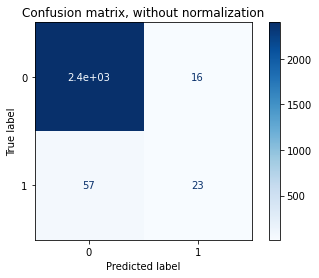

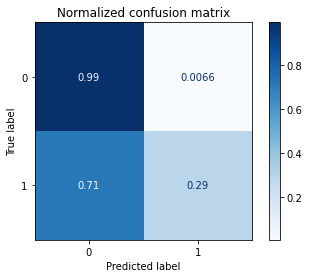

In [ ]:
#print(pd.crosstab(y_train, results, rownames=['Real'], colnames=['Predicted'], margins=True))
confusion_matrix(pipe, X_test, y_test)

**Predict tweets**

In [ ]:
tests = X_test
predict_result = pipe.predict(X_test)
pd.DataFrame(zip(tests, predict_result), columns=['tweet', 'class'])

tweet  class
0     vcs soubessem assedio inacreditavel passei hj ...      0
1                            deus edit lindo vou chorar      0
2     rt estou procurando trio pra jogar scrims pros...      0
3     tecnico ai nao vai certo nao garoto base later...      0
4     to insta quiser postar video vou postar nao pq...      0
...                                                 ...    ...
2490            to vendo vou perder prata comprando gas      0
2491                             cursinho      ai vamos      0
2492  ultimas vezes vi flamengo jogar assim contra e...      0
2493  vai ser preco custo entao todos valores pedido...      0
2494  nunca vou superar fato nao pra respirar enquan...      0

[2495 rows x 2 columns]

In [ ]:
test = [
        (unidecode('Amanhã vou pro rolê com as amigas!!!')),
        (unidecode('Estou indo no mercado')),
        (unidecode('Alguém que ir comigo na festa semana que vem?')),
        (unidecode('Tô na festa da Júlia e tá muito top!!!! Vem pra ca amiga')),
        (unidecode('Daqui a pouco vou no hospital fazer exame de sangue')),
        (unidecode('n estou saindo de casa pra nada')),
        (unidecode('n estou saindo de casa')),
        (unidecode('150 dias sem sair de casa. Quarentena tá me deixando loucooooo!!! :/'))
       ]

new_test = pd.DataFrame(test, columns=['text'])
new_test = preprocessing(new_test['text'])
'''new_test = new_test.apply(
    lambda new_test: ' '.join([negative_phrase(phrase) for phrase in new_test])
)'''
new_test

0                           amanha vou pro role amigas
1                                   estou indo mercado
2                    alguem ir comigo festa semana vem
3               to festa julia ta top vem pra ca amiga
4          daqui pouco vou hospital fazer exame sangue
5                       nao estou saindo casa pra nada
6                                nao estou saindo casa
7        dias sem sair casa quarentena ta deixando ...
dtype: object

In [ ]:
predict_result = pipe.predict(new_test)
pd.DataFrame(zip(new_test, predict_result), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      0
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      0
7      dias sem sair casa quarentena ta deixando ...      0

**Using GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
]

linear_svc_model = LinearSVC()
grid_search_linear_svc_model = GridSearchCV(linear_svc_model, param_grid)

**Create pipeline for GridSearch with LinearSVC**

In [ ]:
pipe = pipeline(grid_search_linear_svc_model, (1,2), False)

**Run training GridSearch with LinearSVC model**

In [ ]:
print('{} [INFO] starting train...'.format(dt.datetime.now().astimezone(tz)))
fit("GridSearchCV with LinearSVC", pipe, X_train, y_train, 10)
print('{} [INFO] train successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-06 17:10:12.282307-03:00 [INFO] starting train...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


2020-10-06 17:10:28.857184-03:00 [INFO] finish fit model...

2020-10-06 17:10:28.857392-03:00 [INFO] starting cross validation...

2020-10-06 17:12:31.915173-03:00 [INFO] Score for GridSearchCV with LinearSVC model: 0.970204292907758
2020-10-06 17:12:31.915954-03:00 [INFO] train successful...


**Plot confusion matrix**

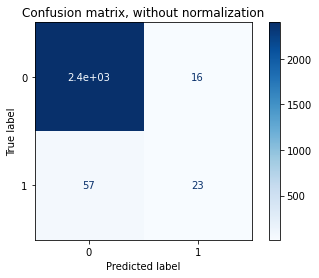

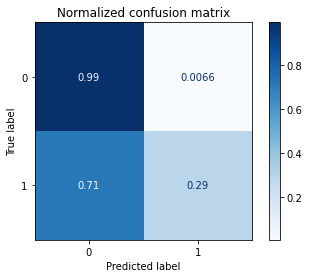

In [ ]:
#print(pd.crosstab(y_train, results, rownames=['Real'], colnames=['Predicted'], margins=True))
confusion_matrix(pipe, X_test, y_test)

**Predict tweets**

In [ ]:
tests = X_test
predict_result = pipe.predict(X_test)
pd.DataFrame(zip(tests, predict_result), columns=['tweet', 'class'])

tweet  class
0     vcs soubessem assedio inacreditavel passei hj ...      0
1                            deus edit lindo vou chorar      0
2     rt estou procurando trio pra jogar scrims pros...      0
3     tecnico ai nao vai certo nao garoto base later...      0
4     to insta quiser postar video vou postar nao pq...      0
...                                                 ...    ...
2490            to vendo vou perder prata comprando gas      0
2491                             cursinho      ai vamos      0
2492  ultimas vezes vi flamengo jogar assim contra e...      0
2493  vai ser preco custo entao todos valores pedido...      0
2494  nunca vou superar fato nao pra respirar enquan...      0

[2495 rows x 2 columns]

In [ ]:
test = [
        (unidecode('Amanhã vou pro rolê com as amigas!!!')),
        (unidecode('Estou indo no mercado')),
        (unidecode('Alguém que ir comigo na festa semana que vem?')),
        (unidecode('Tô na festa da Júlia e tá muito top!!!! Vem pra ca amiga')),
        (unidecode('Daqui a pouco vou no hospital fazer exame de sangue')),
        (unidecode('n estou saindo de casa pra nada')),
        (unidecode('n estou saindo de casa')),
        (unidecode('150 dias sem sair de casa. Quarentena tá me deixando loucooooo!!! :/'))
       ]

new_test = pd.DataFrame(test, columns=['text'])
new_test = preprocessing(new_test['text'])
'''new_test = new_test.apply(
    lambda new_test: ' '.join([negative_phrase(phrase) for phrase in new_test])
)'''
new_test

0                           amanha vou pro role amigas
1                                   estou indo mercado
2                    alguem ir comigo festa semana vem
3               to festa julia ta top vem pra ca amiga
4          daqui pouco vou hospital fazer exame sangue
5                       nao estou saindo casa pra nada
6                                nao estou saindo casa
7        dias sem sair casa quarentena ta deixando ...
dtype: object

In [ ]:
predict_result = pipe.predict(new_test)
pd.DataFrame(zip(new_test, predict_result), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      0
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      0
7      dias sem sair casa quarentena ta deixando ...      0

### **4.4 - Model evaluation**

In [ ]:
def get_report(model_name, y_test, y_pred):  
  print('{} [INFO] Metrics using {}'.format(dt.datetime.now().astimezone(tz), model_name))
  print('{} [INFO] Accuracy = {}'.format(dt.datetime.now().astimezone(tz), accuracy_score(y_test, y_pred)))
  print(classification_report(y_test, y_pred))
  confusion_matrix(y_test, y_pred)

In [ ]:
df_predict_results = pd.read_csv('predict_results.csv')
df_predict_results.head()

tweet  ...  class_svc_tfidf_1
0  nao quero fazer festa anos nao sei passa comig...  ...                  0
1                         ver q vou comprar aindamds  ...                  0
2                                      vamos fofocas  ...                  0
3  decidi assistir step up vou assistir todos nao...  ...                  0
4               quer dizer q casos covid estao queda  ...                  0

[5 rows x 71 columns]

In [ ]:
df_predict_results.drop(['class_svc_tfidf_1', 'class_nb_unigram_1',	
                         'class_nb_bigram_1',	'class_nb_unigram_bigram_1',	
                         'class_nb_tf_1',	'class_nb_tfidf_1',	'class_svc_unigram_1',	
                         'class_svc_bigram_1',	'class_svc_unigram_bigram_1',	
                         'class_svc_tf_1','class_mlp_tfidf_12'],
                        axis=1, inplace=True)
model_columns_result = df_predict_results.loc[:, df_predict_results.columns != 'tweet'].columns

In [ ]:
df_predict_results[model_columns_result]

class_mlp_unigram_1  ...  class_mlp_tf_12
0                       0  ...                0
1                       0  ...                0
2                       0  ...                0
3                       0  ...                0
4                       0  ...                0
...                   ...  ...              ...
2490                    0  ...                0
2491                    0  ...                0
2492                    0  ...                0
2493                    0  ...                0
2494                    0  ...                0

[2495 rows x 59 columns]

2020-10-26 17:50:05.565031-03:00 [INFO] Metrics using class_mlp_unigram_1
2020-10-26 17:50:05.566233-03:00 [INFO] Accuracy = 0.9635270541082165
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2412
           1       0.42      0.27      0.33        83

    accuracy                           0.96      2495
   macro avg       0.70      0.63      0.65      2495
weighted avg       0.96      0.96      0.96      2495



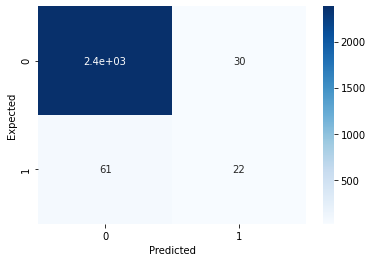

-----------------------------------------------------
2020-10-26 17:50:05.785812-03:00 [INFO] Metrics using class_mlp_bigram_1
2020-10-26 17:50:05.785929-03:00 [INFO] Accuracy = 0.969939879759519
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.68      0.18      0.29        83

    accuracy                           0.97      2495
   macro avg       0.83      0.59      0.64      2495
weighted avg       0.96      0.97      0.96      2495



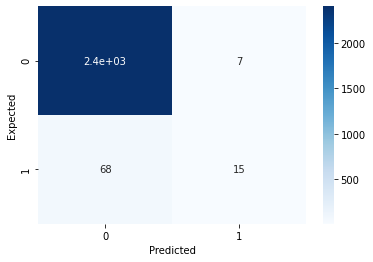

-----------------------------------------------------
2020-10-26 17:50:05.989792-03:00 [INFO] Metrics using class_mlp_unigram_bigram_1
2020-10-26 17:50:05.989892-03:00 [INFO] Accuracy = 0.9703406813627254
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.67      0.22      0.33        83

    accuracy                           0.97      2495
   macro avg       0.82      0.61      0.66      2495
weighted avg       0.96      0.97      0.96      2495



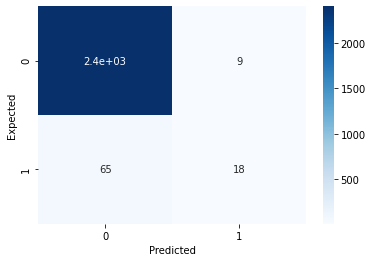

-----------------------------------------------------
2020-10-26 17:50:06.346571-03:00 [INFO] Metrics using class_mlp_tf_1
2020-10-26 17:50:06.346664-03:00 [INFO] Accuracy = 0.9623246492985972
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.39      0.24      0.30        83

    accuracy                           0.96      2495
   macro avg       0.68      0.61      0.64      2495
weighted avg       0.95      0.96      0.96      2495



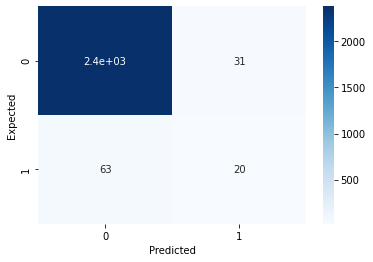

-----------------------------------------------------
2020-10-26 17:50:06.570579-03:00 [INFO] Metrics using class_mlp_tfidf_1
2020-10-26 17:50:06.570843-03:00 [INFO] Accuracy = 0.9623246492985972
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.39      0.24      0.30        83

    accuracy                           0.96      2495
   macro avg       0.68      0.61      0.64      2495
weighted avg       0.95      0.96      0.96      2495



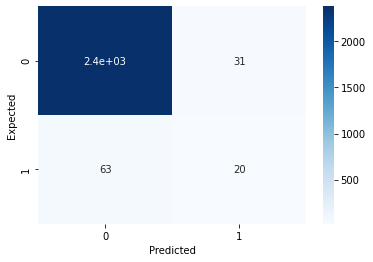

-----------------------------------------------------
2020-10-26 17:50:06.784100-03:00 [INFO] Metrics using class_mlp_unigram_2
2020-10-26 17:50:06.784216-03:00 [INFO] Accuracy = 0.9643286573146292
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2412
           1       0.45      0.35      0.39        83

    accuracy                           0.96      2495
   macro avg       0.72      0.67      0.69      2495
weighted avg       0.96      0.96      0.96      2495



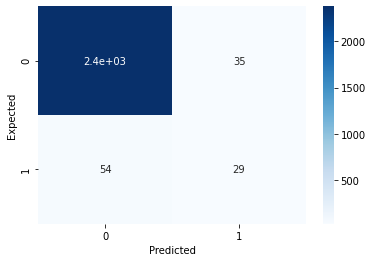

-----------------------------------------------------
2020-10-26 17:50:06.999713-03:00 [INFO] Metrics using class_mlp_bigram_2
2020-10-26 17:50:07.000143-03:00 [INFO] Accuracy = 0.9643286573146292
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.42      0.20      0.28        83

    accuracy                           0.96      2495
   macro avg       0.70      0.60      0.63      2495
weighted avg       0.95      0.96      0.96      2495



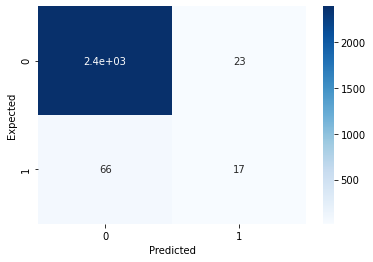

-----------------------------------------------------
2020-10-26 17:50:07.213822-03:00 [INFO] Metrics using class_mlp_unigram_bigram_2
2020-10-26 17:50:07.214143-03:00 [INFO] Accuracy = 0.9691382765531062
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.61      0.20      0.31        83

    accuracy                           0.97      2495
   macro avg       0.79      0.60      0.65      2495
weighted avg       0.96      0.97      0.96      2495



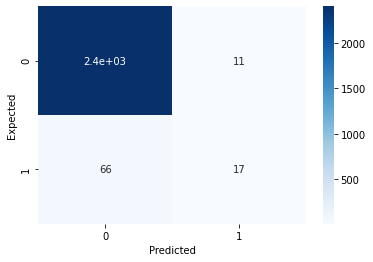

-----------------------------------------------------
2020-10-26 17:50:07.434094-03:00 [INFO] Metrics using class_mlp_tf_2
2020-10-26 17:50:07.434207-03:00 [INFO] Accuracy = 0.9595190380761524
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.36      0.29      0.32        83

    accuracy                           0.96      2495
   macro avg       0.67      0.64      0.65      2495
weighted avg       0.96      0.96      0.96      2495



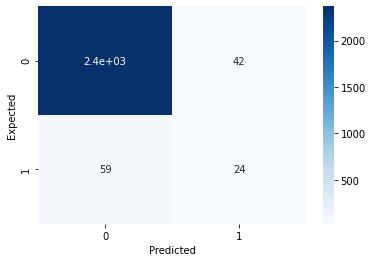

-----------------------------------------------------
2020-10-26 17:50:07.651054-03:00 [INFO] Metrics using class_mlp_tfidf_2
2020-10-26 17:50:07.651147-03:00 [INFO] Accuracy = 0.9595190380761524
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.36      0.29      0.32        83

    accuracy                           0.96      2495
   macro avg       0.67      0.64      0.65      2495
weighted avg       0.96      0.96      0.96      2495



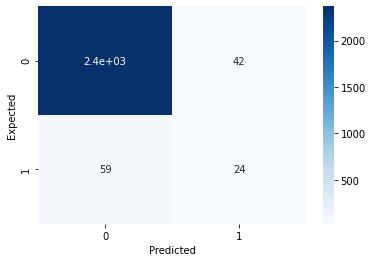

-----------------------------------------------------
2020-10-26 17:50:07.866475-03:00 [INFO] Metrics using class_mlp_unigram_3
2020-10-26 17:50:07.866579-03:00 [INFO] Accuracy = 0.9579158316633266
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.35      0.30      0.32        83

    accuracy                           0.96      2495
   macro avg       0.66      0.64      0.65      2495
weighted avg       0.96      0.96      0.96      2495



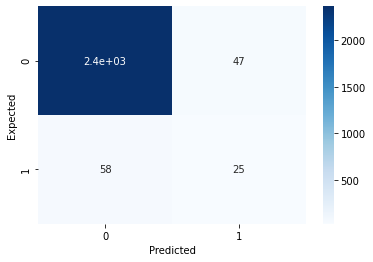

-----------------------------------------------------
2020-10-26 17:50:08.090443-03:00 [INFO] Metrics using class_mlp_bigram_3
2020-10-26 17:50:08.090546-03:00 [INFO] Accuracy = 0.969939879759519
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.68      0.18      0.29        83

    accuracy                           0.97      2495
   macro avg       0.83      0.59      0.64      2495
weighted avg       0.96      0.97      0.96      2495



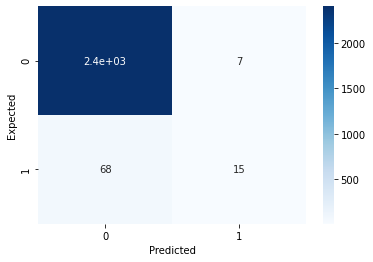

-----------------------------------------------------
2020-10-26 17:50:08.308740-03:00 [INFO] Metrics using class_mlp_unigram_bigram_3
2020-10-26 17:50:08.309043-03:00 [INFO] Accuracy = 0.969939879759519
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.62      0.25      0.36        83

    accuracy                           0.97      2495
   macro avg       0.80      0.62      0.67      2495
weighted avg       0.96      0.97      0.96      2495



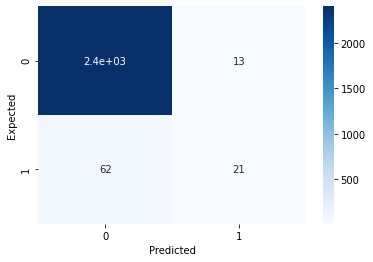

-----------------------------------------------------
2020-10-26 17:50:08.526151-03:00 [INFO] Metrics using class_mlp_tf_3
2020-10-26 17:50:08.526278-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.50      0.22      0.30        83

    accuracy                           0.97      2495
   macro avg       0.74      0.60      0.64      2495
weighted avg       0.96      0.97      0.96      2495



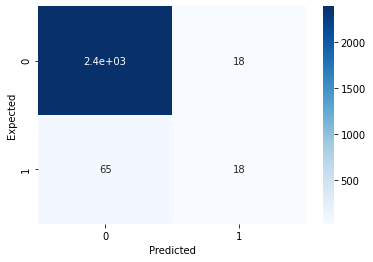

-----------------------------------------------------
2020-10-26 17:50:08.748165-03:00 [INFO] Metrics using class_mlp_tfidf_3
2020-10-26 17:50:08.748506-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.50      0.22      0.30        83

    accuracy                           0.97      2495
   macro avg       0.74      0.60      0.64      2495
weighted avg       0.96      0.97      0.96      2495



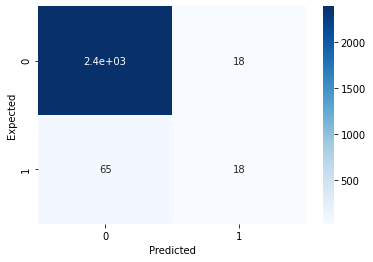

-----------------------------------------------------
2020-10-26 17:50:08.952573-03:00 [INFO] Metrics using class_mlp_unigram_4
2020-10-26 17:50:08.952683-03:00 [INFO] Accuracy = 0.9543086172344689
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.32      0.34      0.33        83

    accuracy                           0.95      2495
   macro avg       0.65      0.66      0.65      2495
weighted avg       0.96      0.95      0.95      2495



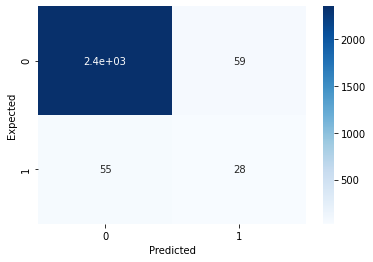

-----------------------------------------------------
2020-10-26 17:50:09.165265-03:00 [INFO] Metrics using class_mlp_bigram_4
2020-10-26 17:50:09.165560-03:00 [INFO] Accuracy = 0.96312625250501
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.41      0.24      0.30        83

    accuracy                           0.96      2495
   macro avg       0.69      0.61      0.64      2495
weighted avg       0.96      0.96      0.96      2495



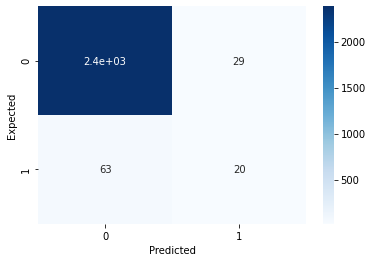

-----------------------------------------------------
2020-10-26 17:50:09.517703-03:00 [INFO] Metrics using class_mlp_unigram_bigram_4
2020-10-26 17:50:09.517797-03:00 [INFO] Accuracy = 0.9599198396793587
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.40      0.40      0.40        83

    accuracy                           0.96      2495
   macro avg       0.69      0.69      0.69      2495
weighted avg       0.96      0.96      0.96      2495



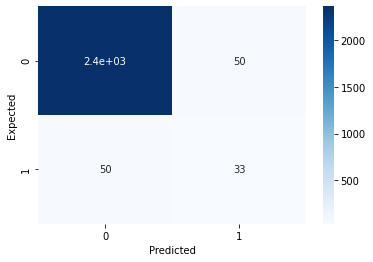

-----------------------------------------------------
2020-10-26 17:50:09.750752-03:00 [INFO] Metrics using class_mlp_tf_4
2020-10-26 17:50:09.750856-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.50      0.25      0.34        83

    accuracy                           0.97      2495
   macro avg       0.74      0.62      0.66      2495
weighted avg       0.96      0.97      0.96      2495



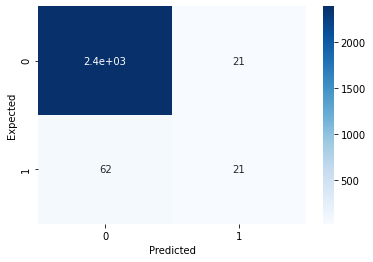

-----------------------------------------------------
2020-10-26 17:50:09.976292-03:00 [INFO] Metrics using class_mlp_tfidf_4
2020-10-26 17:50:09.976393-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.50      0.25      0.34        83

    accuracy                           0.97      2495
   macro avg       0.74      0.62      0.66      2495
weighted avg       0.96      0.97      0.96      2495



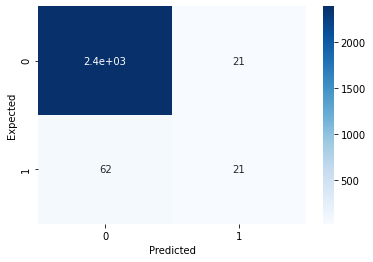

-----------------------------------------------------
2020-10-26 17:50:10.194979-03:00 [INFO] Metrics using class_mlp_unigram_5
2020-10-26 17:50:10.195085-03:00 [INFO] Accuracy = 0.9535070140280562
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.31      0.31      0.31        83

    accuracy                           0.95      2495
   macro avg       0.64      0.64      0.64      2495
weighted avg       0.95      0.95      0.95      2495



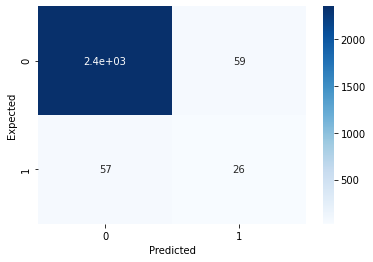

-----------------------------------------------------
2020-10-26 17:50:10.428353-03:00 [INFO] Metrics using class_mlp_bigram_5
2020-10-26 17:50:10.428457-03:00 [INFO] Accuracy = 0.969939879759519
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.67      0.19      0.30        83

    accuracy                           0.97      2495
   macro avg       0.82      0.59      0.64      2495
weighted avg       0.96      0.97      0.96      2495



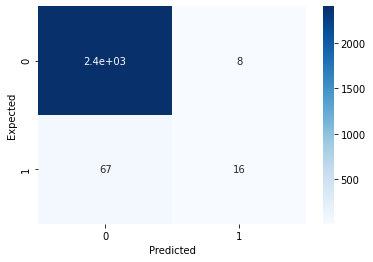

-----------------------------------------------------
2020-10-26 17:50:10.691267-03:00 [INFO] Metrics using class_mlp_unigram_bigram_5
2020-10-26 17:50:10.691410-03:00 [INFO] Accuracy = 0.9695390781563126
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.62      0.22      0.32        83

    accuracy                           0.97      2495
   macro avg       0.80      0.61      0.65      2495
weighted avg       0.96      0.97      0.96      2495



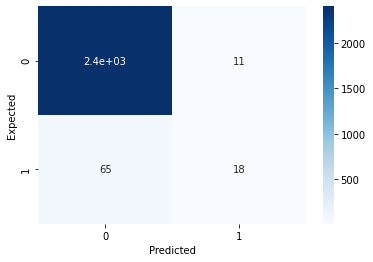

-----------------------------------------------------
2020-10-26 17:50:10.922007-03:00 [INFO] Metrics using class_mlp_tf_5
2020-10-26 17:50:10.922108-03:00 [INFO] Accuracy = 0.9607214428857715
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.35      0.22      0.27        83

    accuracy                           0.96      2495
   macro avg       0.66      0.60      0.62      2495
weighted avg       0.95      0.96      0.96      2495



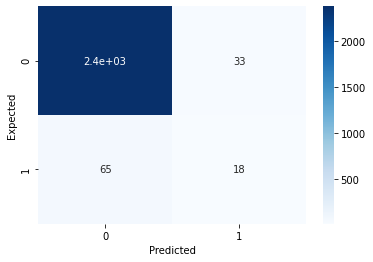

-----------------------------------------------------
2020-10-26 17:50:11.138316-03:00 [INFO] Metrics using class_mlp_tfidf_5
2020-10-26 17:50:11.138638-03:00 [INFO] Accuracy = 0.9607214428857715
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.35      0.22      0.27        83

    accuracy                           0.96      2495
   macro avg       0.66      0.60      0.62      2495
weighted avg       0.95      0.96      0.96      2495



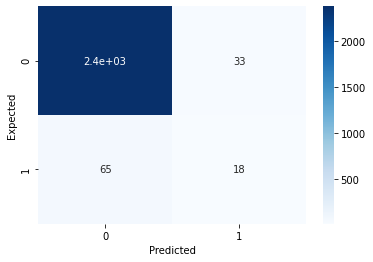

-----------------------------------------------------
2020-10-26 17:50:11.358033-03:00 [INFO] Metrics using class_mlp_unigram_6
2020-10-26 17:50:11.358389-03:00 [INFO] Accuracy = 0.958316633266533
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2412
           1       0.37      0.35      0.36        83

    accuracy                           0.96      2495
   macro avg       0.67      0.66      0.67      2495
weighted avg       0.96      0.96      0.96      2495



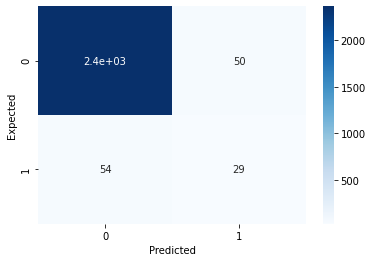

-----------------------------------------------------
2020-10-26 17:50:11.572879-03:00 [INFO] Metrics using class_mlp_bigram_6
2020-10-26 17:50:11.573208-03:00 [INFO] Accuracy = 0.9655310621242486
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.46      0.19      0.27        83

    accuracy                           0.97      2495
   macro avg       0.71      0.59      0.63      2495
weighted avg       0.96      0.97      0.96      2495



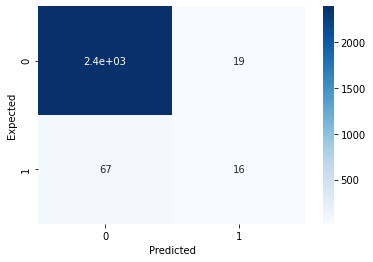

-----------------------------------------------------
2020-10-26 17:50:11.802349-03:00 [INFO] Metrics using class_mlp_unigram_bigram_6
2020-10-26 17:50:11.802443-03:00 [INFO] Accuracy = 0.9671342685370742
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.51      0.24      0.33        83

    accuracy                           0.97      2495
   macro avg       0.74      0.62      0.66      2495
weighted avg       0.96      0.97      0.96      2495



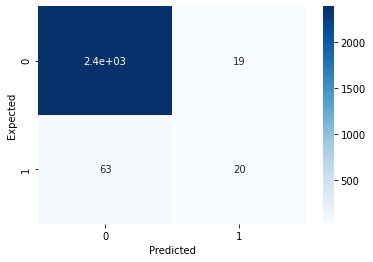

-----------------------------------------------------
2020-10-26 17:50:12.023419-03:00 [INFO] Metrics using class_mlp_tf_6
2020-10-26 17:50:12.023518-03:00 [INFO] Accuracy = 0.9478957915831663
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2412
           1       0.25      0.29      0.27        83

    accuracy                           0.95      2495
   macro avg       0.61      0.63      0.62      2495
weighted avg       0.95      0.95      0.95      2495



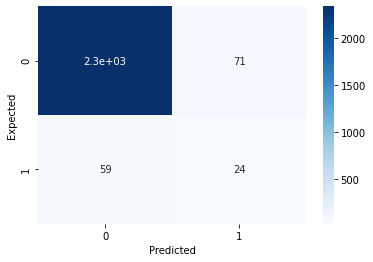

-----------------------------------------------------
2020-10-26 17:50:12.237232-03:00 [INFO] Metrics using class_mlp_tfidf_6
2020-10-26 17:50:12.237537-03:00 [INFO] Accuracy = 0.9478957915831663
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2412
           1       0.25      0.29      0.27        83

    accuracy                           0.95      2495
   macro avg       0.61      0.63      0.62      2495
weighted avg       0.95      0.95      0.95      2495



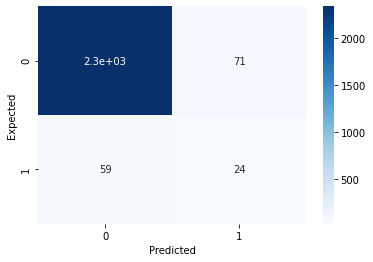

-----------------------------------------------------
2020-10-26 17:50:12.446672-03:00 [INFO] Metrics using class_mlp_unigram_7
2020-10-26 17:50:12.446762-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


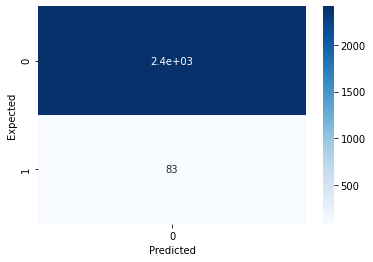

-----------------------------------------------------
2020-10-26 17:50:12.802051-03:00 [INFO] Metrics using class_mlp_bigram_7
2020-10-26 17:50:12.802140-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


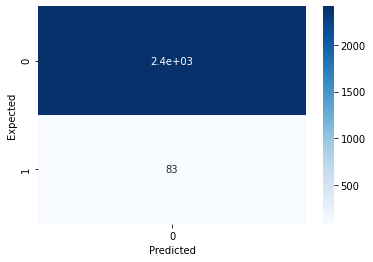

-----------------------------------------------------
2020-10-26 17:50:13.005635-03:00 [INFO] Metrics using class_mlp_unigram_bigram_7
2020-10-26 17:50:13.005777-03:00 [INFO] Accuracy = 0.9675350701402805
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.60      0.07      0.13        83

    accuracy                           0.97      2495
   macro avg       0.78      0.54      0.56      2495
weighted avg       0.96      0.97      0.96      2495



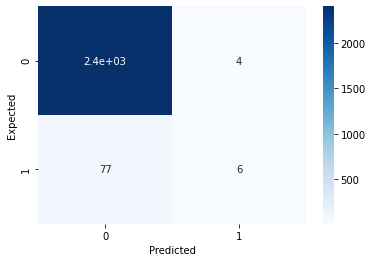

-----------------------------------------------------
2020-10-26 17:50:13.226112-03:00 [INFO] Metrics using class_mlp_tf_7
2020-10-26 17:50:13.226246-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


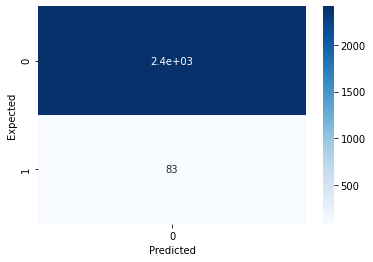

-----------------------------------------------------
2020-10-26 17:50:13.443667-03:00 [INFO] Metrics using class_mlp_tfidf_7
2020-10-26 17:50:13.443764-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


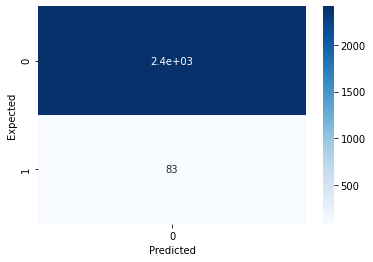

-----------------------------------------------------
2020-10-26 17:50:13.649731-03:00 [INFO] Metrics using class_mlp_unigram_8
2020-10-26 17:50:13.650032-03:00 [INFO] Accuracy = 0.9707414829659319
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2412
           1       0.61      0.33      0.43        83

    accuracy                           0.97      2495
   macro avg       0.80      0.66      0.71      2495
weighted avg       0.97      0.97      0.97      2495



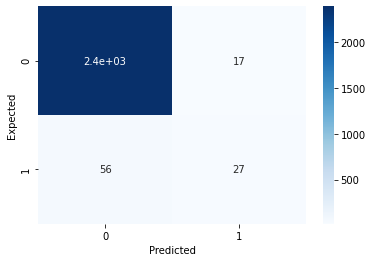

-----------------------------------------------------
2020-10-26 17:50:13.862206-03:00 [INFO] Metrics using class_mlp_bigram_8
2020-10-26 17:50:13.862315-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


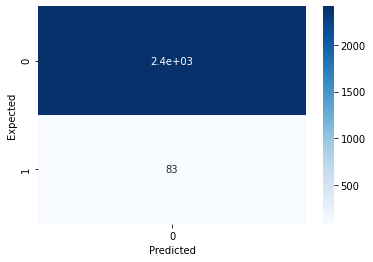

-----------------------------------------------------
2020-10-26 17:50:14.067390-03:00 [INFO] Metrics using class_mlp_unigram_bigram_8
2020-10-26 17:50:14.067486-03:00 [INFO] Accuracy = 0.9723446893787575
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2412
           1       0.72      0.28      0.40        83

    accuracy                           0.97      2495
   macro avg       0.85      0.64      0.69      2495
weighted avg       0.97      0.97      0.97      2495



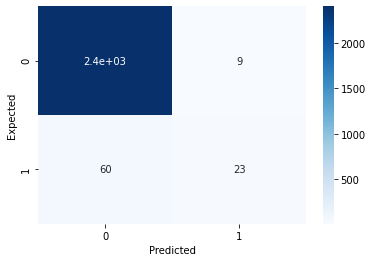

-----------------------------------------------------
2020-10-26 17:50:14.287121-03:00 [INFO] Metrics using class_mlp_tf_8
2020-10-26 17:50:14.287229-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


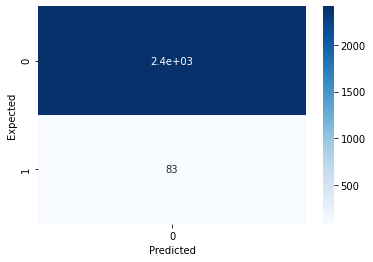

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------
2020-10-26 17:50:14.492149-03:00 [INFO] Metrics using class_mlp_tfidf_8
2020-10-26 17:50:14.492303-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



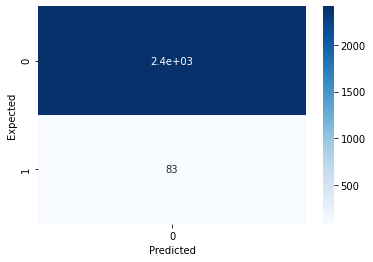

-----------------------------------------------------
2020-10-26 17:50:14.710018-03:00 [INFO] Metrics using class_mlp_unigram_9
2020-10-26 17:50:14.710356-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


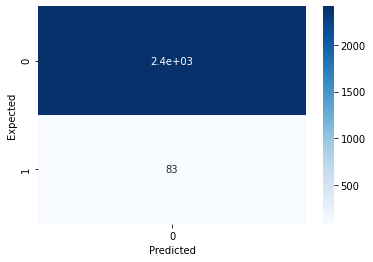

-----------------------------------------------------
2020-10-26 17:50:14.907421-03:00 [INFO] Metrics using class_mlp_bigram_9
2020-10-26 17:50:14.907521-03:00 [INFO] Accuracy = 0.9667334669338677


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



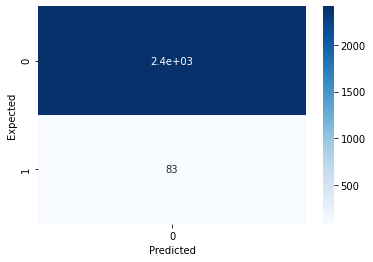

-----------------------------------------------------
2020-10-26 17:50:15.116778-03:00 [INFO] Metrics using class_mlp_unigram_bigram_9
2020-10-26 17:50:15.116886-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


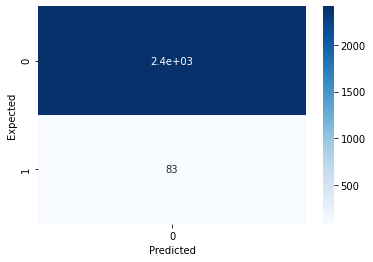

-----------------------------------------------------
2020-10-26 17:50:15.326010-03:00 [INFO] Metrics using class_mlp_tf_9
2020-10-26 17:50:15.326102-03:00 [INFO] Accuracy = 0.9667334669338677


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



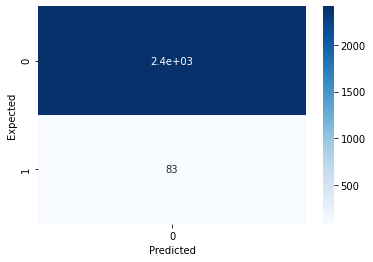

-----------------------------------------------------
2020-10-26 17:50:15.532481-03:00 [INFO] Metrics using class_mlp_tfidf_9
2020-10-26 17:50:15.532588-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


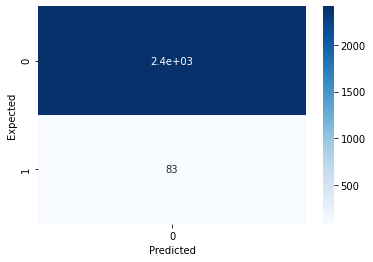

-----------------------------------------------------
2020-10-26 17:50:15.875401-03:00 [INFO] Metrics using class_mlp_unigram_10
2020-10-26 17:50:15.875493-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


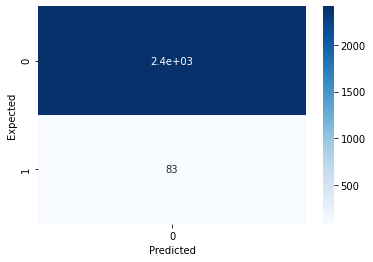

-----------------------------------------------------
2020-10-26 17:50:16.083349-03:00 [INFO] Metrics using class_mlp_bigram_10
2020-10-26 17:50:16.083658-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


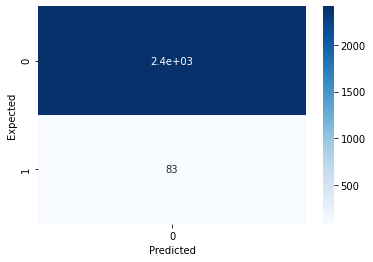

-----------------------------------------------------
2020-10-26 17:50:16.284677-03:00 [INFO] Metrics using class_mlp_unigram_bigram_10
2020-10-26 17:50:16.284786-03:00 [INFO] Accuracy = 0.9667334669338677


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



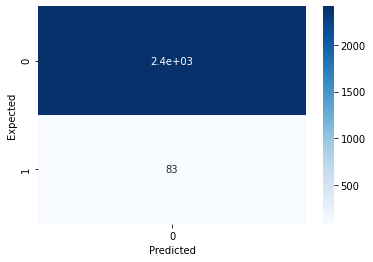

-----------------------------------------------------
2020-10-26 17:50:16.508286-03:00 [INFO] Metrics using class_mlp_tf_10
2020-10-26 17:50:16.508619-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


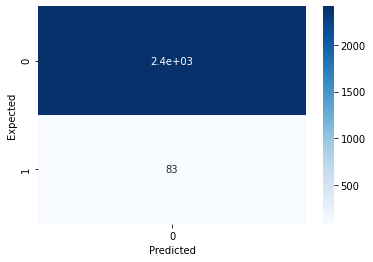

-----------------------------------------------------
2020-10-26 17:50:16.714645-03:00 [INFO] Metrics using class_mlp_tfidf_10
2020-10-26 17:50:16.714732-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


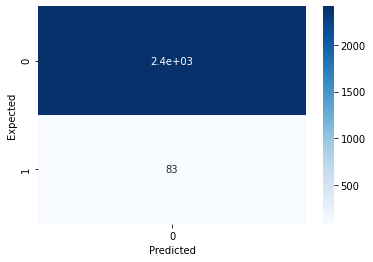

-----------------------------------------------------
2020-10-26 17:50:16.914778-03:00 [INFO] Metrics using class_mlp_unigram_11
2020-10-26 17:50:16.914882-03:00 [INFO] Accuracy = 0.9675350701402805
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.62      0.06      0.11        83

    accuracy                           0.97      2495
   macro avg       0.80      0.53      0.55      2495
weighted avg       0.96      0.97      0.95      2495



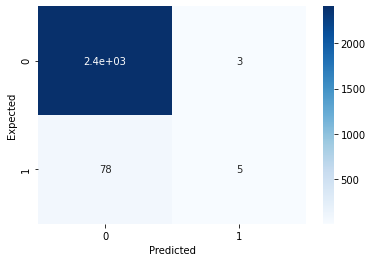

-----------------------------------------------------
2020-10-26 17:50:17.129919-03:00 [INFO] Metrics using class_mlp_bigram_11
2020-10-26 17:50:17.130225-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


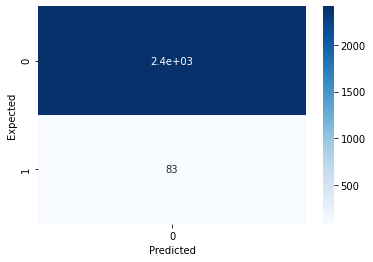

-----------------------------------------------------
2020-10-26 17:50:17.330989-03:00 [INFO] Metrics using class_mlp_unigram_bigram_11
2020-10-26 17:50:17.331097-03:00 [INFO] Accuracy = 0.9683366733466934
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.67      0.10      0.17        83

    accuracy                           0.97      2495
   macro avg       0.82      0.55      0.58      2495
weighted avg       0.96      0.97      0.96      2495



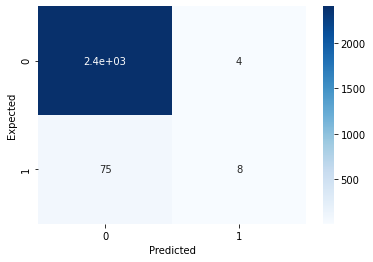

-----------------------------------------------------
2020-10-26 17:50:17.553065-03:00 [INFO] Metrics using class_mlp_tf_11
2020-10-26 17:50:17.553415-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


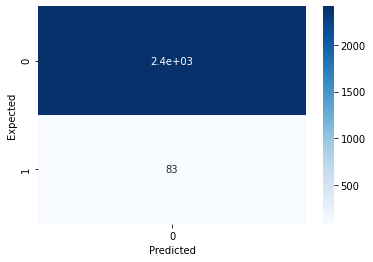

-----------------------------------------------------
2020-10-26 17:50:17.753399-03:00 [INFO] Metrics using class_mlp_tfidf_11
2020-10-26 17:50:17.753532-03:00 [INFO] Accuracy = 0.9667334669338677


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



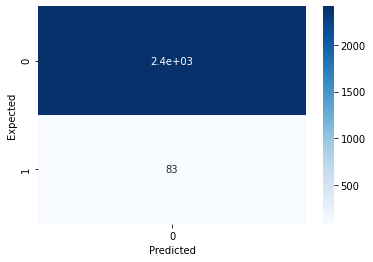

-----------------------------------------------------
2020-10-26 17:50:17.958922-03:00 [INFO] Metrics using class_mlp_unigram_12
2020-10-26 17:50:17.959049-03:00 [INFO] Accuracy = 0.9659318637274549
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2412
           1       0.48      0.33      0.39        83

    accuracy                           0.97      2495
   macro avg       0.73      0.66      0.69      2495
weighted avg       0.96      0.97      0.96      2495



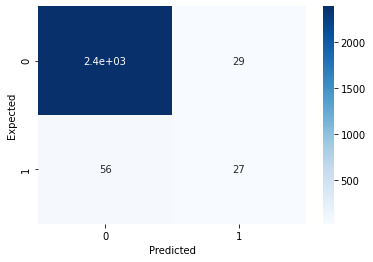

-----------------------------------------------------
2020-10-26 17:50:18.167262-03:00 [INFO] Metrics using class_mlp_bigram_12
2020-10-26 17:50:18.167386-03:00 [INFO] Accuracy = 0.969939879759519
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.72      0.16      0.26        83

    accuracy                           0.97      2495
   macro avg       0.85      0.58      0.62      2495
weighted avg       0.96      0.97      0.96      2495



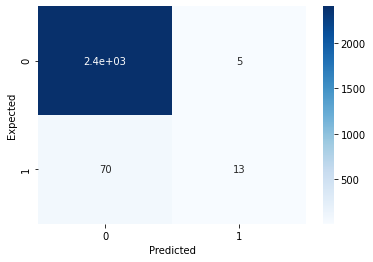

-----------------------------------------------------
2020-10-26 17:50:18.387448-03:00 [INFO] Metrics using class_mlp_unigram_bigram_12
2020-10-26 17:50:18.387537-03:00 [INFO] Accuracy = 0.9731462925851704
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2412
           1       0.75      0.29      0.42        83

    accuracy                           0.97      2495
   macro avg       0.86      0.64      0.70      2495
weighted avg       0.97      0.97      0.97      2495



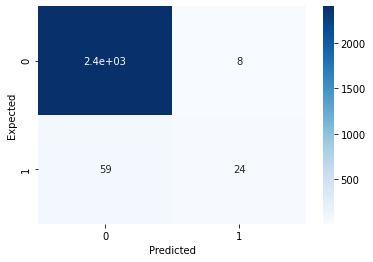

-----------------------------------------------------
2020-10-26 17:50:18.591978-03:00 [INFO] Metrics using class_mlp_tf_12
2020-10-26 17:50:18.592077-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


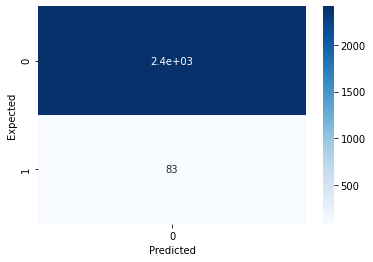

-----------------------------------------------------
2020-10-26 17:50:18.938097-03:00 [INFO] Metrics using class_mlp_tfidf_12
2020-10-26 17:50:18.938226-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


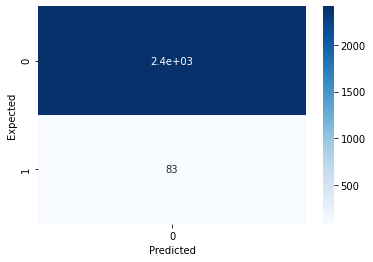

-----------------------------------------------------
2020-10-26 17:50:19.138856-03:00 [INFO] Metrics using class_nb_unigram_1
2020-10-26 17:50:19.138954-03:00 [INFO] Accuracy = 0.9595190380761524
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.15      0.05      0.07        83

    accuracy                           0.96      2495
   macro avg       0.56      0.52      0.53      2495
weighted avg       0.94      0.96      0.95      2495



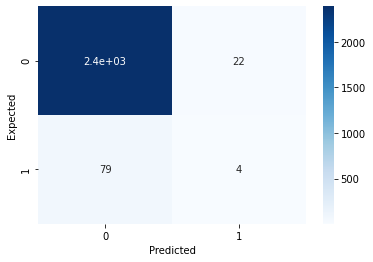

-----------------------------------------------------
2020-10-26 17:50:19.357078-03:00 [INFO] Metrics using class_nb_bigram_1
2020-10-26 17:50:19.357195-03:00 [INFO] Accuracy = 0.8076152304609219
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      2412
           1       0.05      0.29      0.09        83

    accuracy                           0.81      2495
   macro avg       0.51      0.56      0.49      2495
weighted avg       0.94      0.81      0.87      2495



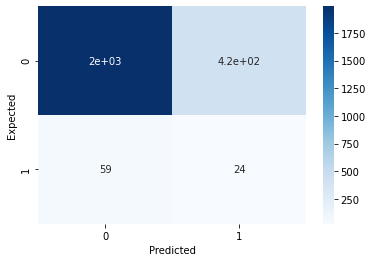

-----------------------------------------------------
2020-10-26 17:50:19.582880-03:00 [INFO] Metrics using class_nb_unigram_bigram_1
2020-10-26 17:50:19.582970-03:00 [INFO] Accuracy = 0.9567134268537074
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.07      0.02      0.04        83

    accuracy                           0.96      2495
   macro avg       0.52      0.51      0.51      2495
weighted avg       0.94      0.96      0.95      2495



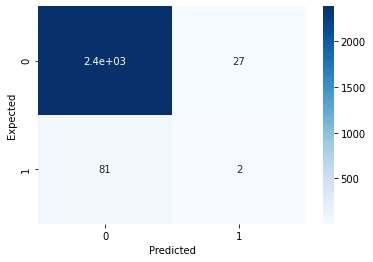

-----------------------------------------------------
2020-10-26 17:50:19.790912-03:00 [INFO] Metrics using class_nb_tf_1
2020-10-26 17:50:19.791014-03:00 [INFO] Accuracy = 0.9667334669338677
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


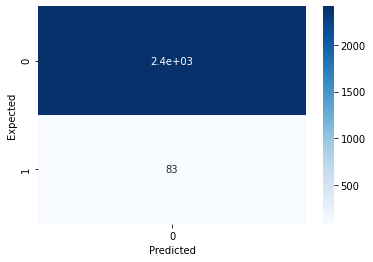

-----------------------------------------------------
2020-10-26 17:50:19.991101-03:00 [INFO] Metrics using class_nb_tfidf_1
2020-10-26 17:50:19.991225-03:00 [INFO] Accuracy = 0.9667334669338677


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.00      0.00      0.00        83

    accuracy                           0.97      2495
   macro avg       0.48      0.50      0.49      2495
weighted avg       0.93      0.97      0.95      2495



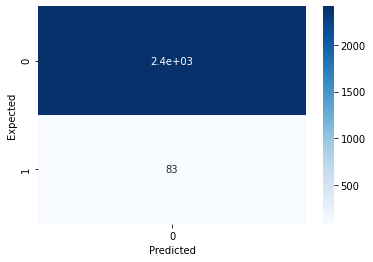

-----------------------------------------------------
2020-10-26 17:50:20.199829-03:00 [INFO] Metrics using class_svc_unigram_1
2020-10-26 17:50:20.199933-03:00 [INFO] Accuracy = 0.9643286573146292
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2412
           1       0.44      0.28      0.34        83

    accuracy                           0.96      2495
   macro avg       0.71      0.63      0.66      2495
weighted avg       0.96      0.96      0.96      2495



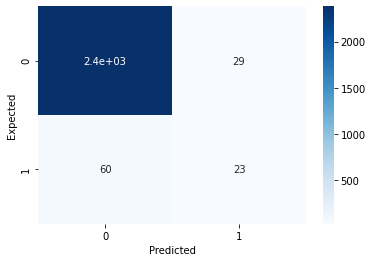

-----------------------------------------------------
2020-10-26 17:50:20.418306-03:00 [INFO] Metrics using class_svc_bigram_1
2020-10-26 17:50:20.418391-03:00 [INFO] Accuracy = 0.9691382765531062
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.64      0.17      0.27        83

    accuracy                           0.97      2495
   macro avg       0.80      0.58      0.63      2495
weighted avg       0.96      0.97      0.96      2495



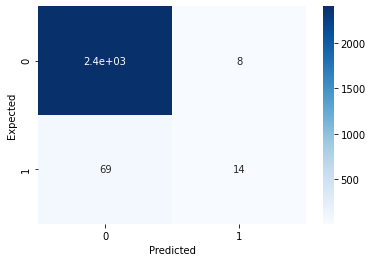

-----------------------------------------------------
2020-10-26 17:50:20.628751-03:00 [INFO] Metrics using class_svc_unigram_bigram_1
2020-10-26 17:50:20.629061-03:00 [INFO] Accuracy = 0.9687374749498998
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2412
           1       0.57      0.25      0.35        83

    accuracy                           0.97      2495
   macro avg       0.77      0.62      0.67      2495
weighted avg       0.96      0.97      0.96      2495



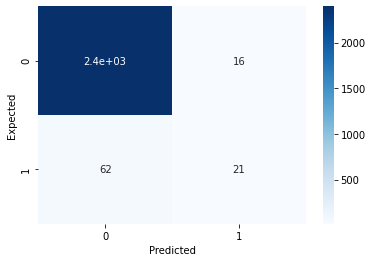

-----------------------------------------------------
2020-10-26 17:50:20.850076-03:00 [INFO] Metrics using class_svc_tf_1
2020-10-26 17:50:20.850220-03:00 [INFO] Accuracy = 0.9671342685370742
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.53      0.12      0.20        83

    accuracy                           0.97      2495
   macro avg       0.75      0.56      0.59      2495
weighted avg       0.96      0.97      0.96      2495



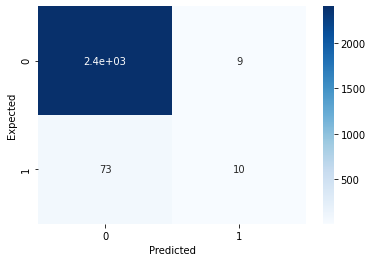

-----------------------------------------------------
2020-10-26 17:50:21.054525-03:00 [INFO] Metrics using class_svc_tfidf_1
2020-10-26 17:50:21.054641-03:00 [INFO] Accuracy = 0.9671342685370742
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2412
           1       0.53      0.12      0.20        83

    accuracy                           0.97      2495
   macro avg       0.75      0.56      0.59      2495
weighted avg       0.96      0.97      0.96      2495



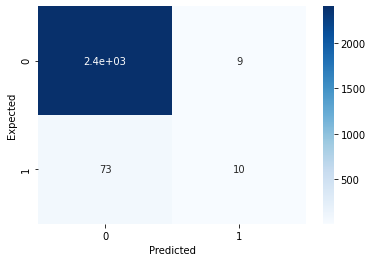

-----------------------------------------------------


In [ ]:
for column in df_predict_results[model_columns_result]:
  get_report(column, y_test, df_predict_results[column])
  print("-----------------------------------------------------")

In [ ]:
y_pred = pd.DataFrame()
y_pred = df_predict_results[model_columns_result].mode(axis=1)
y_pred.value_counts()

0    2481
1      14
dtype: int64

**Working with disbalanced classes**

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [ ]:
nm = NearMiss()

In [ ]:
X, y = nm.fit_sample(X_train_vectorized_unigram, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


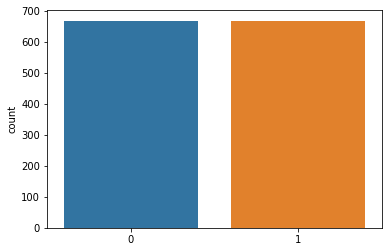

In [ ]:
ax = sns.countplot(x=y)

####**4.1.1 - Multilayer Perceptron - Model 1**

- Hidden layers = 1
- Neurons = 100
- Learning rate = 0.01
- Max iteration = 200
- Solver = ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
- Activation = ‘relu’, the rectified linear unit function, returns f(x) = max(0, x)

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-11-01 14:28:03.900560-02:00 [INFO] starting training...
Iteration 1, loss = 0.67859477
Iteration 2, loss = 0.61529468
Iteration 3, loss = 0.55166283
Iteration 4, loss = 0.48884991
Iteration 5, loss = 0.43174856
Iteration 6, loss = 0.38006049
Iteration 7, loss = 0.33391252
Iteration 8, loss = 0.29274988
Iteration 9, loss = 0.25718307
Iteration 10, loss = 0.22647467
Iteration 11, loss = 0.20071468
Iteration 12, loss = 0.17881868
Iteration 13, loss = 0.16055282
Iteration 14, loss = 0.14516370
Iteration 15, loss = 0.13216198
Iteration 16, loss = 0.12094551
Iteration 17, loss = 0.11142730
Iteration 18, loss = 0.10325517
Iteration 19, loss = 0.09594718
Iteration 20, loss = 0.08960313
Iteration 21, loss = 0.08395597
Iteration 22, loss = 0.07897348
Iteration 23, loss = 0.07439997
Iteration 24, loss = 0.07024139
Iteration 25, loss = 0.06651494
Iteration 26, loss = 0.06319226
Iteration 27, loss = 0.06004755
Iteration 28, loss = 0.05722262
Iteration 29, loss = 0.05464118
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_vectorized_unigram)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-11-01 14:30:21.339128-02:00 [INFO] starting predict...
2020-11-01 14:30:21.357759-02:00 [INFO] predict successful...


2020-10-26 18:25:12.907259-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-26 18:25:12.907366-03:00 [INFO] Accuracy = 0.5266533066132264
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      2412
           1       0.06      0.86      0.11        83

    accuracy                           0.53      2495
   macro avg       0.52      0.69      0.39      2495
weighted avg       0.96      0.53      0.66      2495



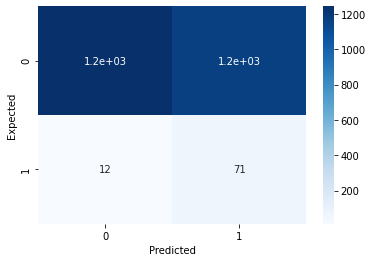

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
smt = SMOTE()

In [ ]:
X, y = smt.fit_sample(X_train_vectorized_unigram, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


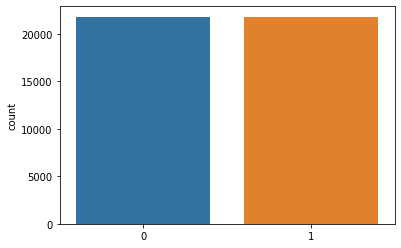

In [ ]:
ax = sns.countplot(x=y)

In [ ]:
mlp_unigram_smt = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_smt.fit(X, y)
print('{} [INFO] finish mlp_unigram_smt...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-29 20:54:42.301669-03:00 [INFO] starting training...
Iteration 1, loss = 0.30934696
Iteration 2, loss = 0.14318613
Iteration 3, loss = 0.10193158
Iteration 4, loss = 0.07856542
Iteration 5, loss = 0.06463943
Iteration 6, loss = 0.05573098
Iteration 7, loss = 0.05012212
Iteration 8, loss = 0.04610049
Iteration 9, loss = 0.04294285
Iteration 10, loss = 0.04038777
Iteration 11, loss = 0.03865501
Iteration 12, loss = 0.03729974
Iteration 13, loss = 0.03585253
Iteration 14, loss = 0.03474287
Iteration 15, loss = 0.03399253
Iteration 16, loss = 0.03328237
Iteration 17, loss = 0.03228293
Iteration 18, loss = 0.03164632
Iteration 19, loss = 0.03114765
Iteration 20, loss = 0.03059922
Iteration 21, loss = 0.03014565
Iteration 22, loss = 0.02977622
Iteration 23, loss = 0.02906528
Iteration 24, loss = 0.02918634
Iteration 25, loss = 0.02841863
Iteration 26, loss = 0.02812327
Iteration 27, loss = 0.02805547
Iteration 28, loss = 0.02752834
Iteration 29, loss = 0.02714743
Iteration 30, loss =

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram_smt.predict(X_test_vectorized_unigram)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-26 19:09:10.185477-03:00 [INFO] starting predict...
2020-10-26 19:09:10.199271-03:00 [INFO] predict successful...


2020-10-26 19:09:10.209246-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-26 19:09:10.211000-03:00 [INFO] Accuracy = 0.9222444889779559
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2412
           1       0.16      0.31      0.21        83

    accuracy                           0.92      2495
   macro avg       0.57      0.63      0.59      2495
weighted avg       0.95      0.92      0.93      2495



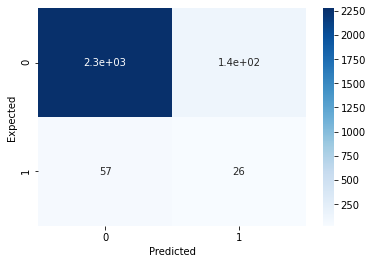

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
X, y = nm.fit_sample(X_train_vectorized_bigram, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_bigram = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_bigram.fit(X, y)
print('{} [INFO] finish mlp_bigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 13:04:50.129454-03:00 [INFO] starting training...
Iteration 1, loss = 0.68915596
Iteration 2, loss = 0.65504691
Iteration 3, loss = 0.61793017
Iteration 4, loss = 0.57518032
Iteration 5, loss = 0.52967033
Iteration 6, loss = 0.48302048
Iteration 7, loss = 0.43812445
Iteration 8, loss = 0.39556863
Iteration 9, loss = 0.35614486
Iteration 10, loss = 0.31943075
Iteration 11, loss = 0.28528574
Iteration 12, loss = 0.25432333
Iteration 13, loss = 0.22581035
Iteration 14, loss = 0.20028452
Iteration 15, loss = 0.17794094
Iteration 16, loss = 0.15809439
Iteration 17, loss = 0.14104316
Iteration 18, loss = 0.12590983
Iteration 19, loss = 0.11303654
Iteration 20, loss = 0.10183542
Iteration 21, loss = 0.09223516
Iteration 22, loss = 0.08385446
Iteration 23, loss = 0.07652028
Iteration 24, loss = 0.07012673
Iteration 25, loss = 0.06461177
Iteration 26, loss = 0.05969630
Iteration 27, loss = 0.05519639
Iteration 28, loss = 0.05135878
Iteration 29, loss = 0.04784275
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_bigram_1 = mlp_bigram.predict(X_test_vectorized_bigram)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-26 19:24:05.575745-03:00 [INFO] starting predict...
2020-10-26 19:24:05.586319-03:00 [INFO] predict successful...


2020-10-26 19:24:08.167373-03:00 [INFO] Metrics using mlp_bigram_1
2020-10-26 19:24:08.170767-03:00 [INFO] Accuracy = 0.9142284569138277
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2412
           1       0.15      0.34      0.21        83

    accuracy                           0.91      2495
   macro avg       0.56      0.64      0.58      2495
weighted avg       0.95      0.91      0.93      2495



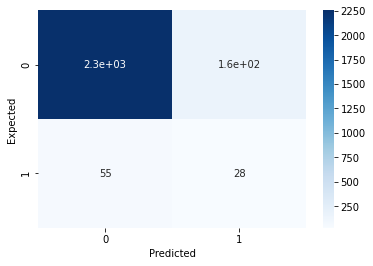

In [ ]:
get_report('mlp_bigram_1', y_test, y_pred_mlp_bigram_1)

In [ ]:
X, y = nm.fit_sample(X_train_vectorized_unigram_bigram, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram_bigram = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram_bigram.fit(X, y)
print('{} [INFO] finish mlp_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 13:08:49.575474-03:00 [INFO] starting training...
Iteration 1, loss = 0.66522488
Iteration 2, loss = 0.55494304
Iteration 3, loss = 0.46181270
Iteration 4, loss = 0.38916722
Iteration 5, loss = 0.33006947
Iteration 6, loss = 0.28007277
Iteration 7, loss = 0.23716097
Iteration 8, loss = 0.20094078
Iteration 9, loss = 0.17055905
Iteration 10, loss = 0.14493485
Iteration 11, loss = 0.12425712
Iteration 12, loss = 0.10685180
Iteration 13, loss = 0.09265306
Iteration 14, loss = 0.08116514
Iteration 15, loss = 0.07176598
Iteration 16, loss = 0.06388527
Iteration 17, loss = 0.05735536
Iteration 18, loss = 0.05182420
Iteration 19, loss = 0.04701800
Iteration 20, loss = 0.04301636
Iteration 21, loss = 0.03938727
Iteration 22, loss = 0.03631041
Iteration 23, loss = 0.03361293
Iteration 24, loss = 0.03120658
Iteration 25, loss = 0.02898878
Iteration 26, loss = 0.02710332
Iteration 27, loss = 0.02535480
Iteration 28, loss = 0.02376529
Iteration 29, loss = 0.02228075
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_bigram_1 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-26 19:34:35.096359-03:00 [INFO] starting predict...
2020-10-26 19:34:35.117086-03:00 [INFO] predict successful...


2020-10-26 19:34:35.125470-03:00 [INFO] Metrics using mlp_unigram_bigram_1
2020-10-26 19:34:35.126244-03:00 [INFO] Accuracy = 0.6613226452905812
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      2412
           1       0.07      0.73      0.13        83

    accuracy                           0.66      2495
   macro avg       0.53      0.70      0.46      2495
weighted avg       0.96      0.66      0.77      2495



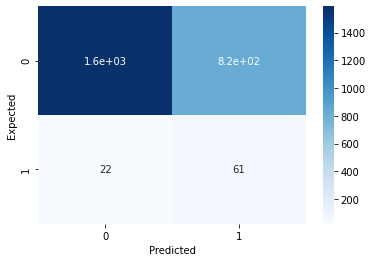

In [ ]:
get_report('mlp_unigram_bigram_1', y_test, y_pred_mlp_unigram_bigram_1)

In [ ]:
X, y = nm.fit_sample(X_train_tf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_tf = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_tf.fit(X, y)
print('{} [INFO] finish mlp_tf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 13:12:56.380904-03:00 [INFO] starting training...
Iteration 1, loss = 0.69167484
Iteration 2, loss = 0.68159020
Iteration 3, loss = 0.67033913
Iteration 4, loss = 0.65759244
Iteration 5, loss = 0.64337843
Iteration 6, loss = 0.62775503
Iteration 7, loss = 0.61091765
Iteration 8, loss = 0.59276966
Iteration 9, loss = 0.57334206
Iteration 10, loss = 0.55339853
Iteration 11, loss = 0.53212688
Iteration 12, loss = 0.51068963
Iteration 13, loss = 0.48870074
Iteration 14, loss = 0.46670212
Iteration 15, loss = 0.44447838
Iteration 16, loss = 0.42242020
Iteration 17, loss = 0.40105774
Iteration 18, loss = 0.38000273
Iteration 19, loss = 0.35975404
Iteration 20, loss = 0.34023988
Iteration 21, loss = 0.32155558
Iteration 22, loss = 0.30373375
Iteration 23, loss = 0.28688725
Iteration 24, loss = 0.27100784
Iteration 25, loss = 0.25597491
Iteration 26, loss = 0.24200667
Iteration 27, loss = 0.22876947
Iteration 28, loss = 0.21644554
Iteration 29, loss = 0.20491481
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_tf_1 = mlp_tf.predict(X_test_tf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-26 19:41:14.687671-03:00 [INFO] starting predict...
2020-10-26 19:41:14.701436-03:00 [INFO] predict successful...


2020-10-26 19:41:14.716916-03:00 [INFO] Metrics using mlp_tf_1
2020-10-26 19:41:14.717503-03:00 [INFO] Accuracy = 0.7062124248496994
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      2412
           1       0.08      0.78      0.15        83

    accuracy                           0.71      2495
   macro avg       0.54      0.74      0.49      2495
weighted avg       0.96      0.71      0.80      2495



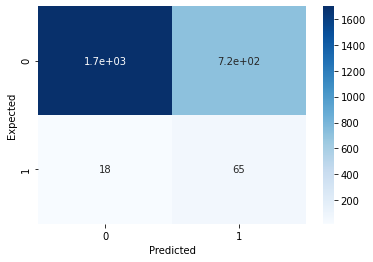

In [ ]:
get_report('mlp_tf_1', y_test, y_pred_mlp_tf_1)

In [ ]:
X, y = nm.fit_sample(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_tfidf = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_tfidf.fit(X, y)
print('{} [INFO] finish mlp_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-30 16:42:11.979833-03:00 [INFO] starting training...
Iteration 1, loss = 0.69167484
Iteration 2, loss = 0.68159020
Iteration 3, loss = 0.67033913
Iteration 4, loss = 0.65759244
Iteration 5, loss = 0.64337843
Iteration 6, loss = 0.62775503
Iteration 7, loss = 0.61091765
Iteration 8, loss = 0.59276966
Iteration 9, loss = 0.57334206
Iteration 10, loss = 0.55339853
Iteration 11, loss = 0.53212688
Iteration 12, loss = 0.51068963
Iteration 13, loss = 0.48870074
Iteration 14, loss = 0.46670212
Iteration 15, loss = 0.44447838
Iteration 16, loss = 0.42242020
Iteration 17, loss = 0.40105774
Iteration 18, loss = 0.38000273
Iteration 19, loss = 0.35975404
Iteration 20, loss = 0.34023988
Iteration 21, loss = 0.32155558
Iteration 22, loss = 0.30373375
Iteration 23, loss = 0.28688725
Iteration 24, loss = 0.27100784
Iteration 25, loss = 0.25597491
Iteration 26, loss = 0.24200667
Iteration 27, loss = 0.22876947
Iteration 28, loss = 0.21644554
Iteration 29, loss = 0.20491481
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_tfidf_1 = mlp_tfidf.predict(X_test_tfidf)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-26 19:57:10.123282-03:00 [INFO] starting predict...
2020-10-26 19:57:10.141756-03:00 [INFO] predict successful...


2020-10-26 19:57:14.230055-03:00 [INFO] Metrics using mlp_tfidf_1
2020-10-26 19:57:14.230256-03:00 [INFO] Accuracy = 0.7062124248496994
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      2412
           1       0.08      0.78      0.15        83

    accuracy                           0.71      2495
   macro avg       0.54      0.74      0.49      2495
weighted avg       0.96      0.71      0.80      2495



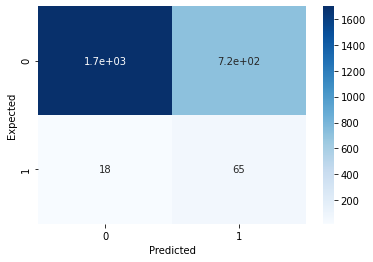

In [ ]:
get_report('mlp_tfidf_1', y_test, y_pred_mlp_tfidf_1)

**Test**

In [ ]:
test = [
        (unidecode('Amanhã vou pro rolê com as amigas!!!')),
        (unidecode('Estou indo no mercado')),
        (unidecode('Alguém que ir comigo na festa semana que vem?')),
        (unidecode('Tô na festa da Júlia e tá muito top!!!! Vem pra ca amiga')),
        (unidecode('Daqui a pouco vou no hospital fazer exame de sangue')),
        (unidecode('n estou saindo de casa pra nada')),
        (unidecode('n estou saindo de casa')),
        (unidecode('150 dias sem sair de casa. Quarentena tá me deixando loucooooo!!! :/'))
       ]

new_test = pd.DataFrame(test, columns=['text'])
new_test = preprocessing(new_test['text'])
new_test

0                           amanha vou pro role amigas
1                                   estou indo mercado
2                    alguem ir comigo festa semana vem
3               to festa julia ta top vem pra ca amiga
4          daqui pouco vou hospital fazer exame sangue
5                       nao estou saindo casa pra nada
6                                nao estou saindo casa
7        dias sem sair casa quarentena ta deixando ...
dtype: object

In [ ]:
vect_transform = vectorizer.transform(new_test)
predict_test = mlp_unigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
vect_transform = vectorizer.transform(new_test)
predict_test = mlp_unigram_smt.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      0
4        daqui pouco vou hospital fazer exame sangue      0
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      0
7      dias sem sair casa quarentena ta deixando ...      0

In [ ]:
vect_transform = vectorizer_bigram.transform(new_test)
predict_test = mlp_bigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      0
3             to festa julia ta top vem pra ca amiga      0
4        daqui pouco vou hospital fazer exame sangue      0
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      0
7      dias sem sair casa quarentena ta deixando ...      0

In [ ]:
vect_transform = vectorizer_unigram_bigram.transform(new_test)
predict_test = mlp_unigram_bigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
vect_transform = vectorizer.transform(new_test)
tf_transform = tf.transform(X_train_vectorized_unigram)
predict_test = mlp_tf.predict(tf_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      0
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      0
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      0

In [ ]:
vect_transform = vectorizer.transform(new_test)
tfidf_transform = tfidf.transform(X_train_vectorized_unigram)
predict_test = mlp_tfidf.predict(tfidf_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      0
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      0
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      0

**Tag de negação**

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text))
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram_neg = new_pipeline(MLPClassifier(verbose=10, random_state=42, max_iter=1000))

In [ ]:
mlp_unigram_neg.fit(X, y)

Iteration 1, loss = 0.56420053
Iteration 2, loss = 0.49111639
Iteration 3, loss = 0.44238564
Iteration 4, loss = 0.40053774
Iteration 5, loss = 0.36793896
Iteration 6, loss = 0.33726540
Iteration 7, loss = 0.31006345
Iteration 8, loss = 0.28533933
Iteration 9, loss = 0.26531931
Iteration 10, loss = 0.24656696
Iteration 11, loss = 0.23044069
Iteration 12, loss = 0.21698652
Iteration 13, loss = 0.20616245
Iteration 14, loss = 0.19726251
Iteration 15, loss = 0.18990732
Iteration 16, loss = 0.18386651
Iteration 17, loss = 0.17845884
Iteration 18, loss = 0.17413661
Iteration 19, loss = 0.17011986
Iteration 20, loss = 0.16689355
Iteration 21, loss = 0.16407629
Iteration 22, loss = 0.16157221
Iteration 23, loss = 0.15897819
Iteration 24, loss = 0.15743006
Iteration 25, loss = 0.15483502
Iteration 26, loss = 0.15398212
Iteration 27, loss = 0.15131160
Iteration 28, loss = 0.14995110
Iteration 29, loss = 0.14809565
Iteration 30, loss = 0.14683418
Iteration 31, loss = 0.14527564
Iteration 32, los

Pipeline(memory=None,
         steps=[('model',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1, verbose=10,
                               warm_start=False))],
         verbose=False)

In [ ]:
X_test_unigram_neg = negative_vectorizer.transform(X_test)

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_neg_1 = mlp_unigram_neg.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 12:07:52.457201-03:00 [INFO] starting predict...
2020-10-31 12:07:52.466375-03:00 [INFO] predict successful...


2020-10-31 12:07:52.478092-03:00 [INFO] Metrics using mlp_unigram_neg_1
2020-10-31 12:07:52.479980-03:00 [INFO] Accuracy = 0.1627254509018036
              precision    recall  f1-score   support

           0       0.99      0.13      0.24      2412
           1       0.04      0.98      0.07        83

    accuracy                           0.16      2495
   macro avg       0.52      0.56      0.15      2495
weighted avg       0.96      0.16      0.23      2495



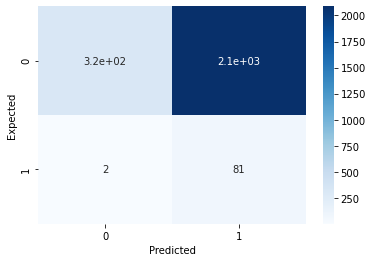

In [ ]:
get_report('mlp_unigram_neg_1', y_test, y_pred_mlp_unigram_neg_1)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = mlp_unigram_neg.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      0
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text), ngram_range=(2,2))
negative_vectorizer.fit_transform(tweets)
X_train_bigram_neg = negative_vectorizer.transform(X_train)
X, y = nm.fit_sample(X_train_bigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_bigram_neg = new_pipeline(MLPClassifier(verbose=10, random_state=42, max_iter=1000))

In [ ]:
mlp_bigram_neg.fit(X, y)

Iteration 1, loss = 0.58294520
Iteration 2, loss = 0.48247021
Iteration 3, loss = 0.41612464
Iteration 4, loss = 0.35737219
Iteration 5, loss = 0.30798958
Iteration 6, loss = 0.26415898
Iteration 7, loss = 0.22759738
Iteration 8, loss = 0.19761162
Iteration 9, loss = 0.17259699
Iteration 10, loss = 0.15237403
Iteration 11, loss = 0.13588967
Iteration 12, loss = 0.12282771
Iteration 13, loss = 0.11131303
Iteration 14, loss = 0.10210002
Iteration 15, loss = 0.09418296
Iteration 16, loss = 0.08763257
Iteration 17, loss = 0.08166247
Iteration 18, loss = 0.07662313
Iteration 19, loss = 0.07238262
Iteration 20, loss = 0.06823270
Iteration 21, loss = 0.06470704
Iteration 22, loss = 0.06156909
Iteration 23, loss = 0.05872856
Iteration 24, loss = 0.05600497
Iteration 25, loss = 0.05362733
Iteration 26, loss = 0.05132694
Iteration 27, loss = 0.04917285
Iteration 28, loss = 0.04729002
Iteration 29, loss = 0.04551984
Iteration 30, loss = 0.04383674
Iteration 31, loss = 0.04230434
Iteration 32, los

Pipeline(memory=None,
         steps=[('model',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1, verbose=10,
                               warm_start=False))],
         verbose=False)

In [ ]:
X_test_bigram_neg = negative_vectorizer.transform(X_test)

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_bigram_neg_1 = mlp_bigram_neg.predict(X_test_bigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 12:08:01.659912-03:00 [INFO] starting predict...
2020-10-31 12:08:01.676888-03:00 [INFO] predict successful...


2020-10-31 12:08:01.694237-03:00 [INFO] Metrics using mlp_bigram_neg_1
2020-10-31 12:08:01.695261-03:00 [INFO] Accuracy = 0.17715430861723447
              precision    recall  f1-score   support

           0       0.99      0.15      0.26      2412
           1       0.04      0.98      0.07        83

    accuracy                           0.18      2495
   macro avg       0.52      0.56      0.17      2495
weighted avg       0.96      0.18      0.25      2495



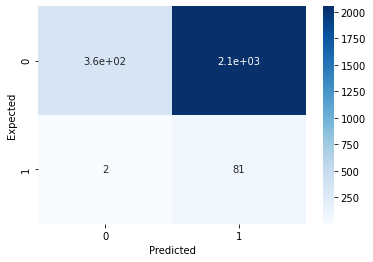

In [ ]:
get_report('mlp_bigram_neg_1', y_test, y_pred_mlp_bigram_neg_1)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = mlp_bigram_neg.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text), ngram_range=(1,2))
negative_vectorizer.fit_transform(tweets)
X_train_unigram_bigram_neg = negative_vectorizer.transform(X_train)
X, y = nm.fit_sample(X_train_unigram_bigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram_bigram_neg = new_pipeline(MLPClassifier(verbose=10, random_state=42, max_iter=1000))

In [ ]:
mlp_unigram_bigram_neg.fit(X, y)

Iteration 1, loss = 0.50033367
Iteration 2, loss = 0.40084419
Iteration 3, loss = 0.32141169
Iteration 4, loss = 0.25904545
Iteration 5, loss = 0.21323556
Iteration 6, loss = 0.17942364
Iteration 7, loss = 0.15660045
Iteration 8, loss = 0.13844225
Iteration 9, loss = 0.12425926
Iteration 10, loss = 0.11292456
Iteration 11, loss = 0.10373187
Iteration 12, loss = 0.09589073
Iteration 13, loss = 0.08942759
Iteration 14, loss = 0.08356612
Iteration 15, loss = 0.07830697
Iteration 16, loss = 0.07379911
Iteration 17, loss = 0.06987492
Iteration 18, loss = 0.06627190
Iteration 19, loss = 0.06301795
Iteration 20, loss = 0.05984515
Iteration 21, loss = 0.05701317
Iteration 22, loss = 0.05441426
Iteration 23, loss = 0.05198626
Iteration 24, loss = 0.05002184
Iteration 25, loss = 0.04779986
Iteration 26, loss = 0.04585505
Iteration 27, loss = 0.04431830
Iteration 28, loss = 0.04226434
Iteration 29, loss = 0.04075229
Iteration 30, loss = 0.03916612
Iteration 31, loss = 0.03789510
Iteration 32, los

Pipeline(memory=None,
         steps=[('model',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1, verbose=10,
                               warm_start=False))],
         verbose=False)

In [ ]:
X_test_unigram_bigram_neg = negative_vectorizer.transform(X_test)

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_bigram_neg_1 = mlp_unigram_bigram_neg.predict(X_test_unigram_bigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 12:08:13.264666-03:00 [INFO] starting predict...
2020-10-31 12:08:13.282073-03:00 [INFO] predict successful...


2020-10-31 12:08:13.300289-03:00 [INFO] Metrics using mlp_unigram_bigram_neg_1
2020-10-31 12:08:13.300390-03:00 [INFO] Accuracy = 0.17755511022044088
              precision    recall  f1-score   support

           0       1.00      0.15      0.26      2412
           1       0.04      1.00      0.07        83

    accuracy                           0.18      2495
   macro avg       0.52      0.57      0.17      2495
weighted avg       0.97      0.18      0.25      2495



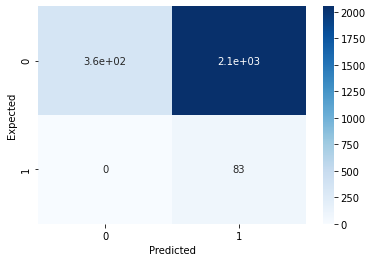

In [ ]:
get_report('mlp_unigram_bigram_neg_1', y_test, y_pred_mlp_unigram_bigram_neg_1)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = mlp_unigram_bigram_neg.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text))
vect_all_neg = negative_vectorizer.fit_transform(tweets)
X_train_neg = negative_vectorizer.transform(X_train)
tf = TfidfTransformer(use_idf=False)
tf.fit(vect_all_neg)
X_train_tf_neg = tf.transform(X_train_neg)
X, y = nm.fit_sample(X_train_tf_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_tf_neg = new_pipeline(MLPClassifier(verbose=10, random_state=42, max_iter=1000))

In [ ]:
mlp_tf_neg.fit(X, y)

Iteration 1, loss = 0.67019289
Iteration 2, loss = 0.65225170
Iteration 3, loss = 0.63507313
Iteration 4, loss = 0.61752198
Iteration 5, loss = 0.59998071
Iteration 6, loss = 0.58203570
Iteration 7, loss = 0.56343141
Iteration 8, loss = 0.54454523
Iteration 9, loss = 0.52511822
Iteration 10, loss = 0.50492506
Iteration 11, loss = 0.48410232
Iteration 12, loss = 0.46417529
Iteration 13, loss = 0.44595990
Iteration 14, loss = 0.42713683
Iteration 15, loss = 0.41056841
Iteration 16, loss = 0.39483911
Iteration 17, loss = 0.38055214
Iteration 18, loss = 0.36805827
Iteration 19, loss = 0.35612384
Iteration 20, loss = 0.34595492
Iteration 21, loss = 0.33656272
Iteration 22, loss = 0.32887971
Iteration 23, loss = 0.32183255
Iteration 24, loss = 0.31555314
Iteration 25, loss = 0.31025650
Iteration 26, loss = 0.30533816
Iteration 27, loss = 0.30114670
Iteration 28, loss = 0.29741788
Iteration 29, loss = 0.29405170
Iteration 30, loss = 0.29113072
Iteration 31, loss = 0.28847847
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('model',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1, verbose=10,
                               warm_start=False))],
         verbose=False)

In [ ]:
X_test_vectorizer_neg = negative_vectorizer.transform(X_test)
X_test_tf_neg = tf.transform(X_test_vectorizer_neg)

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_tf_neg_1 = mlp_tf_neg.predict(X_test_tf_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 12:08:36.868435-03:00 [INFO] starting predict...
2020-10-31 12:08:36.885569-03:00 [INFO] predict successful...


2020-10-31 12:08:36.891800-03:00 [INFO] Metrics using mlp_tf_neg_1
2020-10-31 12:08:36.891937-03:00 [INFO] Accuracy = 0.21362725450901804
              precision    recall  f1-score   support

           0       0.99      0.19      0.32      2412
           1       0.04      0.93      0.07        83

    accuracy                           0.21      2495
   macro avg       0.51      0.56      0.20      2495
weighted avg       0.96      0.21      0.31      2495



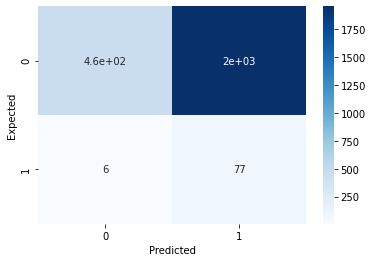

In [ ]:
get_report('mlp_tf_neg_1', y_test, y_pred_mlp_tf_neg_1)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = mlp_tf_neg.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      0
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text))
vect_all_neg = negative_vectorizer.fit_transform(tweets)
X_train_neg = negative_vectorizer.transform(X_train)
tfidf = TfidfTransformer(use_idf=True)
tfidf.fit(vect_all_neg)
X_train_tfidf_neg = tfidf.transform(X_train_neg)
X, y = nm.fit_sample(X_train_tfidf_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_tfidf_neg = new_pipeline(MLPClassifier(verbose=10, random_state=42, max_iter=1000))

In [ ]:
mlp_tfidf_neg.fit(X, y)

Iteration 1, loss = 0.66774573
Iteration 2, loss = 0.64743399
Iteration 3, loss = 0.62822771
Iteration 4, loss = 0.60904949
Iteration 5, loss = 0.58956501
Iteration 6, loss = 0.56941098
Iteration 7, loss = 0.54806968
Iteration 8, loss = 0.52505663
Iteration 9, loss = 0.50209985
Iteration 10, loss = 0.47973767
Iteration 11, loss = 0.45762865
Iteration 12, loss = 0.43658487
Iteration 13, loss = 0.41761249
Iteration 14, loss = 0.39854155
Iteration 15, loss = 0.38225750
Iteration 16, loss = 0.36720659
Iteration 17, loss = 0.35393236
Iteration 18, loss = 0.34269852
Iteration 19, loss = 0.33217082
Iteration 20, loss = 0.32349822
Iteration 21, loss = 0.31559793
Iteration 22, loss = 0.30926813
Iteration 23, loss = 0.30354756
Iteration 24, loss = 0.29849411
Iteration 25, loss = 0.29434409
Iteration 26, loss = 0.29037825
Iteration 27, loss = 0.28704492
Iteration 28, loss = 0.28402441
Iteration 29, loss = 0.28135641
Iteration 30, loss = 0.27904052
Iteration 31, loss = 0.27686468
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('model',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1, verbose=10,
                               warm_start=False))],
         verbose=False)

In [ ]:
X_test_vectorizer_neg = negative_vectorizer.transform(X_test)
X_test_tfidf_neg = tfidf.transform(X_test_vectorizer_neg)

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_tfidf_neg_1 = mlp_tfidf_neg.predict(X_test_tfidf_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 12:09:01.653939-03:00 [INFO] starting predict...
2020-10-31 12:09:01.665546-03:00 [INFO] predict successful...


2020-10-31 12:09:01.673676-03:00 [INFO] Metrics using mlp_tfidf_neg_1
2020-10-31 12:09:01.674072-03:00 [INFO] Accuracy = 0.19599198396793588
              precision    recall  f1-score   support

           0       0.99      0.17      0.29      2412
           1       0.04      0.93      0.07        83

    accuracy                           0.20      2495
   macro avg       0.51      0.55      0.18      2495
weighted avg       0.95      0.20      0.28      2495



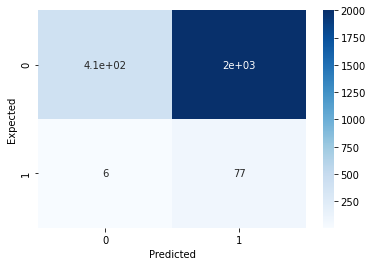

In [ ]:
get_report('mlp_tfidf_neg_1', y_test, y_pred_mlp_tfidf_neg_1)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = mlp_tfidf_neg.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      0
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text), ngram_range=(1,2))
vect_all_neg = negative_vectorizer.fit_transform(tweets)
X_train_neg = negative_vectorizer.transform(X_train)
tf = TfidfTransformer(use_idf=False)
tf.fit(vect_all_neg)
X_train_tf_neg = tf.transform(X_train_neg)
X, y = nm.fit_sample(X_train_tf_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_tf_unigram_bigram_neg = new_pipeline(MLPClassifier(verbose=10, random_state=42, max_iter=1000))

In [ ]:
mlp_tf_unigram_bigram_neg.fit(X, y)

Iteration 1, loss = 0.68880302
Iteration 2, loss = 0.65481040
Iteration 3, loss = 0.62303621
Iteration 4, loss = 0.58938410
Iteration 5, loss = 0.55326543
Iteration 6, loss = 0.51464123
Iteration 7, loss = 0.47734436
Iteration 8, loss = 0.44199264
Iteration 9, loss = 0.40958065
Iteration 10, loss = 0.38126448
Iteration 11, loss = 0.35656178
Iteration 12, loss = 0.33557076
Iteration 13, loss = 0.31845443
Iteration 14, loss = 0.30470492
Iteration 15, loss = 0.29387425
Iteration 16, loss = 0.28468848
Iteration 17, loss = 0.27757459
Iteration 18, loss = 0.27185781
Iteration 19, loss = 0.26707970
Iteration 20, loss = 0.26331377
Iteration 21, loss = 0.26015348
Iteration 22, loss = 0.25731942
Iteration 23, loss = 0.25487454
Iteration 24, loss = 0.25264949
Iteration 25, loss = 0.25069164
Iteration 26, loss = 0.24889061
Iteration 27, loss = 0.24715684
Iteration 28, loss = 0.24557215
Iteration 29, loss = 0.24407212
Iteration 30, loss = 0.24264217
Iteration 31, loss = 0.24121001
Iteration 32, los

Pipeline(memory=None,
         steps=[('model',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=42, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1, verbose=10,
                               warm_start=False))],
         verbose=False)

In [ ]:
X_test_vectorizer_neg = negative_vectorizer.transform(X_test)
X_test_tf_unigram_bigram_neg = tf.transform(X_test_vectorizer_neg)

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_tf_unigram_bigram_neg_1 = mlp_tf_unigram_bigram_neg.predict(X_test_tf_unigram_bigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-31 12:10:44.670104-03:00 [INFO] starting predict...
2020-10-31 12:10:44.695573-03:00 [INFO] predict successful...


2020-10-31 12:10:50.954605-03:00 [INFO] Metrics using mlp_tf_unigram_bigram_neg_1
2020-10-31 12:10:50.954712-03:00 [INFO] Accuracy = 0.24889779559118236
              precision    recall  f1-score   support

           0       0.99      0.23      0.37      2412
           1       0.04      0.92      0.08        83

    accuracy                           0.25      2495
   macro avg       0.51      0.57      0.22      2495
weighted avg       0.96      0.25      0.36      2495



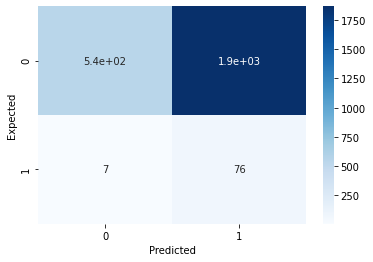

In [ ]:
get_report('mlp_tf_unigram_bigram_neg_1', y_test, y_pred_mlp_tf_unigram_bigram_neg_1)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = mlp_tf_unigram_bigram_neg.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

**Save predict result and group result**

In [ ]:
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_vectorized_unigram)

In [ ]:
y_pred_mlp_bigram_1 = mlp_bigram.predict(X_test_vectorized_bigram)

In [ ]:
y_pred_mlp_unigram_bigram_1 = mlp_unigram_bigram.predict(X_test_vectorized_unigram_bigram)

In [ ]:
y_pred_mlp_tf_1 = mlp_tf.predict(X_test_tf)

In [ ]:
y_pred_mlp_tfidf_1 = mlp_tfidf.predict(X_test_tfidf)

In [ ]:
vect_transform_neg = negative_vectorizer.transform(X_test)
y_pred_mlp_unigram_neg_1 = mlp_unigram_neg.predict(vect_transform_neg)

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text), ngram_range=(2,2))
negative_vectorizer.fit_transform(tweets)
vect_transform_neg = negative_vectorizer.transform(X_test)
y_pred_mlp_bigram_neg_1 = mlp_bigram_neg.predict(vect_transform_neg)

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text), ngram_range=(1,2))
negative_vectorizer.fit_transform(tweets)
vect_transform_neg = negative_vectorizer.transform(X_test)
y_pred_mlp_unigram_bigram_neg_1 = mlp_unigram_bigram_neg.predict(vect_transform_neg)

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text))
vect_all_neg = negative_vectorizer.fit_transform(tweets)
vect_transform_neg = negative_vectorizer.transform(X_test)
tf_neg = TfidfTransformer(use_idf=False)
tf_neg.fit(vect_all_neg)
vect_transform_neg = tf_neg.transform(vect_transform_neg)
y_pred_mlp_tf_neg_1 = mlp_tf_neg.predict(vect_transform_neg)

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text))
vect_all_neg = negative_vectorizer.fit_transform(tweets)
vect_transform_neg = negative_vectorizer.transform(X_test)
tfidf_neg = TfidfTransformer(use_idf=True)
tfidf_neg.fit(vect_all_neg)
vect_transform_neg = tfidf_neg.transform(vect_transform_neg)
y_pred_mlp_tfidf_neg_1 = mlp_tfidf_neg.predict(vect_transform_neg)

In [ ]:
df_predict_results = pd.DataFrame({'tweet' : X_test})
df_predict_results['class_mlp_unigram_1'] = y_pred_mlp_unigram_1
df_predict_results['class_mlp_bigram_1'] = y_pred_mlp_bigram_1
df_predict_results['class_mlp_unigram_bigram_1'] = y_pred_mlp_unigram_bigram_1
df_predict_results['class_mlp_tf_1'] = y_pred_mlp_tf_1
df_predict_results['class_mlp_tfidf_1'] = y_pred_mlp_tfidf_1
df_predict_results['class_mlp_unigram_neg_1'] = y_pred_mlp_unigram_neg_1
df_predict_results['class_mlp_bigram_neg_1'] = y_pred_mlp_bigram_neg_1
df_predict_results['class_mlp_unigram_bigram_neg_1'] = y_pred_mlp_unigram_bigram_neg_1
df_predict_results['class_mlp_tf_neg_1'] = y_pred_mlp_tf_neg_1
df_predict_results['class_mlp_tfidf_neg_1'] = y_pred_mlp_tfidf_neg_1
df_predict_results.to_csv('predict_results_2.csv', encoding = 'utf-8', index = False)

In [ ]:
df_predict_results.head()

tweet  ...  class_mlp_tfidf_neg_1
0  nao quero fazer festa anos nao sei passa comig...  ...                      0
1                         ver q vou comprar aindamds  ...                      1
2                                      vamos fofocas  ...                      1
3  decidi assistir step up vou assistir todos nao...  ...                      1
4               quer dizer q casos covid estao queda  ...                      1

[5 rows x 11 columns]

In [ ]:
df_predict_results = pd.read_csv('predict_results_2.csv')

In [ ]:
df_predict_results.drop(['class_mlp_tfidf_neg_1', 'class_mlp_unigram_bigram_neg_1', 'class_mlp_tf_neg_1', 'class_mlp_bigram_neg_1', 'class_mlp_tfidf_1'],
                        axis=1, inplace=True)
model_columns_result = df_predict_results.loc[:, df_predict_results.columns != 'tweet'].columns

In [ ]:
df_predict_results[model_columns_result]

class_mlp_unigram_1  ...  class_mlp_unigram_neg_1
0                       1  ...                        1
1                       0  ...                        1
2                       0  ...                        0
3                       0  ...                        1
4                       1  ...                        1
...                   ...  ...                      ...
2490                    0  ...                        1
2491                    0  ...                        0
2492                    0  ...                        0
2493                    0  ...                        1
2494                    1  ...                        1

[2495 rows x 5 columns]

In [ ]:
y_pred = pd.DataFrame()
y_pred = df_predict_results[model_columns_result].mode(axis=1)

2020-10-30 21:01:42.986590-03:00 [INFO] Metrics using mlp_final_1
2020-10-30 21:01:42.986780-03:00 [INFO] Accuracy = 0.6360721442885772
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      2412
           1       0.08      0.88      0.14        83

    accuracy                           0.64      2495
   macro avg       0.53      0.75      0.45      2495
weighted avg       0.96      0.64      0.75      2495



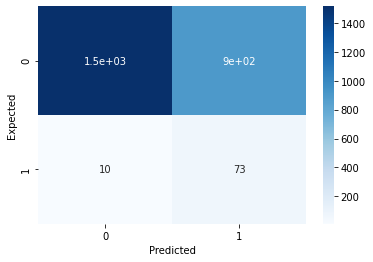

In [ ]:
get_report('mlp_final_1', y_test, y_pred[0])

In [ ]:
save_model("mlp_unigram_final", mlp_unigram)
save_model("mlp_bigram_final", mlp_bigram)
save_model("mlp_unigram_bigram_final", mlp_unigram_bigram)
save_model("mlp_tf_final", mlp_tf)
save_model("mlp_unigram_neg_final", mlp_unigram_neg)

mlp_unigram_final model was saved sucessfully!
mlp_bigram_final model was saved sucessfully!
mlp_unigram_bigram_final model was saved sucessfully!
mlp_tf_final model was saved sucessfully!
mlp_unigram_neg_final model was saved sucessfully!


In [ ]:
import glob

In [ ]:
cd '../Models'

/content/drive/My Drive/TCC/Models


In [ ]:
save_model("mlp_unigram_final", mlp_unigram)

mlp_unigram_final model was saved sucessfully!


In [ ]:
print('{} [INFO] Loading MLP models'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram = joblib.load('mlp_unigram_final')
mlp_bigram = joblib.load('mlp_bigram_final')
mlp_unigram_bigram = joblib.load('mlp_unigram_bigram_final')
mlp_tf = joblib.load('mlp_tf_final')
mlp_unigram_neg = joblib.load('mlp_unigram_neg_final')

2020-11-01 14:32:45.011860-02:00 [INFO] Loading MLP models


In [ ]:
cd '../Tweets'

/content/drive/My Drive/TCC/Tweets


In [ ]:
def vectoreize(text_array):
  print('{} [INFO] Preprocessing...'.format(dt.datetime.now().astimezone(tz)))
  # Vectorize using unigrams
  vectorized_unigram = vectorizer.transform(text_array)

  # Vectorize using bigrams
  vectorized_bigram = vectorizer_bigram.transform(text_array)

  # Vectorize using unigrams and bigrams
  vectorized_unigram_bigram = vectorizer_unigram_bigram.transform(text_array)

  # Vectorize using term frequency with unigrams
  frequency = tf.transform(vectorized_unigram)

  # Vectorize using unigrams with negative tokenizer
  vectorized_unigram_neg = negative_vectorizer.transform(text_array)

  return vectorized_unigram, vectorized_bigram, vectorized_unigram_bigram, frequency, vectorized_unigram_neg

In [ ]:
print('{} [INFO] Searching collected tweets'.format(dt.datetime.now().astimezone(tz)))
files = glob.glob("*.csv")
files.remove('train.csv')
print('{} [INFO] It was found {} files'.format(dt.datetime.now().astimezone(tz),len(files)))

for file in files:
  print('{} [INFO] Reading file: {}'.format(dt.datetime.now().astimezone(tz),file))
  df = pd.read_csv(file)
  tweets = preprocessing(df['text'])
  vectorized_unigram_final, vectorized_bigram_final, vectorized_unigram_bigram_final, frequency_final, vectorized_unigram_neg_final = vectoreize(tweets)
  print('{} [INFO] Starting predict...'.format(dt.datetime.now().astimezone(tz),file))
  df_results = pd.DataFrame()
  df_results['class_mlp_unigram'] = mlp_unigram.predict(vectorized_unigram_final)
  df_results['class_mlp_bigram'] = mlp_bigram.predict(vectorized_bigram_final)
  df_results['class_mlp_unigram_bigram'] = mlp_unigram_bigram.predict(vectorized_unigram_bigram_final)
  df_results['class_mlp_tf'] = mlp_tf.predict(frequency_final)
  df_results['class_mlp_unigram_neg'] = mlp_unigram_neg.predict(vectorized_unigram_neg_final)
  final_class = df_results.mode(axis=1)
  df['class'] = final_class[0]
  df.to_csv(file, encoding = 'utf-8', index = False)

2020-11-01 15:15:17.287335-02:00 [INFO] Searching collected tweets
2020-11-01 15:15:17.290358-02:00 [INFO] It was found 53 files
2020-11-01 15:15:17.290918-02:00 [INFO] Reading file: tweets_2020-08-18 23:33:29.542988.csv
2020-11-01 15:15:26.393665-02:00 [INFO] Preprocessing...
2020-11-01 15:15:27.350251-02:00 [INFO] Starting predict...
2020-11-01 15:15:30.931268-02:00 [INFO] Reading file: tweets_2020-08-20 23:28:43.333986.csv
2020-11-01 15:15:49.373520-02:00 [INFO] Preprocessing...
2020-11-01 15:15:51.644612-02:00 [INFO] Starting predict...
2020-11-01 15:16:00.628120-02:00 [INFO] Reading file: tweets_2020-08-21 21:15:09.377909-03:00.csv
2020-11-01 15:16:14.698030-02:00 [INFO] Preprocessing...
2020-11-01 15:16:16.370828-02:00 [INFO] Starting predict...
2020-11-01 15:16:22.838426-02:00 [INFO] Reading file: tweets_2020-08-22 21:35:23.026428-03:00.csv
2020-11-01 15:16:36.817824-02:00 [INFO] Preprocessing...
2020-11-01 15:16:38.347162-02:00 [INFO] Starting predict...
2020-11-01 15:16:44.375

In [ ]:
df_array = []
files.append('train.csv')

for file in files:
  print('{} [INFO] Adding file: {}'.format(dt.datetime.now().astimezone(tz),file))
  df_array.append(pd.read_csv(file))

print('{} [INFO] Merging files...'.format(dt.datetime.now().astimezone(tz)))
merged_files = pd.concat(df_array).reset_index(drop=True)
print('{} [INFO] Files was merged successfully...'.format(dt.datetime.now().astimezone(tz)))

2020-11-01 16:25:10.743709-02:00 [INFO] Adding file: tweets_2020-08-18 23:33:29.542988.csv
2020-11-01 16:25:10.788145-02:00 [INFO] Adding file: tweets_2020-08-20 23:28:43.333986.csv
2020-11-01 16:25:10.887499-02:00 [INFO] Adding file: tweets_2020-08-21 21:15:09.377909-03:00.csv
2020-11-01 16:25:10.963722-02:00 [INFO] Adding file: tweets_2020-08-22 21:35:23.026428-03:00.csv
2020-11-01 16:25:11.045434-02:00 [INFO] Adding file: tweets_2020-08-23 20:42:25.227123-03:00.csv
2020-11-01 16:25:11.095988-02:00 [INFO] Adding file: tweets_2020-08-24 22:59:27.763912-03:00.csv
2020-11-01 16:25:11.216651-02:00 [INFO] Adding file: tweets_2020-08-25 22:05:09.888276-03:00.csv
2020-11-01 16:25:11.314285-02:00 [INFO] Adding file: tweets_2020-08-26 21:32:00.406994-03:00.csv
2020-11-01 16:25:11.420866-02:00 [INFO] Adding file: tweets_2020-08-27 22:00:14.989243-03:00.csv
2020-11-01 16:25:11.516564-02:00 [INFO] Adding file: tweets_2020-08-28 20:05:01.541643-03:00.csv
2020-11-01 16:25:11.575640-02:00 [INFO] Ad

In [ ]:
merged_files.to_csv('merged_tweets_from_20200818_to_20201013', encoding = 'utf-8', index = False)

In [ ]:
merged_files = pd.read_csv('merged_tweets_from_20200818_to_20201013')

In [ ]:
merged_files.shape

(1657525, 9)

In [ ]:
merged_files.rename(columns={'class': 'class_'}, inplace=True)

In [ ]:
!pip3 install multidict

     |████████████████████████████████| 143kB 2.6MB/s 


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import multidict as multidict

In [ ]:
new_stopwords = ["da", "meu", "em", "voce", "de", "ao", "os", "rt", "vou", 
                "pra", "nao", "ja", "ta", "vcs", "vc", "p", "k", "vao", "sem", 
                "la", "estou", "estao", "ne", "umas", "um", "uns", "vez", 
                "tava", "eu", "nos", "eles", "nunca", "mim", "deu", "vi", 
                "nesse", "oq", "ser", "d", "ter", "pq", "q", "ai", "pro", 
                "ate", "hoje", "ia", "so", "tao", "faz", "aqui", "to", 
                "sei", "c", "ne", "mt", "nao", "dessa", "sao", "sim", "nao", 
                "vai", "eh", "cara", "voces", "tambem", "eu", "assim", "hj", 
                "mano", "entao", "e", "dps", "e"]

In [ ]:
classified_as_one = merged_files.query('class_ == 1')['text']
classified_as_one = preprocessing(classified_as_one, new_stopwords)

In [ ]:
classified_as_one.shape

(727977,)

In [ ]:
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

In [ ]:
all_summary = " ".join(s for s in classified_as_one)

In [ ]:
stop_words = set(STOPWORDS)
stop_words.update(new_stopwords)

In [ ]:
wordcloud = WordCloud(width=1800,   
                      collocations=False, stopwords=stop_words,                        
                      height=800).generate_from_frequencies(getFrequencyDictForText(all_summary))

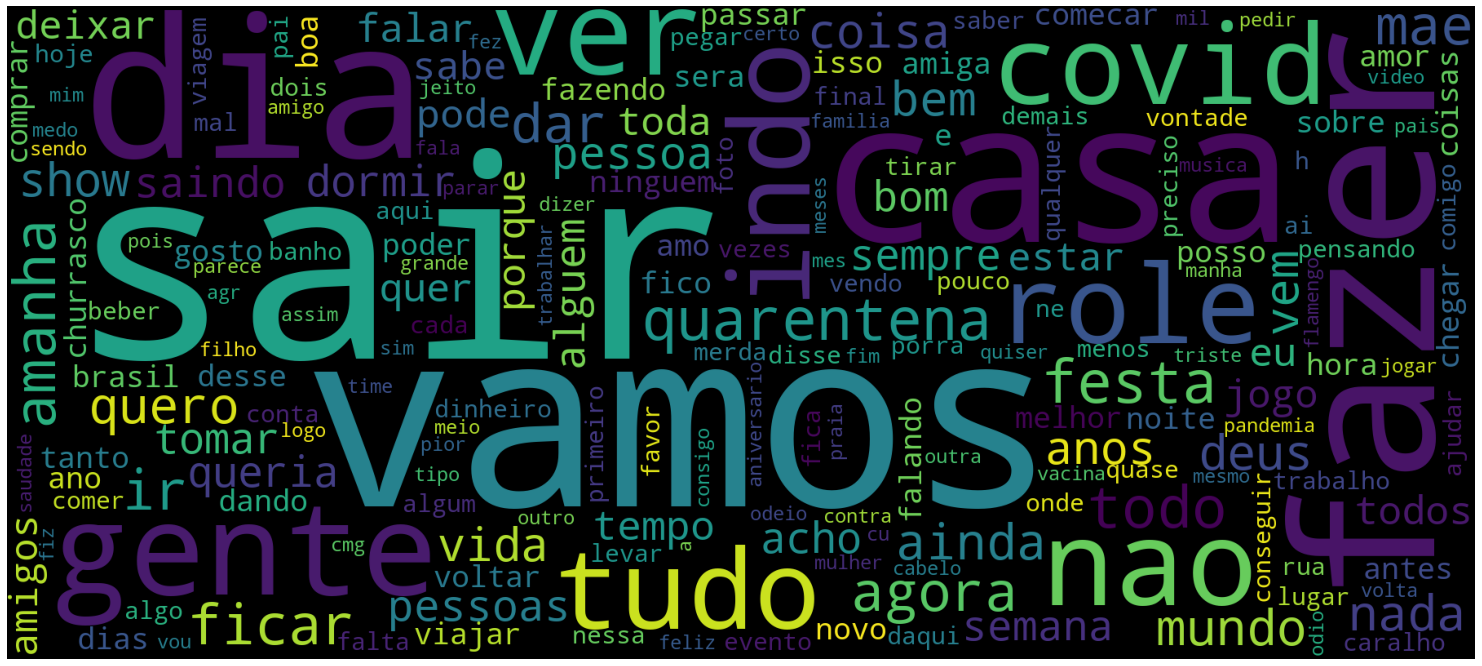

In [ ]:
fig, ax = plt.subplots(figsize=(42,12))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)                 
#wordcloud.to_file('wordcloud.png',);

In [ ]:
wordcloud = WordCloud(width=1800,   
                      collocations=False, stopwords=stop_words,                         
                      height=800).generate(all_summary)

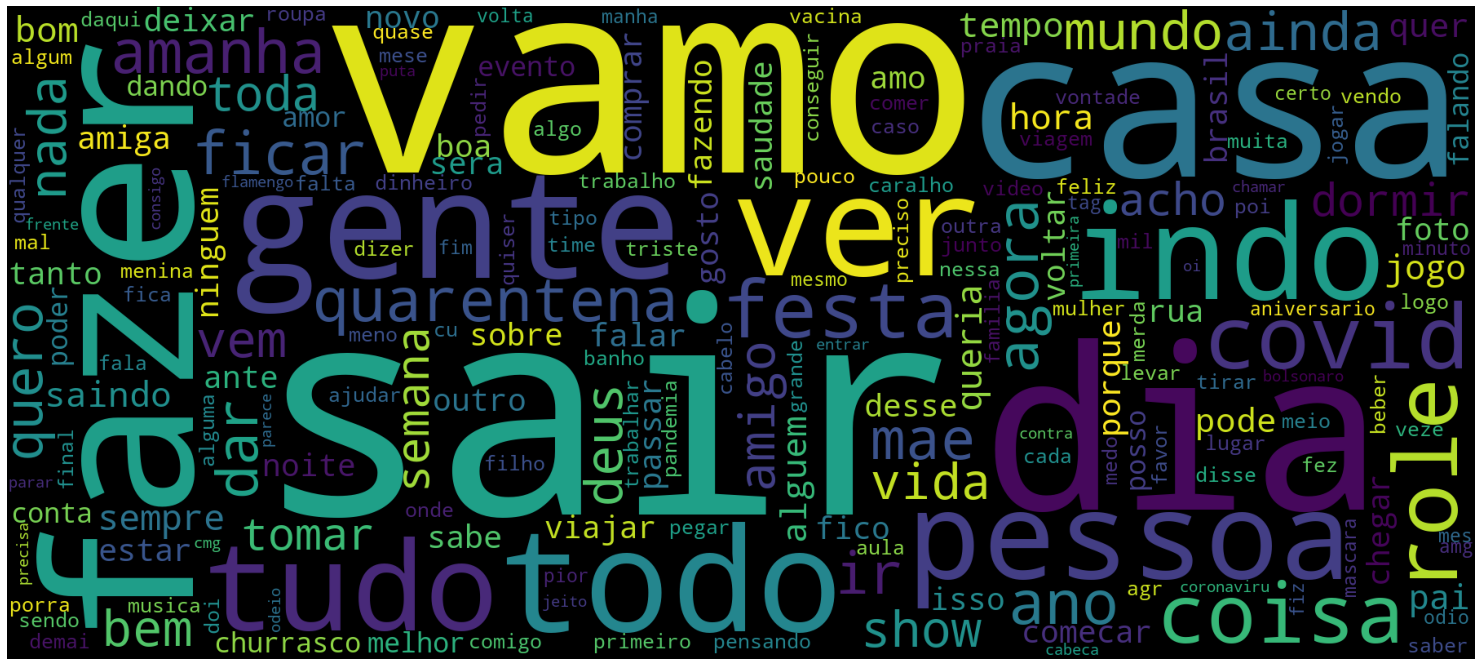

In [ ]:
fig, ax = plt.subplots(figsize=(42,12))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)                 
#wordcloud.to_file('wordcloud.png',);

In [ ]:
wordcloud = WordCloud(width=1800,   
                      collocations=False,                         
                      height=800).generate_from_frequencies(getFrequencyDictForText(all_summary))

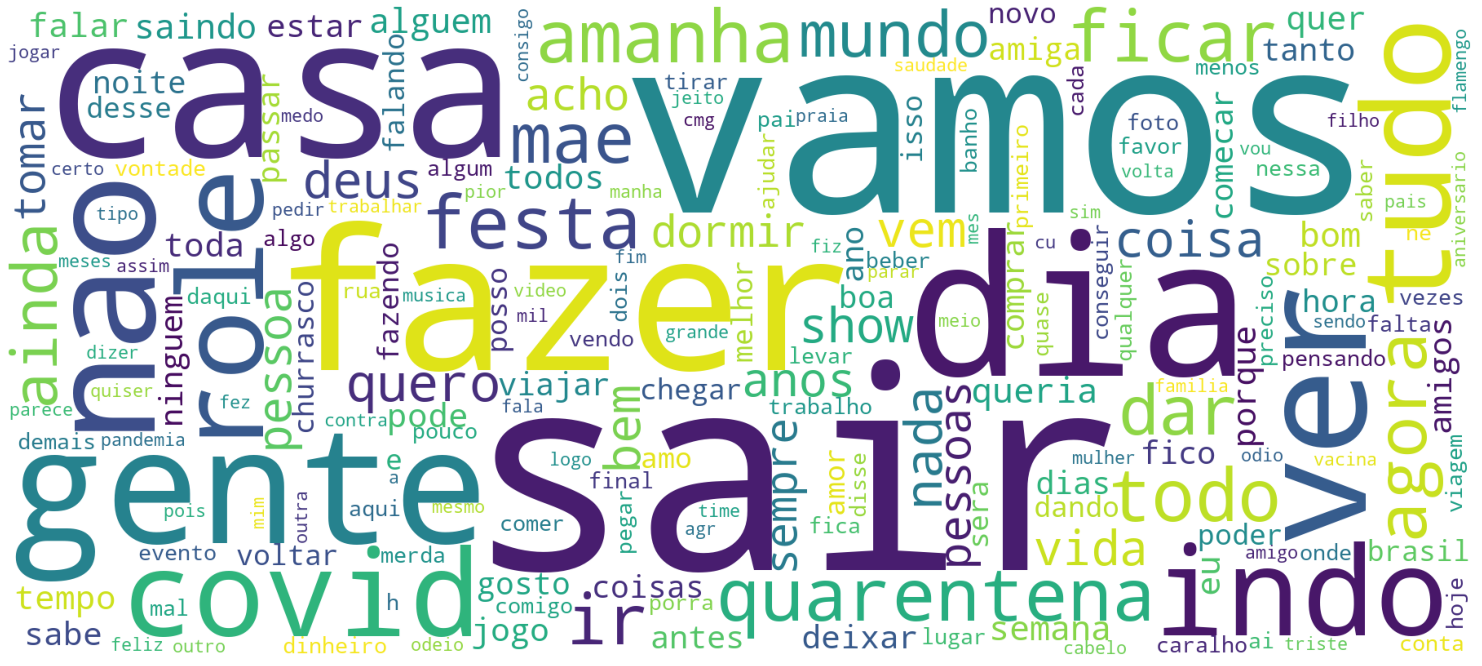

In [ ]:
fig, ax = plt.subplots(figsize=(42,12))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)                 
#wordcloud.to_file('wordcloud.png',);

In [ ]:
classified_as_one = preprocessing(classified_as_one, new_stopwords)

In [ ]:
merged_files['created_at'] = pd.to_datetime(merged_files['created_at'], errors='coerce')
merged_files['hour'] = merged_files['created_at'].dt.hour

In [ ]:
merged_files['created_at_formatted'] = merged_files['created_at_formatted'].dt.strftime('%m/%d/%Y')

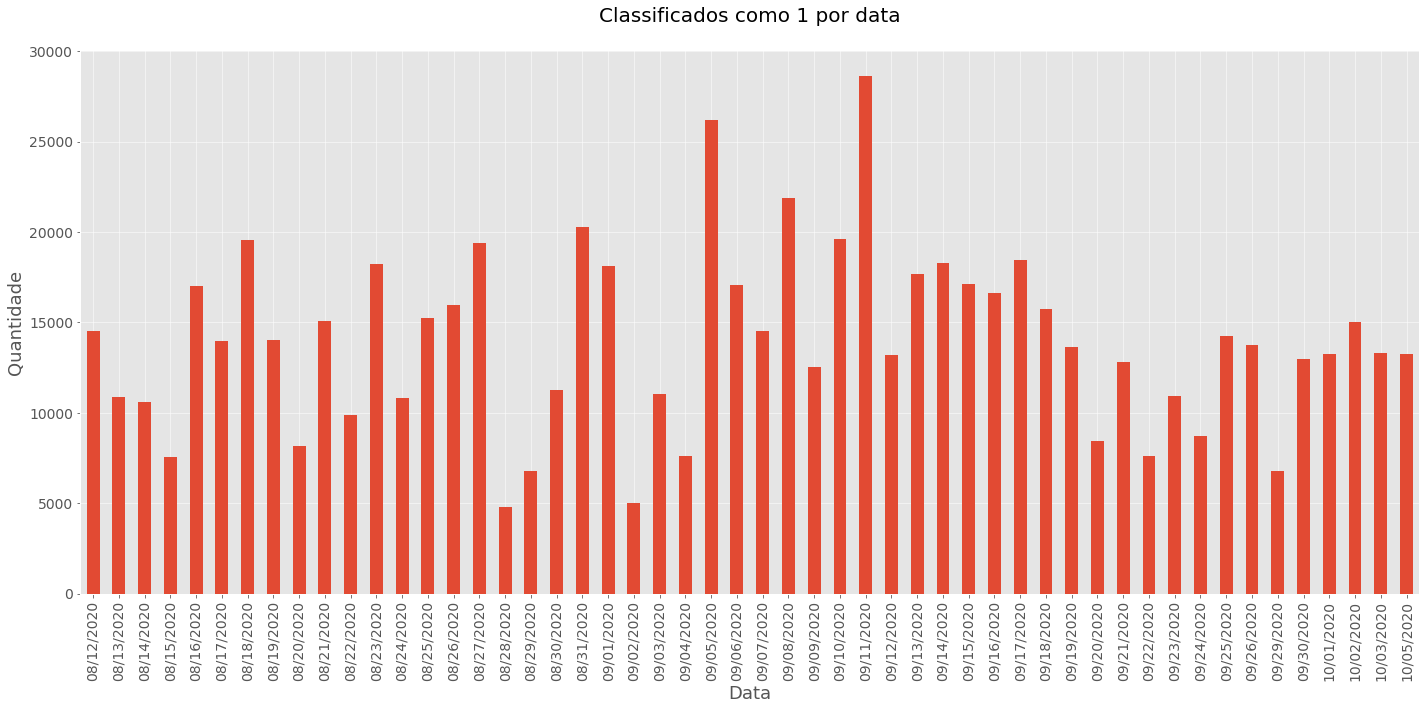

In [ ]:
ax = merged_files.query('class_ == 1')['created_at_formatted'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(24,10))
ax.set_title('Classificados como 1 por data\n', fontsize=20)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Quantidade', fontsize=18);

In [ ]:
!pip3 install geopy

In [ ]:
import json
from geopy.geocoders import Nominatim

In [ ]:
geo = merged_files.query('geo == geo')['geo']
coordinates = []
for coordinate in geo:
  coordinate = coordinate.replace("'", '"')
  coordinates.append(json.loads(coordinate))

In [ ]:
geolocator = Nominatim(user_agent="quarantine_covid19_behavior_analysis")

address_array = []

for coordinate in coordinates:
  location = geolocator.reverse("{}, {}".format(coordinate['coordinates'][0], coordinate['coordinates'][1]))
  address_array.append(location.raw)

In [ ]:
df_address = pd.DataFrame(x['address'] for x in address_array)

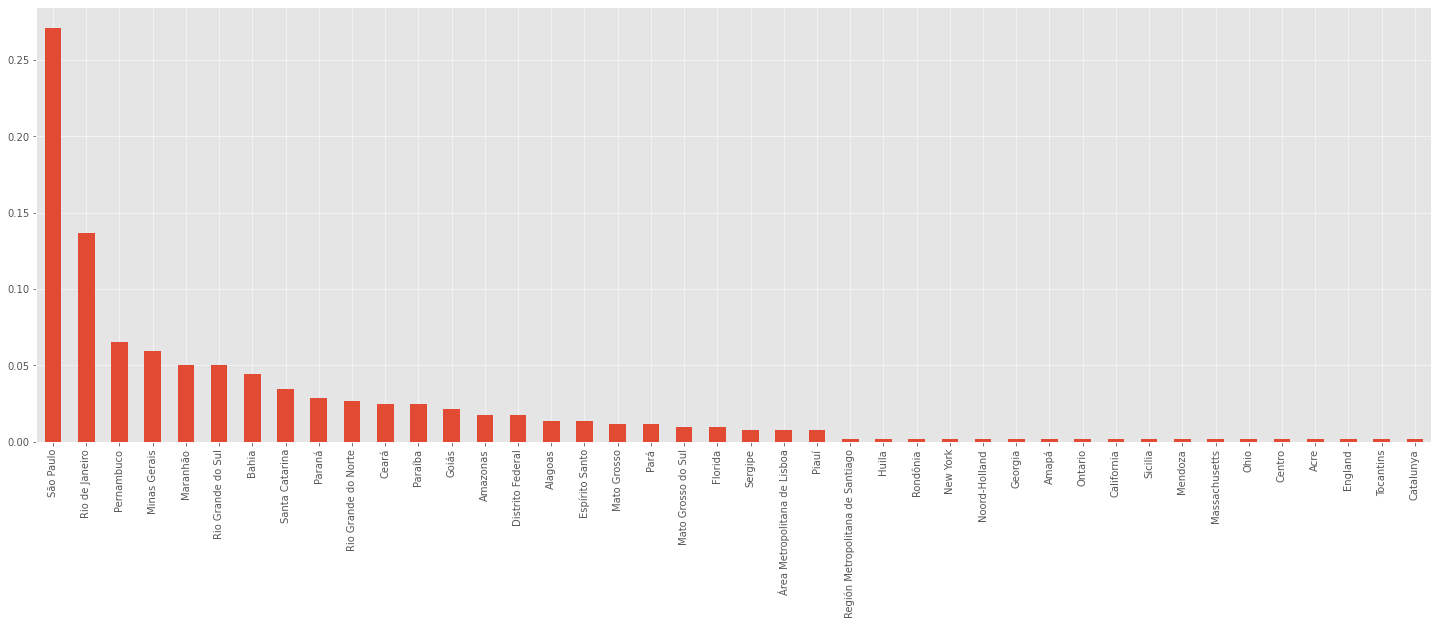

In [ ]:
df_address['state'].value_counts(normalize=True).plot.bar(figsize=(25,8))

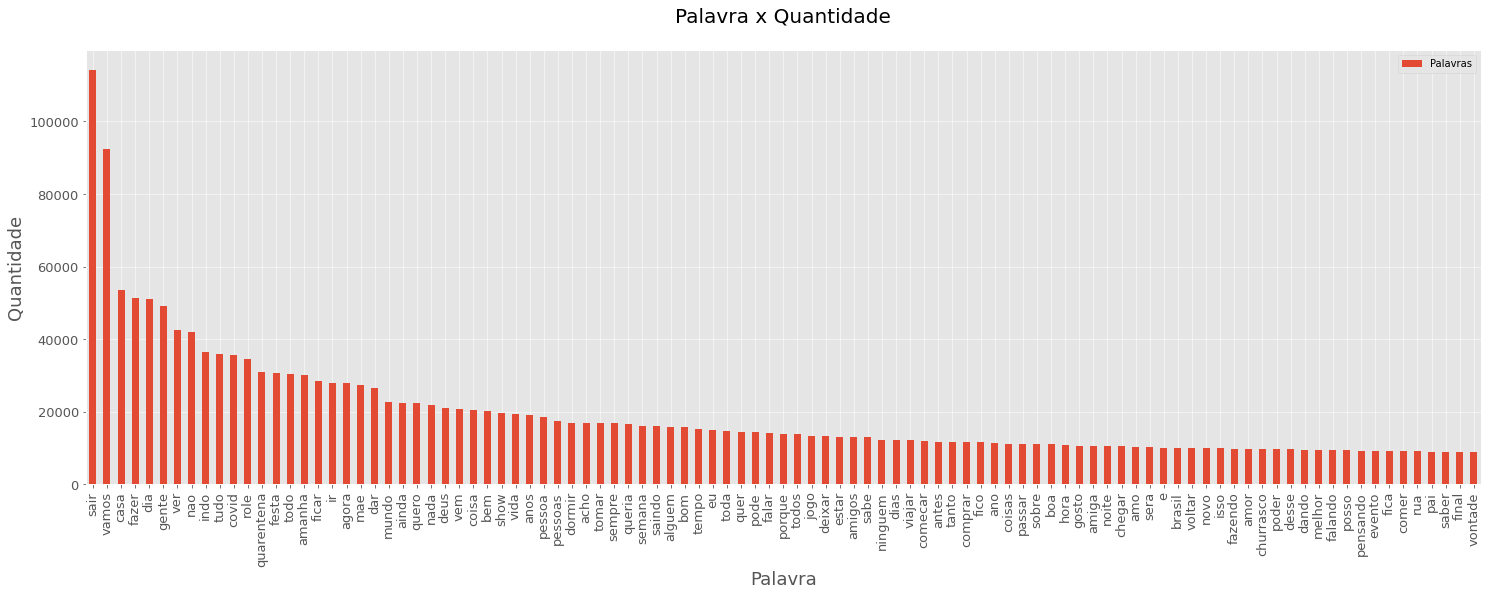

In [ ]:
frequencyDict = getFrequencyDictForText(all_summary)
frequencyDict = {k: v for k, v in sorted(frequencyDict.items(), key=lambda item: item[1], reverse=True)[:100]}
freq = pd.DataFrame().from_dict(frequencyDict, orient='index')
freq['Palavras'] = freq[0]
freq.drop(freq.columns[0], 1, inplace=True)
ax = freq[1:].plot(kind='bar', fontsize=13, figsize=(25,8))
ax.set_title('Palavra x Quantidade\n', fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

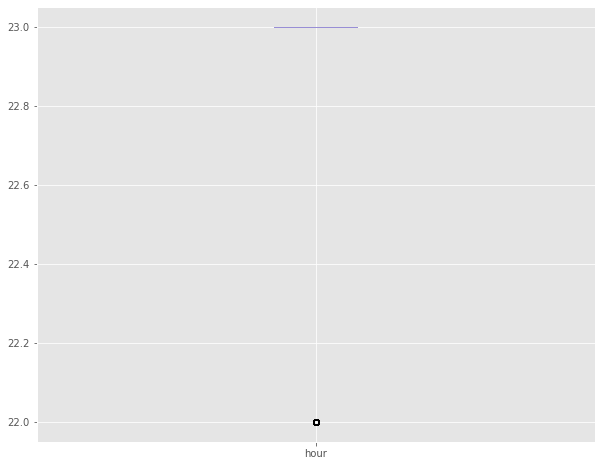

In [ ]:
ax = merged_files['hour'].plot.box(grid = True, figsize=(10,8))

**Most frequently by time and day of week**

In [ ]:
import calendar

In [ ]:
merged_files['day_of_week'] = merged_files['created_at'].dt.weekday
merged_files['day_of_week'] = merged_files['day_of_week'].apply(lambda x: calendar.day_name[x])

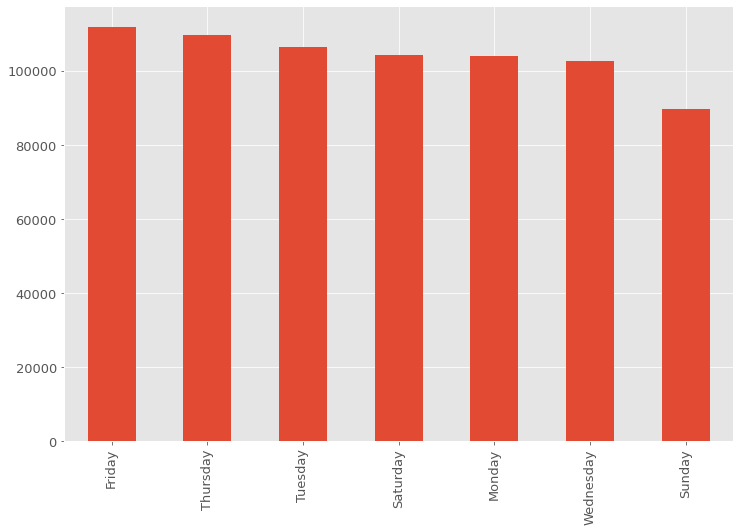

In [ ]:
merged_files.query('class_ == 1')['day_of_week'].value_counts().plot(kind='bar', fontsize=13, figsize=(12,8))

In [ ]:
monday = merged_files.query('class_ == 1')[merged_files['day_of_week'] == 'Monday']
monday_tweets = preprocessing(monday['text'], stop_words)
monday_summary = " ".join(s for s in monday_tweets)
monday_summary = getFrequencyDictForText(monday_summary)
print('Monday finish...')

tuesday = merged_files.query('class_ == 1')[merged_files['day_of_week'] == 'Tuesday']
tuesday_tweets = preprocessing(tuesday['text'], stop_words)
tuesday_summary = " ".join(s for s in tuesday_tweets)
tuesday_summary = getFrequencyDictForText(tuesday_summary)
print('Tuesday finish...')

wednesday = merged_files.query('class_ == 1')[merged_files['day_of_week'] == 'Wednesday']
wednesday_tweets = preprocessing(wednesday['text'], stop_words)
wednesday_summary = " ".join(s for s in wednesday_tweets)
wednesday_summary = getFrequencyDictForText(wednesday_summary)
print('Wednesday finish...')

thursday = merged_files.query('class_ == 1')[merged_files['day_of_week'] == 'Thursday']
thursday_tweets = preprocessing(thursday['text'], stop_words)
thursday_summary = " ".join(s for s in thursday_tweets)
thursday_summary = getFrequencyDictForText(thursday_summary)
print('Thursday finish...')

friday = merged_files.query('class_ == 1')[merged_files['day_of_week'] == 'Friday']
friday_tweets = preprocessing(friday['text'], stop_words)
friday_summary = " ".join(s for s in friday_tweets)
friday_summary = getFrequencyDictForText(friday_summary)
print('Friday finish...')

saturday = merged_files.query('class_ == 1')[merged_files['day_of_week'] == 'Saturday']
saturday_tweets = preprocessing(saturday['text'], stop_words)
saturday_summary = " ".join(s for s in saturday_tweets)
saturday_summary = getFrequencyDictForText(saturday_summary)
print('Saturday finish...')

sunday = merged_files.query('class_ == 1')[merged_files['day_of_week'] == 'Sunday']
sunday_tweets = preprocessing(sunday['text'], stop_words)
sunday_summary = " ".join(s for s in sunday_tweets)
sunday_summary = getFrequencyDictForText(sunday_summary)
print('Sunday finish...')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Monday finish...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Tuesday finish...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


Wednesday finish...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Thursday finish...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Friday finish...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Saturday finish...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Sunday finish...


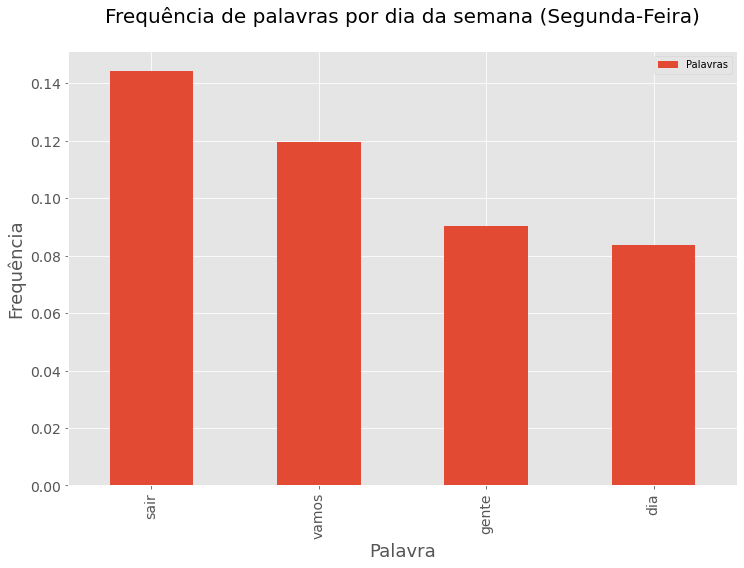

In [ ]:
monday_frequency_dict = {k: v for k, v in sorted(monday_summary.items(), key=lambda item: item[1], reverse=True)[:5]}
monday_total = monday_tweets.size
monday_freq = pd.DataFrame().from_dict(monday_frequency_dict, orient='index')
monday_freq['Palavras'] = monday_freq[0] / monday_total
monday_freq.drop(monday_freq.columns[0], 1, inplace=True)
ax = monday_freq[1:].plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Frequência de palavras por dia da semana (Segunda-Feira)\n', fontsize=20)
ax.set_ylabel('Frequência', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

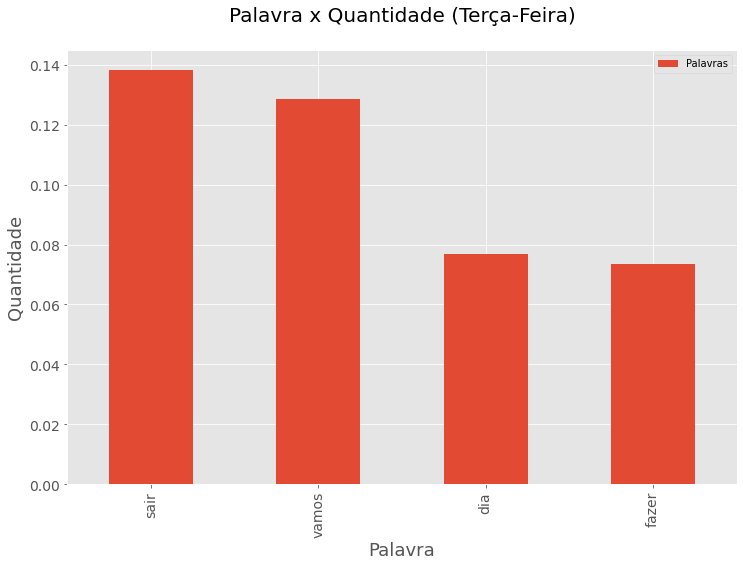

In [ ]:
tuesday_frequency_dict = {k: v for k, v in sorted(tuesday_summary.items(), key=lambda item: item[1], reverse=True)[:5]}
tuesday_total = tuesday_tweets.size
tuesday_freq = pd.DataFrame().from_dict(tuesday_frequency_dict, orient='index')
tuesday_freq['Palavras'] = tuesday_freq[0] / tuesday_total
tuesday_freq.drop(tuesday_freq.columns[0], 1, inplace=True)
ax = tuesday_freq[1:].plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Frequência de palavras por dia da semana (Terça-Feira)\n', fontsize=20)
ax.set_ylabel('Frequência', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

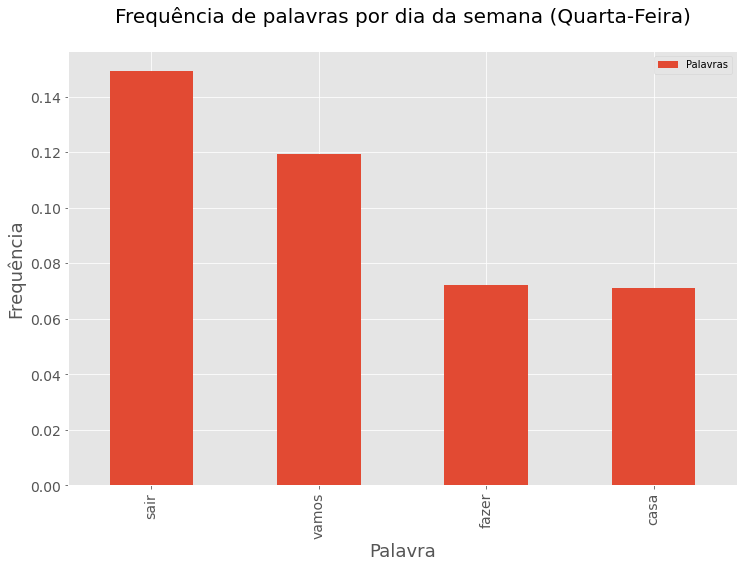

In [ ]:
wednesday_frequency_dict = {k: v for k, v in sorted(wednesday_summary.items(), key=lambda item: item[1], reverse=True)[:5]}
wednesday_total = wednesday_tweets.size
wednesday_freq = pd.DataFrame().from_dict(wednesday_frequency_dict, orient='index')
wednesday_freq['Palavras'] = wednesday_freq[0] / wednesday_total
wednesday_freq.drop(wednesday_freq.columns[0], 1, inplace=True)
ax = wednesday_freq[1:].plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Frequência de palavras por dia da semana (Quarta-Feira)\n', fontsize=20)
ax.set_ylabel('Frequência', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

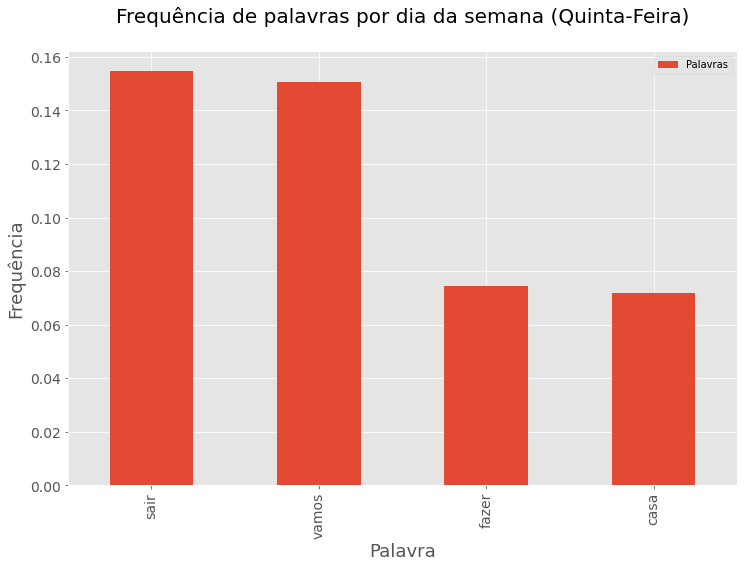

In [ ]:
thursday_frequency_dict = {k: v for k, v in sorted(thursday_summary.items(), key=lambda item: item[1], reverse=True)[:5]}
thursday_total = thursday_tweets.size
thursday_freq = pd.DataFrame().from_dict(thursday_frequency_dict, orient='index')
thursday_freq['Palavras'] = thursday_freq[0] / thursday_total
thursday_freq.drop(thursday_freq.columns[0], 1, inplace=True)
ax = thursday_freq[1:].plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Frequência de palavras por dia da semana (Quinta-Feira)\n', fontsize=20)
ax.set_ylabel('Frequência', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

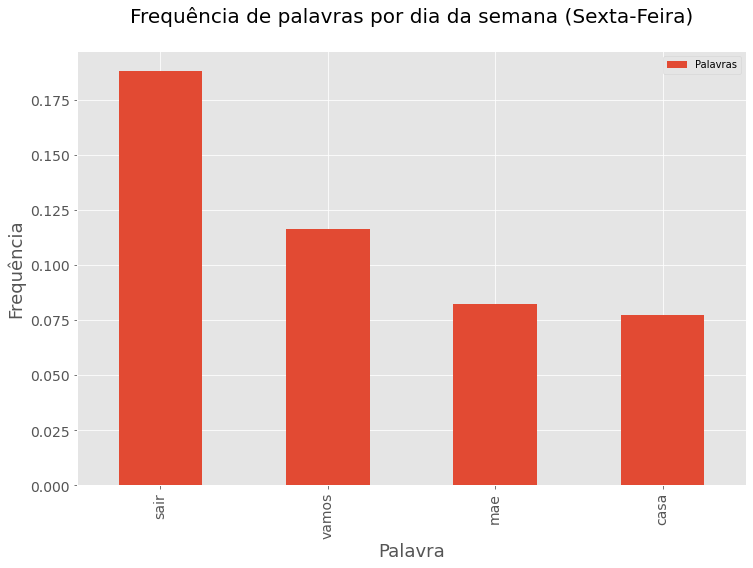

In [ ]:
friday_frequency_dict = {k: v for k, v in sorted(friday_summary.items(), key=lambda item: item[1], reverse=True)[:5]}
friday_total = friday_tweets.size
friday_freq = pd.DataFrame().from_dict(friday_frequency_dict, orient='index')
friday_freq['Palavras'] = friday_freq[0] / friday_total
friday_freq.drop(friday_freq.columns[0], 1, inplace=True)
ax = friday_freq[1:].plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Frequência de palavras por dia da semana (Sexta-Feira)\n', fontsize=20)
ax.set_ylabel('Frequência', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

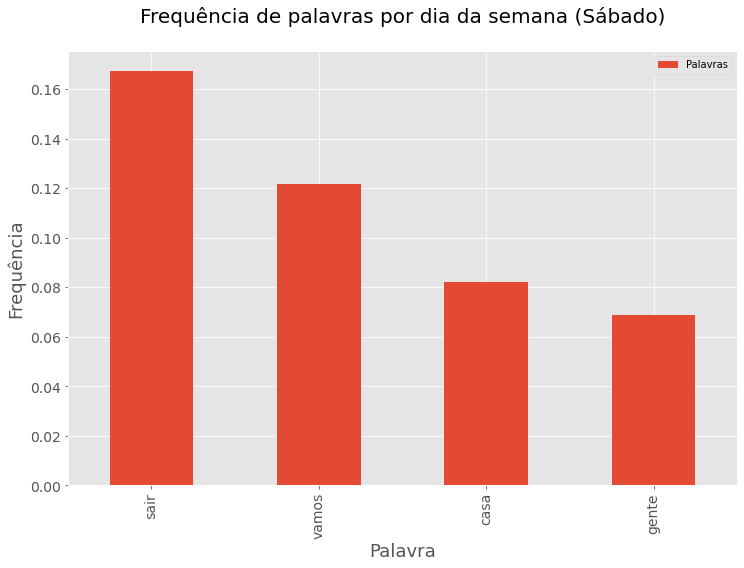

In [ ]:
saturday_frequency_dict = {k: v for k, v in sorted(saturday_summary.items(), key=lambda item: item[1], reverse=True)[:5]}
saturday_total = saturday_tweets.size
saturday_freq = pd.DataFrame().from_dict(saturday_frequency_dict, orient='index')
saturday_freq['Palavras'] = saturday_freq[0] / saturday_total
saturday_freq.drop(saturday_freq.columns[0], 1, inplace=True)
ax = saturday_freq[1:].plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Frequência de palavras por dia da semana (Sábado)\n', fontsize=20)
ax.set_ylabel('Frequência', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

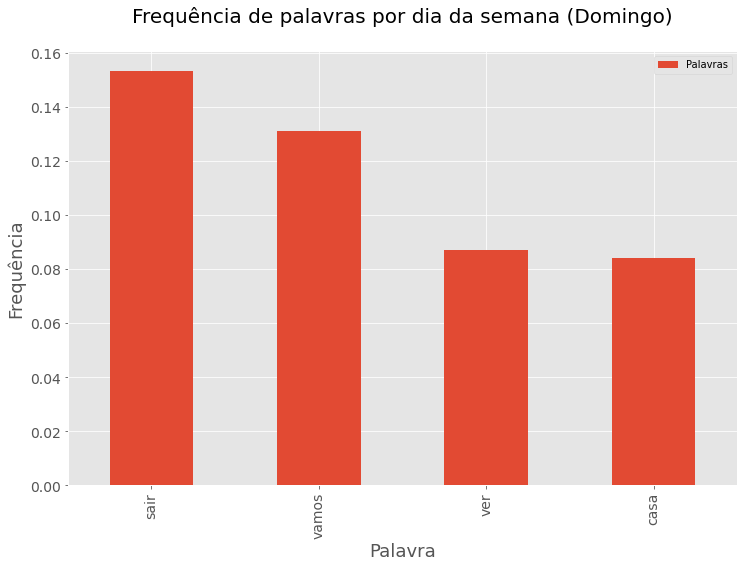

In [ ]:
sunday_frequency_dict = {k: v for k, v in sorted(sunday_summary.items(), key=lambda item: item[1], reverse=True)[:5]}
sunday_total = sunday_tweets.size
sunday_freq = pd.DataFrame().from_dict(sunday_frequency_dict, orient='index')
sunday_freq['Palavras'] = sunday_freq[0] / sunday_total
sunday_freq.drop(sunday_freq.columns[0], 1, inplace=True)
ax = sunday_freq[1:].plot(kind='bar', fontsize=14, figsize=(12,8))
ax.set_title('Frequência de palavras por dia da semana (Domingo)\n', fontsize=20)
ax.set_ylabel('Frequência', fontsize=18)
ax.set_xlabel('Palavra', fontsize=18);

#### **4.2 - Naive Bayes**

**Create pipeline for MultinomialNB**

In [ ]:
nb_unigram = MultinomialNB()
nb_bigram = MultinomialNB()
nb_unigram_bigram = MultinomialNB()
nb_tf = MultinomialNB()
nb_tfidf = MultinomialNB()

In [ ]:
nm = NearMiss()

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
X, y = nm.fit_sample(X_train_vectorized_unigram, y_train)
nb_unigram.fit(X, y)
print('{} [INFO] finish nb_unigram...'.format(dt.datetime.now().astimezone(tz)))
X, y = nm.fit_sample(X_train_vectorized_bigram, y_train)
nb_bigram.fit(X, y)
print('{} [INFO] finish nb_bigram...'.format(dt.datetime.now().astimezone(tz)))
X, y = nm.fit_sample(X_train_vectorized_unigram_bigram, y_train)
nb_unigram_bigram.fit(X, y)
print('{} [INFO] finish nb_unigram_bigram...'.format(dt.datetime.now().astimezone(tz)))
X, y = nm.fit_sample(X_train_tf, y_train)
nb_tf.fit(X, y)
print('{} [INFO] finish nb_tf...'.format(dt.datetime.now().astimezone(tz)))
X, y = nm.fit_sample(X_train_tfidf, y_train)
nb_tfidf.fit(X, y)
print('{} [INFO] finish nb_tfidf...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-26 20:23:14.549905-03:00 [INFO] starting training...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2020-10-26 20:23:14.880923-03:00 [INFO] finish nb_unigram...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2020-10-26 20:23:15.119215-03:00 [INFO] finish nb_bigram...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2020-10-26 20:23:15.459069-03:00 [INFO] finish nb_unigram_bigram...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2020-10-26 20:23:15.767790-03:00 [INFO] finish nb_tf...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2020-10-26 20:23:16.080882-03:00 [INFO] finish nb_tfidf...
2020-10-26 20:23:16.081206-03:00 [INFO] training successful...


2020-10-26 20:23:26.538974-03:00 [INFO] starting predict...
2020-10-26 20:23:26.544378-03:00 [INFO] Metrics using nb_unigram
2020-10-26 20:23:26.544763-03:00 [INFO] Accuracy = 0.1158316633266533
              precision    recall  f1-score   support

           0       1.00      0.09      0.16      2412
           1       0.04      1.00      0.07        83

    accuracy                           0.12      2495
   macro avg       0.52      0.54      0.11      2495
weighted avg       0.97      0.12      0.15      2495



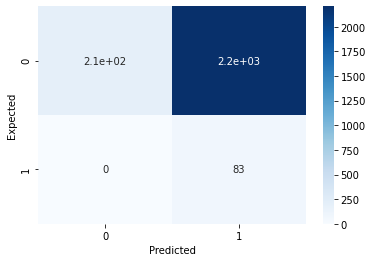

2020-10-26 20:23:26.954092-03:00 [INFO] Metrics using nb_bigram
2020-10-26 20:23:26.954698-03:00 [INFO] Accuracy = 0.5286573146292585
              precision    recall  f1-score   support

           0       0.99      0.52      0.68      2412
           1       0.06      0.84      0.11        83

    accuracy                           0.53      2495
   macro avg       0.52      0.68      0.39      2495
weighted avg       0.96      0.53      0.66      2495



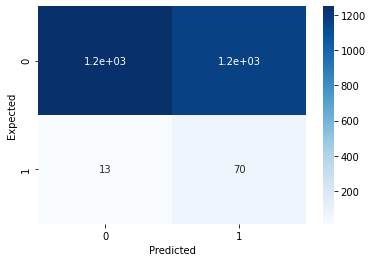

2020-10-26 20:23:27.310477-03:00 [INFO] Metrics using nb_unigram_bigram
2020-10-26 20:23:27.311157-03:00 [INFO] Accuracy = 0.12064128256513026
              precision    recall  f1-score   support

           0       1.00      0.09      0.17      2412
           1       0.04      0.99      0.07        83

    accuracy                           0.12      2495
   macro avg       0.52      0.54      0.12      2495
weighted avg       0.96      0.12      0.16      2495



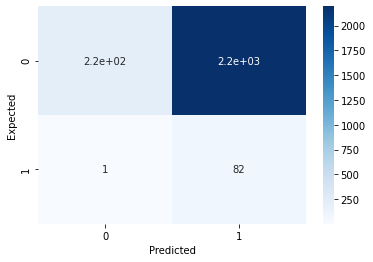

2020-10-26 20:23:27.659392-03:00 [INFO] Metrics using nb_tf
2020-10-26 20:23:27.659925-03:00 [INFO] Accuracy = 0.38276553106212424
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      2412
           1       0.05      0.96      0.09        83

    accuracy                           0.38      2495
   macro avg       0.52      0.66      0.31      2495
weighted avg       0.97      0.38      0.52      2495



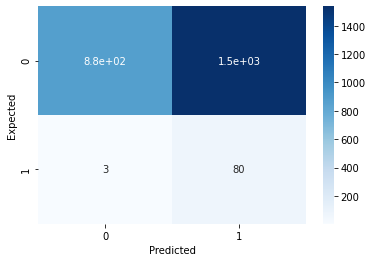

2020-10-26 20:23:28.027683-03:00 [INFO] Metrics using nb_tfidf
2020-10-26 20:23:28.028315-03:00 [INFO] Accuracy = 0.38276553106212424
              precision    recall  f1-score   support

           0       1.00      0.36      0.53      2412
           1       0.05      0.96      0.09        83

    accuracy                           0.38      2495
   macro avg       0.52      0.66      0.31      2495
weighted avg       0.97      0.38      0.52      2495



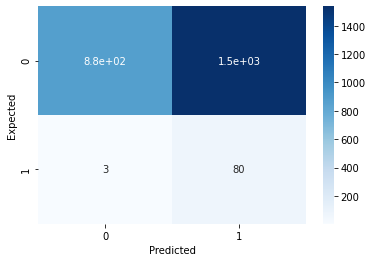

2020-10-26 20:23:28.636559-03:00 [INFO] predict successful...


In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_nb_unigram_1 = nb_unigram.predict(X_test_vectorized_unigram)
get_report('nb_unigram', y_test, y_pred_nb_unigram_1)

y_pred_nb_bigram_1 = nb_bigram.predict(X_test_vectorized_bigram)
get_report('nb_bigram', y_test, y_pred_nb_bigram_1)

y_pred_nb_unigram_bigram_1 = nb_unigram_bigram.predict(X_test_vectorized_unigram_bigram)
get_report('nb_unigram_bigram', y_test, y_pred_nb_unigram_bigram_1)

y_pred_nb_tf_1 = nb_tf.predict(X_test_tf)
get_report('nb_tf', y_test, y_pred_nb_tf_1)

y_pred_nb_tfidf_1 = nb_tfidf.predict(X_test_tfidf)
get_report('nb_tfidf', y_test, y_pred_nb_tfidf_1)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

In [ ]:
vect_transform = vectorizer.transform(new_test)
predict_test = nb_unigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
vect_transform = vectorizer_bigram.transform(new_test)
predict_test = nb_bigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
vect_transform = vectorizer_unigram_bigram.transform(new_test)
predict_test = nb_unigram_bigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
vect_transform = vectorizer.transform(new_test)
tf_transform = tf.transform(X_train_vectorized_unigram)
predict_test = nb_tf.predict(tf_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
vect_transform = vectorizer.transform(new_test)
tfidf_transform = tfidf.transform(X_train_vectorized_unigram)
predict_test = nb_tfidf.predict(tfidf_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      0
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
nb_unigram_neg = MultinomialNB()

In [ ]:
nb_unigram_neg.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = nb_unigram_neg.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      0
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

###**4.5 - Grid Search**

In [ ]:
mlp_unigram = new_pipeline(MLPClassifier(verbose=10, random_state=42))

In [ ]:
nm = NearMiss()

In [ ]:
X, y = nm.fit_sample(X_train_vectorized_unigram, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'model', 'model__activation', 'model__alpha', 'model__batch_size', 'model__beta_1', 'model__beta_2', 'model__early_stopping', 'model__epsilon', 'model__hidden_layer_sizes', 'model__learning_rate', 'model__learning_rate_init', 'model__max_fun', 'model__max_iter', 'model__momentum', 'model__n_iter_no_change', 'model__nesterovs_momentum', 'model__power_t', 'model__random_state', 'model__shuffle', 'model__solver', 'model__tol', 'model__validation_fraction', 'model__verbose', 'model__warm_start'])

In [ ]:
param_grid = {
	'model__hidden_layer_sizes' : [
		(10,), (20,), (20, 10)
	],
	'model__activation': ['tanh', 'relu'],
	'model__solver': ['lbfgs', 'sgd', 'adam'],
	'model__alpha': [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(mlp_unigram, param_grid, n_jobs=-1, verbose=10)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.score(X, y)))
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 14

Iteration 1, loss = 0.67523918
Iteration 2, loss = 0.63055994
Iteration 3, loss = 0.59072233
Iteration 4, loss = 0.55487412
Iteration 5, loss = 0.52172301
Iteration 6, loss = 0.49159556
Iteration 7, loss = 0.46343222
Iteration 8, loss = 0.43784063
Iteration 9, loss = 0.41392505
Iteration 10, loss = 0.39208347
Iteration 11, loss = 0.37160696
Iteration 12, loss = 0.35263045
Iteration 13, loss = 0.33526900
Iteration 14, loss = 0.31910526
Iteration 15, loss = 0.30412102
Iteration 16, loss = 0.29028638
Iteration 17, loss = 0.27738973
Iteration 18, loss = 0.26551932
Iteration 19, loss = 0.25444140
Iteration 20, loss = 0.24402860
Iteration 21, loss = 0.23436024
Iteration 22, loss = 0.22549325
Iteration 23, loss = 0.21704101
Iteration 24, loss = 0.20918967
Iteration 25, loss = 0.20173814
Iteration 26, loss = 0.19481617
Iteration 27, loss = 0.18834954
Iteration 28, loss = 0.18219329
Iteration 29, loss = 0.17632140
Iteration 30, loss = 0.17091632
Iteration 31, loss = 0.16568662
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NameError: ignored

In [ ]:
for param_name in sorted(best_parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	memory: None
	model: MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)
	model__activation: 'tanh'
	model__alpha: 0.0001
	model__batch_size: 'auto'
	model__beta_1: 0.9
	model__beta_2: 0.999
	model__early_stopping: False
	model__epsilon: 1e-08
	model__hidden_layer_sizes: (10,)
	model__learning_rate: 'constant'
	model__learning_rate_init: 0.001
	model__max_fun: 15000
	model__max_iter: 200
	model__momentum: 0.9
	model__n_iter_no_change: 10
	model__nesterovs_momentum: True
	model__power_t: 0.5
	model__random_state: 42
	model__sh

In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 19:19:57.758725-03:00 [INFO] starting training...
Iteration 1, loss = 0.67523918
Iteration 2, loss = 0.63055994
Iteration 3, loss = 0.59072233
Iteration 4, loss = 0.55487412
Iteration 5, loss = 0.52172301
Iteration 6, loss = 0.49159556
Iteration 7, loss = 0.46343222
Iteration 8, loss = 0.43784063
Iteration 9, loss = 0.41392505
Iteration 10, loss = 0.39208347
Iteration 11, loss = 0.37160696
Iteration 12, loss = 0.35263045
Iteration 13, loss = 0.33526900
Iteration 14, loss = 0.31910526
Iteration 15, loss = 0.30412102
Iteration 16, loss = 0.29028638
Iteration 17, loss = 0.27738973
Iteration 18, loss = 0.26551932
Iteration 19, loss = 0.25444140
Iteration 20, loss = 0.24402860
Iteration 21, loss = 0.23436024
Iteration 22, loss = 0.22549325
Iteration 23, loss = 0.21704101
Iteration 24, loss = 0.20918967
Iteration 25, loss = 0.20173814
Iteration 26, loss = 0.19481617
Iteration 27, loss = 0.18834954
Iteration 28, loss = 0.18219329
Iteration 29, loss = 0.17632140
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_vectorized_unigram)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 19:20:13.181050-03:00 [INFO] starting predict...
2020-10-27 19:20:13.188351-03:00 [INFO] predict successful...


2020-10-27 19:20:13.199956-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 19:20:13.200108-03:00 [INFO] Accuracy = 0.46733466933867734
              precision    recall  f1-score   support

           0       0.99      0.45      0.62      2412
           1       0.05      0.88      0.10        83

    accuracy                           0.47      2495
   macro avg       0.52      0.67      0.36      2495
weighted avg       0.96      0.47      0.60      2495



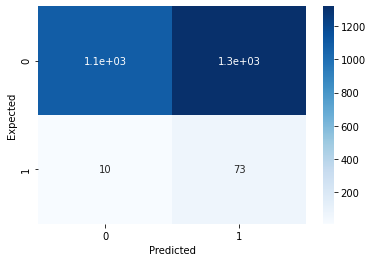

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
vect_transform = vectorizer.transform(new_test)
predict_test = mlp_unigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      1
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text))
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 19:32:32.410776-03:00 [INFO] starting training...
Iteration 1, loss = 0.73608944
Iteration 2, loss = 0.69797965
Iteration 3, loss = 0.66518084
Iteration 4, loss = 0.63624396
Iteration 5, loss = 0.61077950
Iteration 6, loss = 0.58831399
Iteration 7, loss = 0.56822987
Iteration 8, loss = 0.55041529
Iteration 9, loss = 0.53340875
Iteration 10, loss = 0.51810396
Iteration 11, loss = 0.50341083
Iteration 12, loss = 0.48942648
Iteration 13, loss = 0.47630434
Iteration 14, loss = 0.46338877
Iteration 15, loss = 0.45116884
Iteration 16, loss = 0.43935218
Iteration 17, loss = 0.42809193
Iteration 18, loss = 0.41702507
Iteration 19, loss = 0.40640345
Iteration 20, loss = 0.39614836
Iteration 21, loss = 0.38638938
Iteration 22, loss = 0.37672359
Iteration 23, loss = 0.36764666
Iteration 24, loss = 0.35865534
Iteration 25, loss = 0.35034649
Iteration 26, loss = 0.34195482
Iteration 27, loss = 0.33416504
Iteration 28, loss = 0.32661213
Iteration 29, loss = 0.31928904
Iteration 30, loss =

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 19:32:35.763051-03:00 [INFO] starting predict...
2020-10-27 19:32:35.770146-03:00 [INFO] predict successful...


2020-10-27 19:32:35.785411-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 19:32:35.788580-03:00 [INFO] Accuracy = 0.1470941883767535
              precision    recall  f1-score   support

           0       0.99      0.12      0.21      2412
           1       0.04      0.96      0.07        83

    accuracy                           0.15      2495
   macro avg       0.51      0.54      0.14      2495
weighted avg       0.96      0.15      0.21      2495



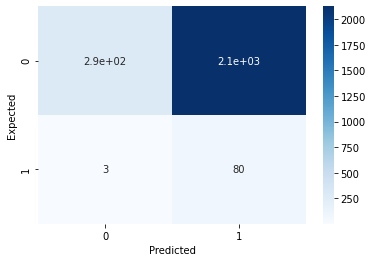

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
vect_transform = negative_vectorizer.transform(new_test)
predict_test = mlp_unigram.predict(vect_transform)
pd.DataFrame(zip(new_test, predict_test), columns=['tweet', 'class'])

tweet  class
0                         amanha vou pro role amigas      1
1                                 estou indo mercado      0
2                  alguem ir comigo festa semana vem      1
3             to festa julia ta top vem pra ca amiga      1
4        daqui pouco vou hospital fazer exame sangue      1
5                     nao estou saindo casa pra nada      1
6                              nao estou saindo casa      1
7      dias sem sair casa quarentena ta deixando ...      1

In [ ]:
word_context = ['festa', 'role', 'evento', 'balada', 'sair', 'saindo', 
                'indo', 'vamos', 'vou', 'churrasco', 'churras', 'churrascão', 
                'rodeio', 'show', 'viagem', 'viajar']

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text, word_context))
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:24:35.905427-03:00 [INFO] starting training...
Iteration 1, loss = 0.81919483
Iteration 2, loss = 0.77090449
Iteration 3, loss = 0.72619959
Iteration 4, loss = 0.68734893
Iteration 5, loss = 0.65283408
Iteration 6, loss = 0.62147053
Iteration 7, loss = 0.59349328
Iteration 8, loss = 0.56888772
Iteration 9, loss = 0.54706310
Iteration 10, loss = 0.52765736
Iteration 11, loss = 0.51006107
Iteration 12, loss = 0.49439506
Iteration 13, loss = 0.47992044
Iteration 14, loss = 0.46704324
Iteration 15, loss = 0.45460551
Iteration 16, loss = 0.44285292
Iteration 17, loss = 0.43168268
Iteration 18, loss = 0.42067908
Iteration 19, loss = 0.41048873
Iteration 20, loss = 0.40041422
Iteration 21, loss = 0.39066480
Iteration 22, loss = 0.38131394
Iteration 23, loss = 0.37218421
Iteration 24, loss = 0.36348465
Iteration 25, loss = 0.35507569
Iteration 26, loss = 0.34693949
Iteration 27, loss = 0.33911081
Iteration 28, loss = 0.33153701
Iteration 29, loss = 0.32432181
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:24:45.306055-03:00 [INFO] starting predict...
2020-10-27 20:24:45.309032-03:00 [INFO] predict successful...


2020-10-27 20:24:45.322869-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:24:45.323235-03:00 [INFO] Accuracy = 0.1531062124248497
              precision    recall  f1-score   support

           0       0.99      0.12      0.22      2412
           1       0.04      0.98      0.07        83

    accuracy                           0.15      2495
   macro avg       0.52      0.55      0.15      2495
weighted avg       0.96      0.15      0.22      2495



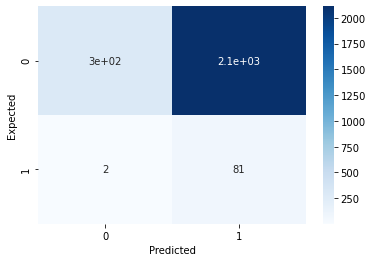

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(tokenizer=lambda text: negative_phrase(text, word_context), ngram_range=(2,2))
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:28:27.138153-03:00 [INFO] starting training...
Iteration 1, loss = 0.74951204
Iteration 2, loss = 0.65850325
Iteration 3, loss = 0.60309829
Iteration 4, loss = 0.55584009
Iteration 5, loss = 0.51230101
Iteration 6, loss = 0.47366893
Iteration 7, loss = 0.44059362
Iteration 8, loss = 0.41004756
Iteration 9, loss = 0.38301753
Iteration 10, loss = 0.35865813
Iteration 11, loss = 0.33645202
Iteration 12, loss = 0.31669410
Iteration 13, loss = 0.29826086
Iteration 14, loss = 0.28199991
Iteration 15, loss = 0.26706048
Iteration 16, loss = 0.25338064
Iteration 17, loss = 0.24082447
Iteration 18, loss = 0.22948226
Iteration 19, loss = 0.21924435
Iteration 20, loss = 0.20945337
Iteration 21, loss = 0.20071588
Iteration 22, loss = 0.19243666
Iteration 23, loss = 0.18488897
Iteration 24, loss = 0.17803862
Iteration 25, loss = 0.17144491
Iteration 26, loss = 0.16550323
Iteration 27, loss = 0.15973555
Iteration 28, loss = 0.15458498
Iteration 29, loss = 0.14964311
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:28:29.418642-03:00 [INFO] starting predict...
2020-10-27 20:28:29.425851-03:00 [INFO] predict successful...


2020-10-27 20:28:29.436720-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:28:29.436835-03:00 [INFO] Accuracy = 0.181563126252505
              precision    recall  f1-score   support

           0       0.99      0.16      0.27      2412
           1       0.04      0.95      0.07        83

    accuracy                           0.18      2495
   macro avg       0.51      0.55      0.17      2495
weighted avg       0.96      0.18      0.26      2495



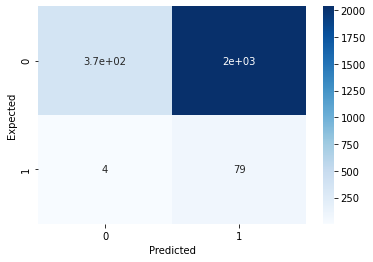

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(3,3)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:29:39.624495-03:00 [INFO] starting training...
Iteration 1, loss = 0.65463434
Iteration 2, loss = 0.54168120
Iteration 3, loss = 0.48737907
Iteration 4, loss = 0.44377614
Iteration 5, loss = 0.40544221
Iteration 6, loss = 0.37044474
Iteration 7, loss = 0.33907426
Iteration 8, loss = 0.31153655
Iteration 9, loss = 0.28693102
Iteration 10, loss = 0.26521955
Iteration 11, loss = 0.24589570
Iteration 12, loss = 0.22874812
Iteration 13, loss = 0.21316980
Iteration 14, loss = 0.19931588
Iteration 15, loss = 0.18705261
Iteration 16, loss = 0.17562317
Iteration 17, loss = 0.16549715
Iteration 18, loss = 0.15627386
Iteration 19, loss = 0.14781521
Iteration 20, loss = 0.14011609
Iteration 21, loss = 0.13308214
Iteration 22, loss = 0.12648654
Iteration 23, loss = 0.12060750
Iteration 24, loss = 0.11507689
Iteration 25, loss = 0.10991337
Iteration 26, loss = 0.10513569
Iteration 27, loss = 0.10067567
Iteration 28, loss = 0.09652675
Iteration 29, loss = 0.09270957
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:29:43.886603-03:00 [INFO] starting predict...
2020-10-27 20:29:43.895844-03:00 [INFO] predict successful...


2020-10-27 20:29:43.985902-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:29:43.986047-03:00 [INFO] Accuracy = 0.23847695390781562
              precision    recall  f1-score   support

           0       0.99      0.22      0.35      2412
           1       0.04      0.92      0.07        83

    accuracy                           0.24      2495
   macro avg       0.51      0.57      0.21      2495
weighted avg       0.96      0.24      0.34      2495



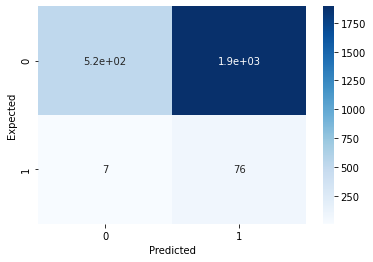

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(1,2)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:30:36.937955-03:00 [INFO] starting training...
Iteration 1, loss = 0.76842514
Iteration 2, loss = 0.48703758
Iteration 3, loss = 0.43824384
Iteration 4, loss = 0.40146351
Iteration 5, loss = 0.36060546
Iteration 6, loss = 0.32695330
Iteration 7, loss = 0.30207487
Iteration 8, loss = 0.28279530
Iteration 9, loss = 0.26494753
Iteration 10, loss = 0.24946352
Iteration 11, loss = 0.23584103
Iteration 12, loss = 0.22398692
Iteration 13, loss = 0.21320786
Iteration 14, loss = 0.20350733
Iteration 15, loss = 0.19472421
Iteration 16, loss = 0.18675128
Iteration 17, loss = 0.17936190
Iteration 18, loss = 0.17266711
Iteration 19, loss = 0.16651197
Iteration 20, loss = 0.16079432
Iteration 21, loss = 0.15537116
Iteration 22, loss = 0.15045518
Iteration 23, loss = 0.14581026
Iteration 24, loss = 0.14145425
Iteration 25, loss = 0.13767820
Iteration 26, loss = 0.13371290
Iteration 27, loss = 0.13003396
Iteration 28, loss = 0.12664332
Iteration 29, loss = 0.12346622
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:30:39.600880-03:00 [INFO] starting predict...
2020-10-27 20:30:39.610166-03:00 [INFO] predict successful...


2020-10-27 20:30:39.620263-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:30:39.622034-03:00 [INFO] Accuracy = 0.17715430861723447
              precision    recall  f1-score   support

           0       0.99      0.15      0.26      2412
           1       0.04      0.98      0.07        83

    accuracy                           0.18      2495
   macro avg       0.52      0.56      0.17      2495
weighted avg       0.96      0.18      0.25      2495



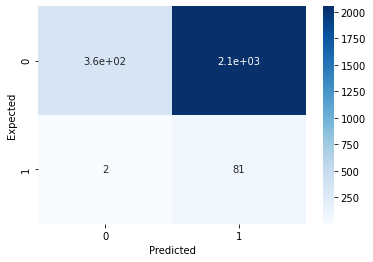

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(2,3)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:31:38.253335-03:00 [INFO] starting training...
Iteration 1, loss = 0.58435822
Iteration 2, loss = 0.47587198
Iteration 3, loss = 0.41586795
Iteration 4, loss = 0.36056966
Iteration 5, loss = 0.31534305
Iteration 6, loss = 0.28067460
Iteration 7, loss = 0.25212198
Iteration 8, loss = 0.22811113
Iteration 9, loss = 0.20783932
Iteration 10, loss = 0.19055047
Iteration 11, loss = 0.17579578
Iteration 12, loss = 0.16293264
Iteration 13, loss = 0.15166614
Iteration 14, loss = 0.14179968
Iteration 15, loss = 0.13299183
Iteration 16, loss = 0.12498602
Iteration 17, loss = 0.11806425
Iteration 18, loss = 0.11156143
Iteration 19, loss = 0.10574090
Iteration 20, loss = 0.10044584
Iteration 21, loss = 0.09553159
Iteration 22, loss = 0.09105809
Iteration 23, loss = 0.08694073
Iteration 24, loss = 0.08310665
Iteration 25, loss = 0.07953306
Iteration 26, loss = 0.07620497
Iteration 27, loss = 0.07320265
Iteration 28, loss = 0.07036900
Iteration 29, loss = 0.06759912
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:31:43.085910-03:00 [INFO] starting predict...
2020-10-27 20:31:43.092314-03:00 [INFO] predict successful...


2020-10-27 20:31:43.114882-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:31:43.116598-03:00 [INFO] Accuracy = 0.2124248496993988
              precision    recall  f1-score   support

           0       0.98      0.19      0.32      2412
           1       0.04      0.92      0.07        83

    accuracy                           0.21      2495
   macro avg       0.51      0.55      0.19      2495
weighted avg       0.95      0.21      0.31      2495



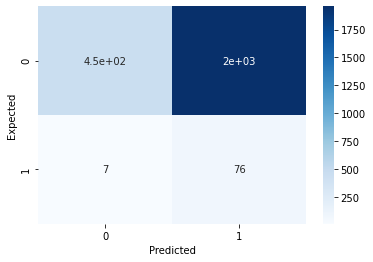

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(1,3)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:32:55.760668-03:00 [INFO] starting training...
Iteration 1, loss = 0.58618217
Iteration 2, loss = 0.42142230
Iteration 3, loss = 0.38969217
Iteration 4, loss = 0.35569795
Iteration 5, loss = 0.32049272
Iteration 6, loss = 0.28950641
Iteration 7, loss = 0.26497450
Iteration 8, loss = 0.24400486
Iteration 9, loss = 0.22509368
Iteration 10, loss = 0.20811592
Iteration 11, loss = 0.19309847
Iteration 12, loss = 0.17992108
Iteration 13, loss = 0.16815095
Iteration 14, loss = 0.15762951
Iteration 15, loss = 0.14819494
Iteration 16, loss = 0.13981483
Iteration 17, loss = 0.13201580
Iteration 18, loss = 0.12510380
Iteration 19, loss = 0.11874668
Iteration 20, loss = 0.11293563
Iteration 21, loss = 0.10767842
Iteration 22, loss = 0.10262570
Iteration 23, loss = 0.09812807
Iteration 24, loss = 0.09391948
Iteration 25, loss = 0.09002246
Iteration 26, loss = 0.08639731
Iteration 27, loss = 0.08298059
Iteration 28, loss = 0.07984191
Iteration 29, loss = 0.07687204
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:33:00.093923-03:00 [INFO] starting predict...
2020-10-27 20:33:00.104235-03:00 [INFO] predict successful...


2020-10-27 20:33:00.110935-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:33:00.111350-03:00 [INFO] Accuracy = 0.19959919839679358
              precision    recall  f1-score   support

           0       0.99      0.17      0.30      2412
           1       0.04      0.95      0.07        83

    accuracy                           0.20      2495
   macro avg       0.51      0.56      0.18      2495
weighted avg       0.96      0.20      0.29      2495



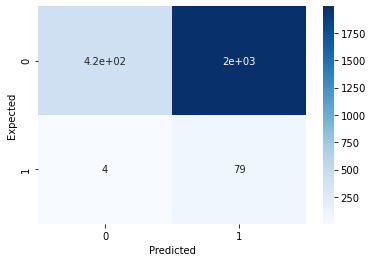

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(4,4)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:33:52.581929-03:00 [INFO] starting training...
Iteration 1, loss = 0.66630548
Iteration 2, loss = 0.56071269
Iteration 3, loss = 0.50353732
Iteration 4, loss = 0.45737626
Iteration 5, loss = 0.41671283
Iteration 6, loss = 0.38006015
Iteration 7, loss = 0.34739717
Iteration 8, loss = 0.31763621
Iteration 9, loss = 0.29168651
Iteration 10, loss = 0.26834950
Iteration 11, loss = 0.24754203
Iteration 12, loss = 0.22897348
Iteration 13, loss = 0.21249390
Iteration 14, loss = 0.19782013
Iteration 15, loss = 0.18467435
Iteration 16, loss = 0.17272230
Iteration 17, loss = 0.16189955
Iteration 18, loss = 0.15233173
Iteration 19, loss = 0.14355398
Iteration 20, loss = 0.13553545
Iteration 21, loss = 0.12825878
Iteration 22, loss = 0.12161840
Iteration 23, loss = 0.11547008
Iteration 24, loss = 0.10982037
Iteration 25, loss = 0.10472670
Iteration 26, loss = 0.09995427
Iteration 27, loss = 0.09548698
Iteration 28, loss = 0.09142135
Iteration 29, loss = 0.08755415
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:34:06.014856-03:00 [INFO] starting predict...
2020-10-27 20:34:06.021123-03:00 [INFO] predict successful...


2020-10-27 20:34:06.028800-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:34:06.029385-03:00 [INFO] Accuracy = 0.29979959919839677
              precision    recall  f1-score   support

           0       0.98      0.28      0.44      2412
           1       0.04      0.86      0.08        83

    accuracy                           0.30      2495
   macro avg       0.51      0.57      0.26      2495
weighted avg       0.95      0.30      0.42      2495



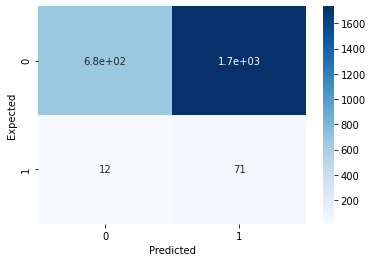

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(1,4)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:35:37.619892-03:00 [INFO] starting training...
Iteration 1, loss = 0.54003778
Iteration 2, loss = 0.43884546
Iteration 3, loss = 0.37125745
Iteration 4, loss = 0.31163234
Iteration 5, loss = 0.26946576
Iteration 6, loss = 0.23746716
Iteration 7, loss = 0.21036272
Iteration 8, loss = 0.18862863
Iteration 9, loss = 0.17083686
Iteration 10, loss = 0.15587540
Iteration 11, loss = 0.14299002
Iteration 12, loss = 0.13184964
Iteration 13, loss = 0.12234745
Iteration 14, loss = 0.11378035
Iteration 15, loss = 0.10609609
Iteration 16, loss = 0.09944268
Iteration 17, loss = 0.09345109
Iteration 18, loss = 0.08788035
Iteration 19, loss = 0.08301195
Iteration 20, loss = 0.07857253
Iteration 21, loss = 0.07444353
Iteration 22, loss = 0.07069920
Iteration 23, loss = 0.06733037
Iteration 24, loss = 0.06417659
Iteration 25, loss = 0.06136719
Iteration 26, loss = 0.05859042
Iteration 27, loss = 0.05608809
Iteration 28, loss = 0.05378665
Iteration 29, loss = 0.05168097
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:35:49.867878-03:00 [INFO] starting predict...
2020-10-27 20:35:49.879462-03:00 [INFO] predict successful...


2020-10-27 20:35:49.889443-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:35:49.890515-03:00 [INFO] Accuracy = 0.23486973947895792
              precision    recall  f1-score   support

           0       0.98      0.21      0.35      2412
           1       0.04      0.90      0.07        83

    accuracy                           0.23      2495
   macro avg       0.51      0.56      0.21      2495
weighted avg       0.95      0.23      0.34      2495



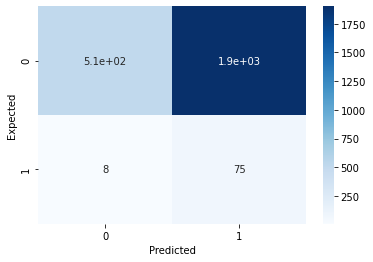

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(2,4)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:36:55.494707-03:00 [INFO] starting training...
Iteration 1, loss = 0.53719855
Iteration 2, loss = 0.40605719
Iteration 3, loss = 0.33552448
Iteration 4, loss = 0.27744459
Iteration 5, loss = 0.23489164
Iteration 6, loss = 0.20472079
Iteration 7, loss = 0.18133236
Iteration 8, loss = 0.16215464
Iteration 9, loss = 0.14627072
Iteration 10, loss = 0.13292723
Iteration 11, loss = 0.12193818
Iteration 12, loss = 0.11236951
Iteration 13, loss = 0.10393277
Iteration 14, loss = 0.09661720
Iteration 15, loss = 0.09027791
Iteration 16, loss = 0.08458856
Iteration 17, loss = 0.07937014
Iteration 18, loss = 0.07479410
Iteration 19, loss = 0.07066619
Iteration 20, loss = 0.06694486
Iteration 21, loss = 0.06339850
Iteration 22, loss = 0.06030109
Iteration 23, loss = 0.05738919
Iteration 24, loss = 0.05467684
Iteration 25, loss = 0.05229834
Iteration 26, loss = 0.04995436
Iteration 27, loss = 0.04783694
Iteration 28, loss = 0.04587577
Iteration 29, loss = 0.04408975
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:37:06.434900-03:00 [INFO] starting predict...
2020-10-27 20:37:06.446490-03:00 [INFO] predict successful...


2020-10-27 20:37:06.457120-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:37:06.458292-03:00 [INFO] Accuracy = 0.24248496993987975
              precision    recall  f1-score   support

           0       0.98      0.22      0.36      2412
           1       0.04      0.89      0.07        83

    accuracy                           0.24      2495
   macro avg       0.51      0.56      0.22      2495
weighted avg       0.95      0.24      0.35      2495



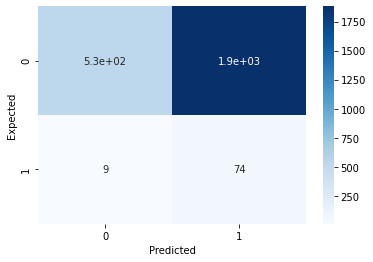

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(3,4)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:38:08.503679-03:00 [INFO] starting training...
Iteration 1, loss = 0.55737353
Iteration 2, loss = 0.41174689
Iteration 3, loss = 0.35377027
Iteration 4, loss = 0.31002790
Iteration 5, loss = 0.27365398
Iteration 6, loss = 0.24340391
Iteration 7, loss = 0.21825407
Iteration 8, loss = 0.19755702
Iteration 9, loss = 0.18035306
Iteration 10, loss = 0.16552079
Iteration 11, loss = 0.15241038
Iteration 12, loss = 0.14086941
Iteration 13, loss = 0.13085942
Iteration 14, loss = 0.12185141
Iteration 15, loss = 0.11385517
Iteration 16, loss = 0.10668875
Iteration 17, loss = 0.10017159
Iteration 18, loss = 0.09433342
Iteration 19, loss = 0.08896407
Iteration 20, loss = 0.08412656
Iteration 21, loss = 0.07969871
Iteration 22, loss = 0.07562929
Iteration 23, loss = 0.07192808
Iteration 24, loss = 0.06848201
Iteration 25, loss = 0.06531488
Iteration 26, loss = 0.06237351
Iteration 27, loss = 0.05962163
Iteration 28, loss = 0.05705328
Iteration 29, loss = 0.05468201
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:38:18.536074-03:00 [INFO] starting predict...
2020-10-27 20:38:18.544680-03:00 [INFO] predict successful...


2020-10-27 20:38:18.559088-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:38:18.559447-03:00 [INFO] Accuracy = 0.25771543086172344
              precision    recall  f1-score   support

           0       0.98      0.24      0.38      2412
           1       0.04      0.89      0.07        83

    accuracy                           0.26      2495
   macro avg       0.51      0.56      0.23      2495
weighted avg       0.95      0.26      0.37      2495



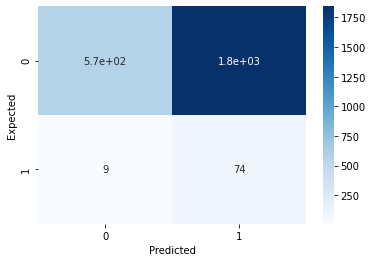

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(2,5)
)
negative_vectorizer.fit_transform(tweets)
X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:45:05.605454-03:00 [INFO] starting training...
Iteration 1, loss = 0.64333880
Iteration 2, loss = 0.48601218
Iteration 3, loss = 0.37676667
Iteration 4, loss = 0.29961251
Iteration 5, loss = 0.24818954
Iteration 6, loss = 0.21068301
Iteration 7, loss = 0.18256258
Iteration 8, loss = 0.16105998
Iteration 9, loss = 0.14384265
Iteration 10, loss = 0.12980393
Iteration 11, loss = 0.11856838
Iteration 12, loss = 0.10864101
Iteration 13, loss = 0.10034801
Iteration 14, loss = 0.09303051
Iteration 15, loss = 0.08672831
Iteration 16, loss = 0.08113640
Iteration 17, loss = 0.07621985
Iteration 18, loss = 0.07160925
Iteration 19, loss = 0.06775047
Iteration 20, loss = 0.06399698
Iteration 21, loss = 0.06070591
Iteration 22, loss = 0.05772401
Iteration 23, loss = 0.05492644
Iteration 24, loss = 0.05235725
Iteration 25, loss = 0.05005443
Iteration 26, loss = 0.04785073
Iteration 27, loss = 0.04580214
Iteration 28, loss = 0.04391821
Iteration 29, loss = 0.04215502
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 20:45:41.434842-03:00 [INFO] starting predict...
2020-10-27 20:45:41.451761-03:00 [INFO] predict successful...


2020-10-27 20:45:41.469856-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 20:45:41.470214-03:00 [INFO] Accuracy = 0.3034068136272545
              precision    recall  f1-score   support

           0       0.99      0.28      0.44      2412
           1       0.04      0.89      0.08        83

    accuracy                           0.30      2495
   macro avg       0.51      0.59      0.26      2495
weighted avg       0.96      0.30      0.43      2495



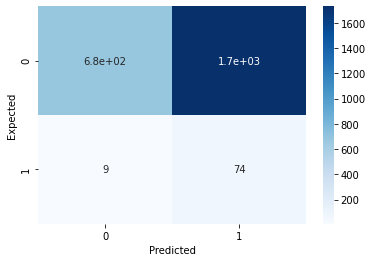

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(2,3)
)
vect_all = negative_vectorizer.fit_transform(tweets)
tf = TfidfTransformer(use_idf=False)

X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
tf.fit_transform(vect_all)
X_train_unigram_neg = tf.transform(X_train_unigram_neg)
X_test_unigram_neg = tf.transform(X_test_unigram_neg)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:10:21.087716-03:00 [INFO] starting training...
Iteration 1, loss = 0.68401473
Iteration 2, loss = 0.64786372
Iteration 3, loss = 0.61404278
Iteration 4, loss = 0.58088134
Iteration 5, loss = 0.54933921
Iteration 6, loss = 0.51940313
Iteration 7, loss = 0.49064742
Iteration 8, loss = 0.46419577
Iteration 9, loss = 0.43967269
Iteration 10, loss = 0.41663798
Iteration 11, loss = 0.39630721
Iteration 12, loss = 0.37757239
Iteration 13, loss = 0.36082959
Iteration 14, loss = 0.34590897
Iteration 15, loss = 0.33223205
Iteration 16, loss = 0.32062085
Iteration 17, loss = 0.31029038
Iteration 18, loss = 0.30106244
Iteration 19, loss = 0.29265386
Iteration 20, loss = 0.28539666
Iteration 21, loss = 0.27878332
Iteration 22, loss = 0.27287077
Iteration 23, loss = 0.26754937
Iteration 24, loss = 0.26280173
Iteration 25, loss = 0.25842036
Iteration 26, loss = 0.25429854
Iteration 27, loss = 0.25067660
Iteration 28, loss = 0.24719093
Iteration 29, loss = 0.24398548
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:10:34.003285-03:00 [INFO] starting predict...
2020-10-27 21:10:34.009294-03:00 [INFO] predict successful...


2020-10-27 21:10:34.023487-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 21:10:34.024081-03:00 [INFO] Accuracy = 0.3342685370741483
              precision    recall  f1-score   support

           0       0.99      0.32      0.48      2412
           1       0.04      0.88      0.08        83

    accuracy                           0.33      2495
   macro avg       0.51      0.60      0.28      2495
weighted avg       0.96      0.33      0.46      2495



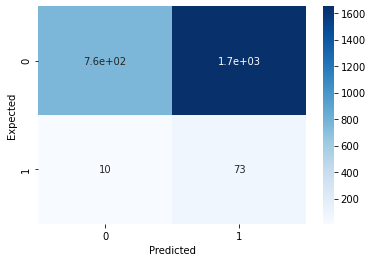

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(1,3)
)
vect_all = negative_vectorizer.fit_transform(tweets)
tf = TfidfTransformer(use_idf=False)

X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
tf.fit_transform(vect_all)
X_train_unigram_neg = tf.transform(X_train_unigram_neg)
X_test_unigram_neg = tf.transform(X_test_unigram_neg)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:08:25.648479-03:00 [INFO] starting training...
Iteration 1, loss = 0.72798214
Iteration 2, loss = 0.69506622
Iteration 3, loss = 0.66492248
Iteration 4, loss = 0.63692247
Iteration 5, loss = 0.61073977
Iteration 6, loss = 0.58702124
Iteration 7, loss = 0.56394663
Iteration 8, loss = 0.54247782
Iteration 9, loss = 0.52167197
Iteration 10, loss = 0.50161015
Iteration 11, loss = 0.48225570
Iteration 12, loss = 0.46350908
Iteration 13, loss = 0.44538342
Iteration 14, loss = 0.42868703
Iteration 15, loss = 0.41238405
Iteration 16, loss = 0.39742424
Iteration 17, loss = 0.38347882
Iteration 18, loss = 0.37073938
Iteration 19, loss = 0.35861502
Iteration 20, loss = 0.34758648
Iteration 21, loss = 0.33779082
Iteration 22, loss = 0.32855312
Iteration 23, loss = 0.32024599
Iteration 24, loss = 0.31276421
Iteration 25, loss = 0.30582148
Iteration 26, loss = 0.29951185
Iteration 27, loss = 0.29406761
Iteration 28, loss = 0.28851285
Iteration 29, loss = 0.28381589
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:08:41.069935-03:00 [INFO] starting predict...
2020-10-27 21:08:41.076668-03:00 [INFO] predict successful...


2020-10-27 21:08:41.094753-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 21:08:41.095140-03:00 [INFO] Accuracy = 0.2977955911823647
              precision    recall  f1-score   support

           0       0.99      0.28      0.43      2412
           1       0.04      0.90      0.08        83

    accuracy                           0.30      2495
   macro avg       0.51      0.59      0.26      2495
weighted avg       0.96      0.30      0.42      2495



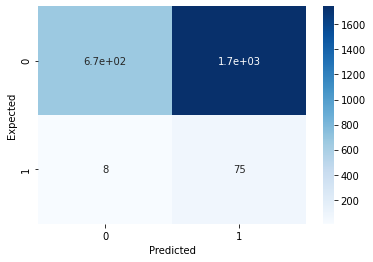

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(2,5)
)
vect_all = negative_vectorizer.fit_transform(tweets)
tf = TfidfTransformer(use_idf=False)

X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
tf.fit_transform(vect_all)
X_train_unigram_neg = tf.transform(X_train_unigram_neg)
X_test_unigram_neg = tf.transform(X_test_unigram_neg)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:06:22.182289-03:00 [INFO] starting training...
Iteration 1, loss = 0.72988437
Iteration 2, loss = 0.66350992
Iteration 3, loss = 0.60187805
Iteration 4, loss = 0.54634874
Iteration 5, loss = 0.49645864
Iteration 6, loss = 0.45244718
Iteration 7, loss = 0.41439098
Iteration 8, loss = 0.38178848
Iteration 9, loss = 0.35367716
Iteration 10, loss = 0.32996518
Iteration 11, loss = 0.31031743
Iteration 12, loss = 0.29380450
Iteration 13, loss = 0.27950387
Iteration 14, loss = 0.26730788
Iteration 15, loss = 0.25704755
Iteration 16, loss = 0.24811970
Iteration 17, loss = 0.24023627
Iteration 18, loss = 0.23317759
Iteration 19, loss = 0.22694228
Iteration 20, loss = 0.22125983
Iteration 21, loss = 0.21594731
Iteration 22, loss = 0.21115279
Iteration 23, loss = 0.20651105
Iteration 24, loss = 0.20222237
Iteration 25, loss = 0.19810635
Iteration 26, loss = 0.19422799
Iteration 27, loss = 0.19041087
Iteration 28, loss = 0.18675385
Iteration 29, loss = 0.18331251
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:07:34.165638-03:00 [INFO] starting predict...
2020-10-27 21:07:34.180630-03:00 [INFO] predict successful...


2020-10-27 21:07:34.198940-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 21:07:34.199337-03:00 [INFO] Accuracy = 0.34909819639278555
              precision    recall  f1-score   support

           0       0.99      0.33      0.50      2412
           1       0.04      0.89      0.08        83

    accuracy                           0.35      2495
   macro avg       0.52      0.61      0.29      2495
weighted avg       0.96      0.35      0.48      2495



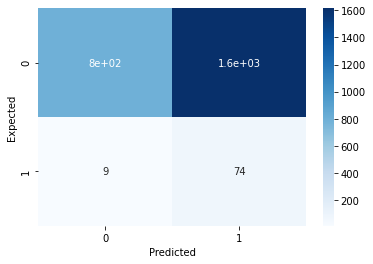

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)

In [ ]:
negative_vectorizer = CountVectorizer(
    tokenizer=lambda text: negative_phrase(text, word_context), 
    ngram_range=(2,3)
)
vect_all = negative_vectorizer.fit_transform(tweets)
tf = TfidfTransformer(use_idf=True)

X_train_unigram_neg = negative_vectorizer.transform(X_train)
X_test_unigram_neg = negative_vectorizer.transform(X_test)
tf.fit_transform(vect_all)
X_train_unigram_neg = tf.transform(X_train_unigram_neg)
X_test_unigram_neg = tf.transform(X_test_unigram_neg)
X, y = nm.fit_sample(X_train_unigram_neg, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mlp_unigram = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=10,
              warm_start=False)

In [ ]:
print('{} [INFO] starting training...'.format(dt.datetime.now().astimezone(tz)))
mlp_unigram.fit(X, y)
print('{} [INFO] finish mlp_unigram...'.format(dt.datetime.now().astimezone(tz)))
print('{} [INFO] training successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:42:58.377427-03:00 [INFO] starting training...
Iteration 1, loss = 0.69646615
Iteration 2, loss = 0.69478311
Iteration 3, loss = 0.69247291
Iteration 4, loss = 0.68990409
Iteration 5, loss = 0.68733994
Iteration 6, loss = 0.68476375
Iteration 7, loss = 0.68216269
Iteration 8, loss = 0.67953536
Iteration 9, loss = 0.67694910
Iteration 10, loss = 0.67437070
Iteration 11, loss = 0.67178541
Iteration 12, loss = 0.66916395
Iteration 13, loss = 0.66656428
Iteration 14, loss = 0.66396141
Iteration 15, loss = 0.66135946
Iteration 16, loss = 0.65877449
Iteration 17, loss = 0.65615557
Iteration 18, loss = 0.65356496
Iteration 19, loss = 0.65100461
Iteration 20, loss = 0.64841336
Iteration 21, loss = 0.64585082
Iteration 22, loss = 0.64325690
Iteration 23, loss = 0.64069840
Iteration 24, loss = 0.63813297
Iteration 25, loss = 0.63556203
Iteration 26, loss = 0.63299262
Iteration 27, loss = 0.63040972
Iteration 28, loss = 0.62786362
Iteration 29, loss = 0.62528994
Iteration 30, loss =

In [ ]:
print('{} [INFO] starting predict...'.format(dt.datetime.now().astimezone(tz)))
y_pred_mlp_unigram_1 = mlp_unigram.predict(X_test_unigram_neg)
print('{} [INFO] predict successful...'.format(dt.datetime.now().astimezone(tz)))

2020-10-27 21:43:11.481446-03:00 [INFO] starting predict...
2020-10-27 21:43:11.486731-03:00 [INFO] predict successful...


2020-10-27 21:43:11.497041-03:00 [INFO] Metrics using mlp_unigram_1
2020-10-27 21:43:11.497915-03:00 [INFO] Accuracy = 0.23406813627254508
              precision    recall  f1-score   support

           0       0.98      0.21      0.35      2412
           1       0.04      0.86      0.07        83

    accuracy                           0.23      2495
   macro avg       0.51      0.53      0.21      2495
weighted avg       0.95      0.23      0.34      2495



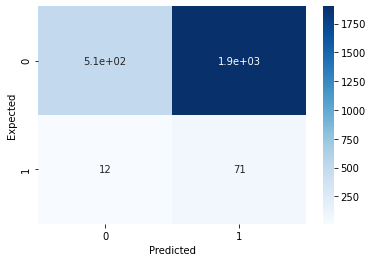

In [ ]:
get_report('mlp_unigram_1', y_test, y_pred_mlp_unigram_1)